## OHLCV IMG creation


This is the creation of trading charts from the csv OHLCV dataset 

In [2]:
!pip install mplfinance
import mplfinance as mpf

  Using cached matplotlib-3.9.4-cp39-cp39-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.0-cp39-cp39-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.7-cp39-cp39-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
Using cached matplotlib-3.9.4-cp39-cp39-win_amd64.whl (7.8 MB)
Using cached contourpy-1.3.0-cp39-cp39-win_amd64.whl (211 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 16.0 MB/s eta 0:00:00
Using cached importlib_resources-6.5.2-py3-none-any.whl (37 kB)
Using cached kiwisolver-1.4.7-cp39-cp39-win_amd64.whl (55 kB)
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 

In [3]:
!pip install yfinance matplotlib plotly

     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 3.0/3.0 MB 29.7 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached beautifulsoup4-4.13.4-py3-none-any.whl.metadata (3.8 kB)
  Using cached soupsieve-2.7-py3-none-any.whl.metadata (4.6 kB)
  Using cached cffi-1.17.1-cp39-cp39-win_amd64.whl.metadata (1.6 kB)
  Using cached pycparser-2.22-py3-none-any.whl.metadata (943 bytes)
   ---------------------------------------- 0.0/16.1 MB ? eta -:--:--
   -------------- ------------------------- 5.8/16.1 MB 27.1 MB/s eta 0:00:01
   -------------------------------- ------- 13.1/16.1 MB 30.4 MB/s eta 0:00:01
   -----------------

In [ ]:
import os
import pandas as pd
import mplfinance as mpf

csv_path = r'C:\Users\chidi\Documents\timeseries_projects\data\XRPUSDT_hourly_2017_2024.csv'
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV file not found at path: {csv_path}. Please check the file location.")

# Load your dataset
df = pd.read_csv(csv_path, parse_dates=['open_time'], index_col='open_time')

# Ensure your DataFrame has the required OHLCV columns
ohlcv = df[['open', 'high', 'low', 'close', 'volume']]

# Optional: Define overlays (e.g., 20 & 50 period moving average)
mav = (12, 24, 50, 200)  # 4-period and 8-period moving averages
# Set the style for the charts

# Loop through and save chart images (e.g., one every 100 rows)
for i in range(0, len(ohlcv) - 100, 20):  # Slide every 50 rows
    chunk = ohlcv.iloc[i:i+100]
    filename = f'chart_{i}.png'
    
    mpf.plot(chunk, type='candle', mav=mav, volume=True,
             style='yahoo', savefig=filename)

In [20]:
import os
import pandas as pd
import mplfinance as mpf
import numpy as np

# --- CONFIGURATION ---
INPUT_CSV = r'C:\Users\chidi\Documents\timeseries_projects\data\XRPUSDT_hourly_2017_2024.csv'
OUTPUT_DIR = "chart_dataset"
WINDOW_SIZE = 100
STRIDE = 20
IMG_WIDTH = 640
IMG_HEIGHT = 480

# Class names
CLASSES = {
    "golden_cross": 0,
    "rsi_overbought": 1,
    "macd_bullish": 2
}

# --- SETUP ---
os.makedirs(f"{OUTPUT_DIR}/images", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/labels", exist_ok=True)

with open(f"{OUTPUT_DIR}/classes.txt", "w") as f:
    for name in CLASSES:
        f.write(f"{name}\n")

# --- LOAD DATA ---
df = pd.read_csv(INPUT_CSV, parse_dates=["open_time"], index_col="open_time")
df = df[['open', 'high', 'low', 'close', 'volume']]

# --- ADD INDICATORS ---
df['MA50'] = df['close'].rolling(50).mean()
df['MA200'] = df['close'].rolling(200).mean()

df['RSI'] = 100 - (100 / (1 + df['close'].pct_change().rolling(14).mean() /
                               -df['close'].pct_change().rolling(14).std()))

ema12 = df['close'].ewm(span=12, adjust=False).mean()
ema26 = df['close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema12 - ema26
df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# --- SLIDING WINDOW + DETECTION ---
img_count = 0
for i in range(0, len(df) - WINDOW_SIZE, STRIDE):
    window = df.iloc[i:i+WINDOW_SIZE].copy()
    annotations = []

    # PATTERN: Golden Cross
    cross = (window['MA50'] > window['MA200']) & (window['MA50'].shift(1) <= window['MA200'].shift(1))
    for j in cross[cross].index:
        idx = window.index.get_loc(j)
        x_center = idx / WINDOW_SIZE
        annotations.append((CLASSES['golden_cross'], x_center, 0.8, 0.1, 0.1))

    # PATTERN: RSI Overbought (> 70)
    rsi_trigger = (window['RSI'] > 70)
    for j in rsi_trigger[rsi_trigger].index:
        idx = window.index.get_loc(j)
        x_center = idx / WINDOW_SIZE
        annotations.append((CLASSES['rsi_overbought'], x_center, 0.2, 0.1, 0.1))

    # PATTERN: MACD Bullish Crossover
    macd_cross = (window['MACD'] > window['Signal']) & (window['MACD'].shift(1) <= window['Signal'].shift(1))
    for j in macd_cross[macd_cross].index:
        idx = window.index.get_loc(j)
        x_center = idx / WINDOW_SIZE
        annotations.append((CLASSES['macd_bullish'], x_center, 0.5, 0.1, 0.1))

    if annotations:
        # SAVE CHART IMAGE
        img_name = f"chart_{img_count:03d}.png"
        label_name = f"chart_{img_count:03d}.txt"
        mpf.plot(window, type='candle', volume=True,
                 mav=(8, 24, 50, 200), style='yahoo',
                 savefig=f"{OUTPUT_DIR}/images/{img_name}")

        # SAVE ANNOTATIONS IN YOLO FORMAT
        with open(f"{OUTPUT_DIR}/labels/{label_name}", "w") as f:
            for cls_id, xc, yc, w, h in annotations:
                f.write(f"{cls_id} {xc:.4f} {yc:.4f} {w:.4f} {h:.4f}\n")

        img_count += 1

print(f"✅ {img_count} labeled chart images saved in: {OUTPUT_DIR}")


✅ 2985 labeled chart images saved in: chart_dataset


In [21]:
import os
import pandas as pd
import numpy as np
import mplfinance as mpf
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# === Config ===
INPUT_CSV = r'C:\Users\chidi\Documents\timeseries_projects\data\XRPUSDT_hourly_2017_2024.csv'
OUTPUT_DIR = "chart_dataset_with_boxes"
WINDOW_SIZE = 100
STRIDE = 20

# === Create output directory ===
os.makedirs(f"{OUTPUT_DIR}/images_with_boxes", exist_ok=True)

# === Classes ===
CLASSES = {
    "golden_cross": 0,
    "rsi_overbought": 1,
    "macd_bullish": 2
}

# === Load Data ===
df = pd.read_csv(INPUT_CSV, parse_dates=["open_time"], index_col="open_time")
df = df[['open', 'high', 'low', 'close', 'volume']]
df['MA50'] = df['close'].rolling(50).mean()
df['MA200'] = df['close'].rolling(200).mean()

# RSI
df['RSI'] = 100 - (100 / (1 + df['close'].pct_change().rolling(14).mean() /
                               -df['close'].pct_change().rolling(14).std()))

# MACD
ema12 = df['close'].ewm(span=12, adjust=False).mean()
ema26 = df['close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema12 - ema26
df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# === Sliding window chart + overlay ===
img_count = 0
for i in range(0, len(df) - WINDOW_SIZE, STRIDE):
    window = df.iloc[i:i+WINDOW_SIZE].copy()
    annotations = []

    # Pattern Detection
    cross = (window['MA50'] > window['MA200']) & (window['MA50'].shift(1) <= window['MA200'].shift(1))
    for j in cross[cross].index:
        idx = window.index.get_loc(j)
        x_center = idx / WINDOW_SIZE
        annotations.append((CLASSES['golden_cross'], x_center, 0.8, 0.1, 0.1))

    rsi_trigger = (window['RSI'] > 70)
    for j in rsi_trigger[rsi_trigger].index:
        idx = window.index.get_loc(j)
        x_center = idx / WINDOW_SIZE
        annotations.append((CLASSES['rsi_overbought'], x_center, 0.2, 0.1, 0.1))

    macd_cross = (window['MACD'] > window['Signal']) & (window['MACD'].shift(1) <= window['Signal'].shift(1))
    for j in macd_cross[macd_cross].index:
        idx = window.index.get_loc(j)
        x_center = idx / WINDOW_SIZE
        annotations.append((CLASSES['macd_bullish'], x_center, 0.5, 0.1, 0.1))

    if annotations:
        fig, axlist = mpf.plot(window, type='candle', volume=True,
                               mav=(8, 24, 50, 200), style='yahoo',
                               returnfig=True, figsize=(8, 6))
        ax = axlist[0]  # main candlestick axis

        for cls_id, x_c, y_c, w, h in annotations:
            x_pix = x_c * WINDOW_SIZE
            y_pix = y_c
            label = list(CLASSES.keys())[list(CLASSES.values()).index(cls_id)]

            # Draw rectangle
            rect = Rectangle((x_pix - w*WINDOW_SIZE/2, y_c - h/2),
                             w*WINDOW_SIZE, h,
                             linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            ax.text(x_pix, y_c + 0.05, label, color='red', fontsize=8)

        fig.savefig(f"{OUTPUT_DIR}/images_with_boxes/chart_{img_count:03d}.png")
        plt.close(fig)
        img_count += 1

print(f"✅ Done! Saved {img_count} images with bounding boxes to {OUTPUT_DIR}/images_with_boxes/")


✅ Done! Saved 2985 images with bounding boxes to chart_dataset_with_boxes/images_with_boxes/


In [22]:
!pip install spicy

  Using cached scipy-1.13.1-cp39-cp39-win_amd64.whl.metadata (60 kB)
Using cached scipy-1.13.1-cp39-cp39-win_amd64.whl (46.2 MB)


In [23]:
import os
import pandas as pd
import numpy as np
import mplfinance as mpf
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.signal import find_peaks

# === Config ===
INPUT_CSV = r'C:\Users\chidi\Documents\timeseries_projects\data\XRPUSDT_hourly_2017_2024.csv' # Your CSV with Date, OHLCV, indicators
OUTPUT_DIR = "chart_dataset"
WINDOW_SIZE = 100  # each chart will be based on 100 candles
STRIDE = 20  # slide window every 20 rows

# === Create output directory ===
os.makedirs(f"{OUTPUT_DIR}/images_with_boxes", exist_ok=True)

# === Classes ===
CLASSES = {
    "golden_cross": 0,
    "rsi_overbought": 1,
    "macd_bullish": 2,
    "triangle_asc": 3,
    "triangle_desc": 4,
    "cup_handle": 5
}

# === Load Data ===
df = pd.read_csv(INPUT_CSV, parse_dates=["open_time"], index_col="open_time")
df = df[['open', 'high', 'low', 'close', 'volume']].copy()
df['MA50'] = df['close'].rolling(50).mean()
df['MA200'] = df['close'].rolling(200).mean()

# RSI
delta = df['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# MACD
ema12 = df['close'].ewm(span=12, adjust=False).mean()
ema26 = df['close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema12 - ema26
df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# === Pattern detection functions ===
def detect_triangle_patterns(window_df, pattern="ascending"):
    prices = window_df["close"].values
    peaks, _ = find_peaks(prices, distance=3)
    troughs, _ = find_peaks(-prices, distance=3)
    detected = []

    if pattern == "ascending" and len(peaks) >= 2 and len(troughs) >= 2:
        highs = prices[peaks[-2:]]
        lows = prices[troughs[-2:]]
        if np.abs(highs[0] - highs[1]) < 0.005 * highs[0] and lows[1] > lows[0]:
            center = (peaks[-1] + troughs[-1]) / 2 / len(prices)
            detected.append(("triangle_asc", center, 0.6, 0.2, 0.2))

    if pattern == "descending" and len(peaks) >= 2 and len(troughs) >= 2:
        highs = prices[peaks[-2:]]
        lows = prices[troughs[-2:]]
        if np.abs(lows[0] - lows[1]) < 0.005 * lows[0] and highs[1] < highs[0]:
            center = (peaks[-1] + troughs[-1]) / 2 / len(prices)
            detected.append(("triangle_desc", center, 0.6, 0.2, 0.2))

    return detected

def detect_cup_handle(window_df):
    prices = window_df["close"].values
    min_idx = np.argmin(prices)
    left = prices[:min_idx]
    right = prices[min_idx+1:]
    if len(left) < 5 or len(right) < 5:
        return []
    if np.all(left > prices[min_idx]) and np.all(right > prices[min_idx]):
        if np.abs(np.mean(left[-3:]) - np.mean(right[:3])) / prices[min_idx] > 0.05:
            center = min_idx / len(prices)
            return [("cup_handle", center, 0.4, 0.3, 0.2)]
    return []

# === Generate chart images with bounding boxes ===
img_count = 0
for i in range(0, len(df) - WINDOW_SIZE, STRIDE):
    window = df.iloc[i:i+WINDOW_SIZE].copy()
    annotations = []

    # Golden Cross
    cross = (window['MA50'] > window['MA200']) & (window['MA50'].shift(1) <= window['MA200'].shift(1))
    for j in cross[cross].index:
        idx = window.index.get_loc(j)
        annotations.append((CLASSES['golden_cross'], idx/WINDOW_SIZE, 0.8, 0.1, 0.1))

    # RSI Overbought
    rsi_trigger = (window['RSI'] > 70)
    for j in rsi_trigger[rsi_trigger].index:
        idx = window.index.get_loc(j)
        annotations.append((CLASSES['rsi_overbought'], idx/WINDOW_SIZE, 0.2, 0.1, 0.1))

    # MACD Bullish Crossover
    macd_cross = (window['MACD'] > window['Signal']) & (window['MACD'].shift(1) <= window['Signal'].shift(1))
    for j in macd_cross[macd_cross].index:
        idx = window.index.get_loc(j)
        annotations.append((CLASSES['macd_bullish'], idx/WINDOW_SIZE, 0.5, 0.1, 0.1))

    # Triangle + Cup
    triangles = detect_triangle_patterns(window, "ascending") + detect_triangle_patterns(window, "descending")
    cups = detect_cup_handle(window)

    for label, x_c, y_c, w, h in triangles + cups:
        cls_id = CLASSES[label]
        annotations.append((cls_id, x_c, y_c, w, h))

    if annotations:
        fig, axlist = mpf.plot(window, type='candle', volume=True, mav=(8, 24, 50, 200, 500), style='yahoo',
                               returnfig=True, figsize=(8, 6))
        ax = axlist[0]
        for cls_id, x_c, y_c, w, h in annotations:
            x_pix = x_c * WINDOW_SIZE
            rect = Rectangle((x_pix - w*WINDOW_SIZE/2, y_c - h/2), w*WINDOW_SIZE, h,
                             linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            label = list(CLASSES.keys())[list(CLASSES.values()).index(cls_id)]
            ax.text(x_pix, y_c + 0.05, label, color='red', fontsize=8)
        fig.savefig(f"{OUTPUT_DIR}/images_with_boxes/chart_{img_count:04d}.png")
        plt.close(fig)
        img_count += 1

print(f"\n✅ Done! Saved {img_count} labeled chart images in '{OUTPUT_DIR}/images_with_boxes/'")



✅ Done! Saved 2985 labeled chart images in 'chart_dataset/images_with_boxes/'


In [25]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from scipy.signal import find_peaks

# --- CONFIG ---
CSV_PATH           = r'C:\Users\chidi\Documents\timeseries_projects\data\XRPUSDT_hourly_2017_2024.csv'
OUTPUT_IMAGE_DIR   = "chart_dataset/images_with_boxes"
OUTPUT_LABEL_DIR   = "chart_dataset/labels"
WINDOW_SIZE_HOURS  = 100
STEP_HOURS         = 20
# Image dimensions
IMAGE_WIDTH, IMAGE_HEIGHT = 640, 480

os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)
os.makedirs(OUTPUT_LABEL_DIR, exist_ok=True)

# --- LOAD DATA ---
df = pd.read_csv(CSV_PATH)
df['open_time'] = pd.to_datetime(df['open_time'])
df.set_index('open_time', inplace=True)

# --- CALCULATE INDICATORS ---

# RSI
def compute_rsi(series, period=14):
    delta = series.diff()
    gain  = delta.where(delta > 0, 0).rolling(period).mean()
    loss  = -delta.where(delta < 0, 0).rolling(period).mean()
    rs    = gain / loss
    return 100 - (100 / (1 + rs))

if 'rsi' not in df:
    df['rsi'] = compute_rsi(df['close'])

# MACD
def compute_macd(series, short=12, long=26, signal=9):
    ema_s = series.ewm(span=short, adjust=False).mean()
    ema_l = series.ewm(span=long,  adjust=False).mean()
    macd_line = ema_s - ema_l
    sig_line  = macd_line.ewm(span=signal, adjust=False).mean()
    return macd_line, sig_line

if 'macd' not in df or 'macd_signal' not in df:
    df['macd'], df['macd_signal'] = compute_macd(df['close'])

# --- CLASS MAPPING ---
CLASSES = {
    "rsi_overbought": 0,
    "macd_bullish":   1,
    "triangle_asc":   2,
    "triangle_desc":  3,
    "cup_handle":     4
}

# --- HELPERS ---

def normalize_bbox(x1, y1, x2, y2, w, h):
    cx = ((x1 + x2) / 2) / w
    cy = ((y1 + y2) / 2) / h
    return cx, cy, (x2 - x1) / w, (y2 - y1) / h

def detect_rsi_overbought(win):
    return (win['rsi'] > 70).sum() >= 3

def detect_macd_bullish(win):
    return (win['macd'].iloc[-1] > win['macd_signal'].iloc[-1] and
            win['macd'].iloc[-2] <= win['macd_signal'].iloc[-2])

def detect_triangle_patterns(win, kind):
    prices = win['close'].values
    peaks, _   = find_peaks(prices, distance=3)
    troughs, _= find_peaks(-prices, distance=3)
    pts = []
    if len(peaks)>=2 and len(troughs)>=2:
        highs = prices[peaks[-2:]]
        lows  = prices[troughs[-2:]]
        if kind=='ascending' and abs(highs[0]-highs[1])<0.005*highs[0] and lows[1]>lows[0]:
            center = (peaks[-1] + troughs[-1])/(2*len(prices))
            pts.append(('triangle_asc', center, 0.6, 0.2, 0.2))
        if kind=='descending' and abs(lows[0]-lows[1])<0.005*lows[0] and highs[1]<highs[0]:
            center = (peaks[-1] + troughs[-1])/(2*len(prices))
            pts.append(('triangle_desc', center, 0.6, 0.2, 0.2))
    return pts

def detect_cup_handle(win):
    prices = win['close'].values
    mi = np.argmin(prices)
    left, right = prices[:mi], prices[mi+1:]
    if len(left)>=5 and len(right)>=5:
        if np.all(left>prices[mi]) and np.all(right>prices[mi]):
            if abs(np.mean(left[-3:]) - np.mean(right[:3]))/prices[mi] > 0.05:
                return [('cup_handle', mi/len(prices), 0.4, 0.3, 0.2)]
    return []

# --- MAIN LOOP ---
count = 0
n = len(df)
for start in range(0, n-WINDOW_SIZE_HOURS, STEP_HOURS):
    window = df.iloc[start:start+WINDOW_SIZE_HOURS]
    if len(window)<WINDOW_SIZE_HOURS: continue

    fig, ax = plt.subplots(figsize=(IMAGE_WIDTH/100, IMAGE_HEIGHT/100), dpi=100)
    mpf.plot(window, type='candle', ax=ax, style='charles', volume=False)

    ann = []

    # detect each pattern and append (class_id, x, y, w, h)
    if detect_rsi_overbought(window):
        ann.append((CLASSES['rsi_overbought'], *normalize_bbox(0.2*IMAGE_WIDTH,0.2*IMAGE_HEIGHT,
                                                               0.8*IMAGE_WIDTH,0.4*IMAGE_HEIGHT,
                                                               IMAGE_WIDTH, IMAGE_HEIGHT)))
        ax.add_patch(plt.Rectangle((0.2*IMAGE_WIDTH,0.2*IMAGE_HEIGHT),0.6*IMAGE_WIDTH,0.2*IMAGE_HEIGHT,
                     fill=False, edgecolor='red', lw=1.5))

    if detect_macd_bullish(window):
        ann.append((CLASSES['macd_bullish'], *normalize_bbox(0.3*IMAGE_WIDTH,0.5*IMAGE_HEIGHT,
                                                             0.7*IMAGE_WIDTH,0.7*IMAGE_HEIGHT,
                                                             IMAGE_WIDTH, IMAGE_HEIGHT)))
        ax.add_patch(plt.Rectangle((0.3*IMAGE_WIDTH,0.5*IMAGE_HEIGHT),0.4*IMAGE_WIDTH,0.2*IMAGE_HEIGHT,
                     fill=False, edgecolor='blue', lw=1.5))

    # triangles
    for lbl, x, _, w_, h_ in detect_triangle_patterns(window, 'ascending'):
        ann.append((CLASSES[lbl], x, 0.6, w_, h_))
        ax.text(x*IMAGE_WIDTH, 0.6*IMAGE_HEIGHT, lbl, color='green', fontsize=8)
    for lbl, x, _, w_, h_ in detect_triangle_patterns(window, 'descending'):
        ann.append((CLASSES[lbl], x, 0.6, w_, h_))
        ax.text(x*IMAGE_WIDTH, 0.6*IMAGE_HEIGHT, lbl, color='purple', fontsize=8)

    # cup & handle
    for lbl, x, _, w_, h_ in detect_cup_handle(window):
        ann.append((CLASSES[lbl], x, 0.4, w_, h_))
        ax.text(x*IMAGE_WIDTH, 0.4*IMAGE_HEIGHT, lbl, color='orange', fontsize=8)

    if ann:
        img_name = f"xrp_{count:04d}.png"
        fig.savefig(os.path.join(OUTPUT_IMAGE_DIR, img_name), bbox_inches='tight')
        plt.close(fig)

        # write YOLO .txt
        with open(os.path.join(OUTPUT_LABEL_DIR, img_name.replace('.png','.txt')), 'w') as f:
            for cls_id, x, y, w_, h_ in ann:
                f.write(f"{cls_id} {x:.6f} {y:.6f} {w_:.6f} {h_:.6f}\n")

        count += 1

print(f"✅ Generated {count} annotated charts with boxes & labels.")

ValueError: Image size of 2921x599226 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 2921x599226 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

c:\Users\chidi\anaconda3\envs\gpu_env\lib\site-packages\mplfinance\plotting.py:476: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()
c:\Users\chidi\anaconda3\envs\gpu_env\lib\site-packages\mplfinance\plotting.py:476: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()
c:\Users\chidi\anaconda3\envs\gpu_env\lib\site-packages\mplfinance\plotting.py:476: RuntimeWarning: More than 20 figures have been opened. Figures created through t


✅ Generated 2719 annotated charts with bounding boxes.


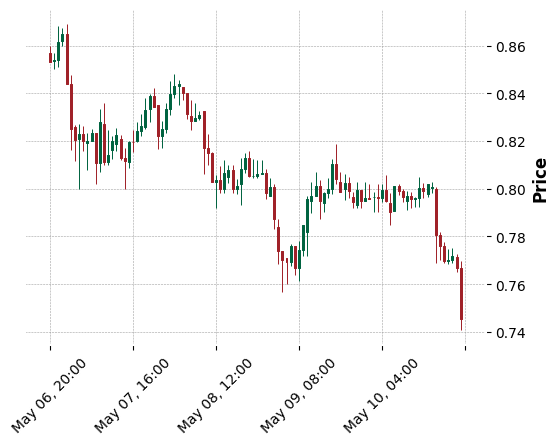

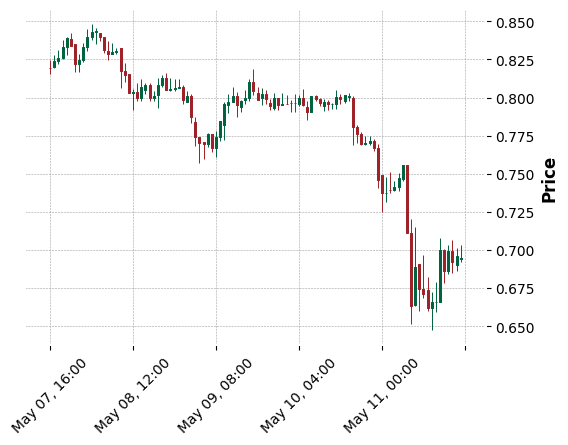

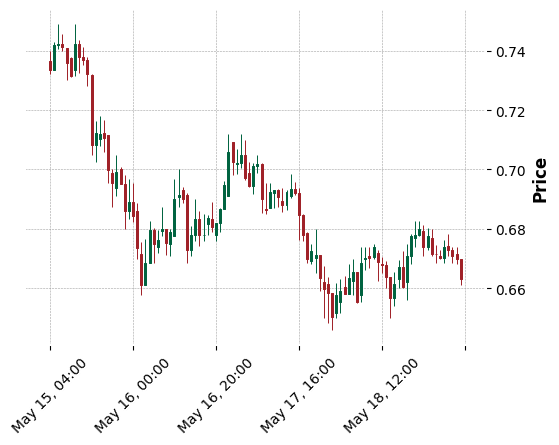

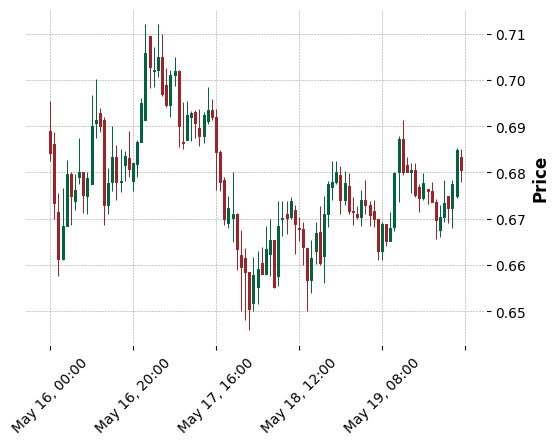

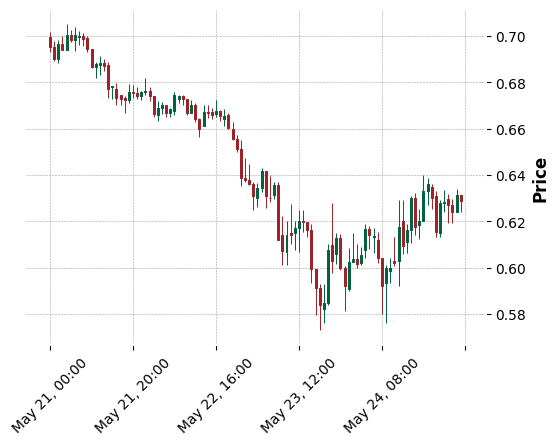

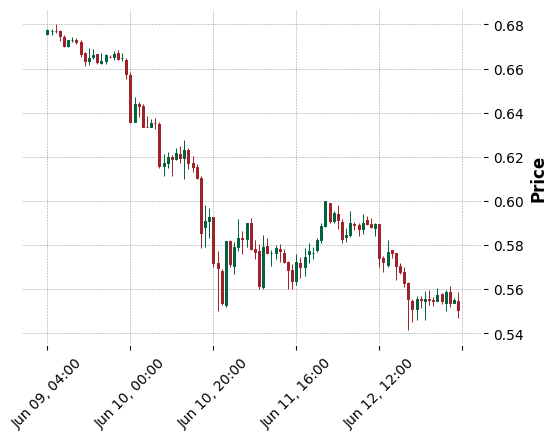

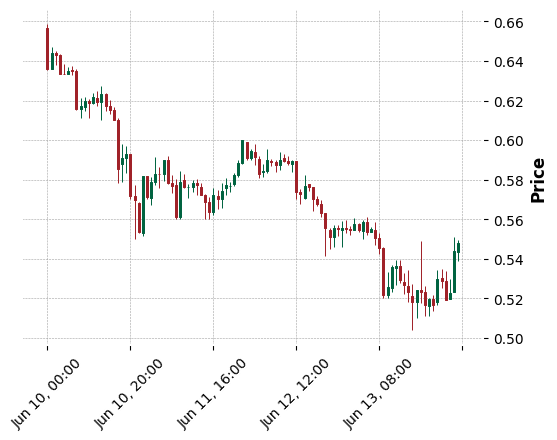

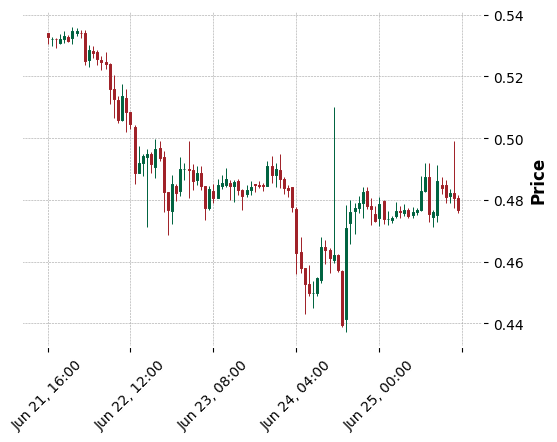

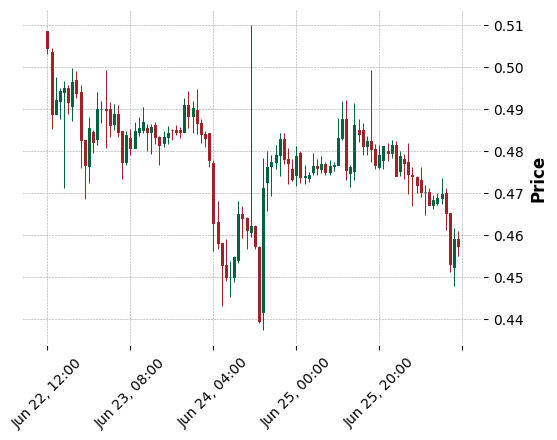

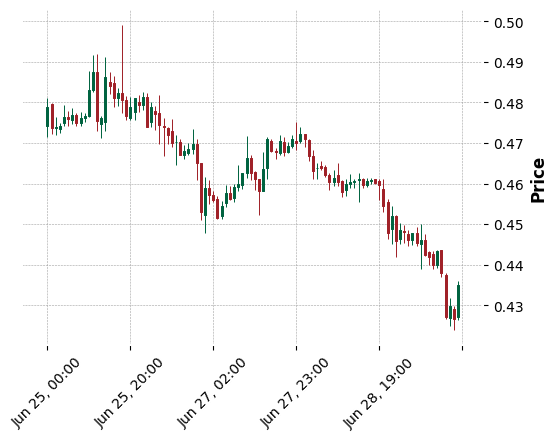

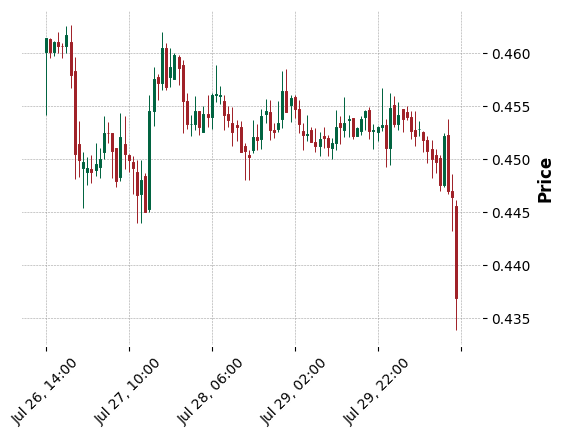

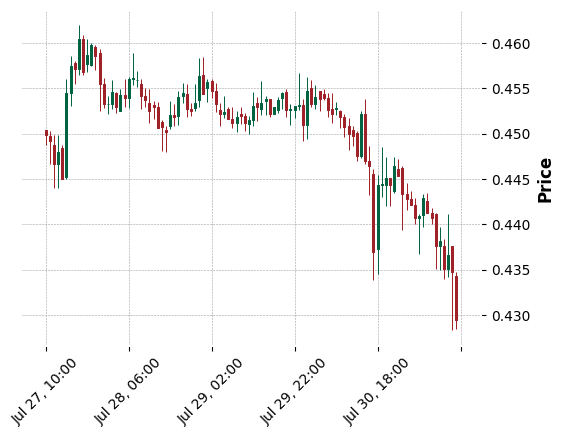

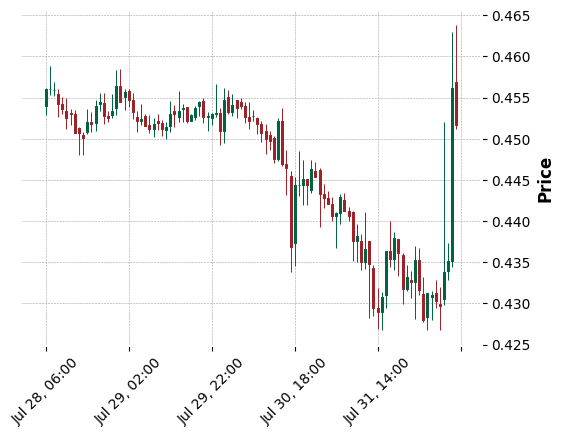

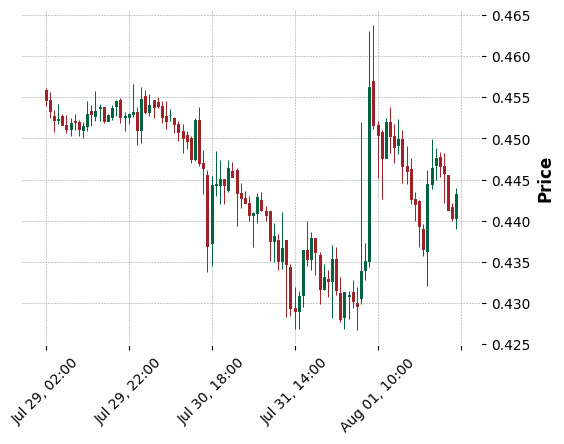

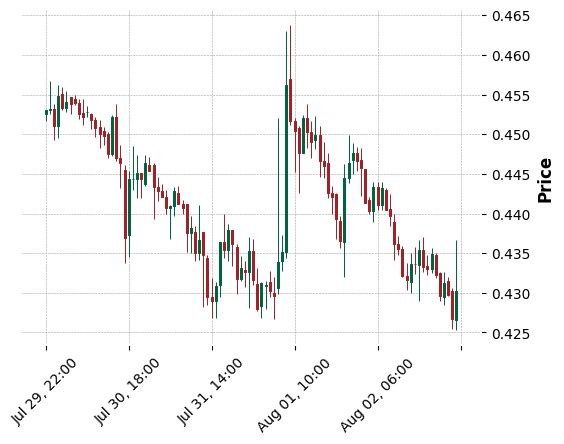

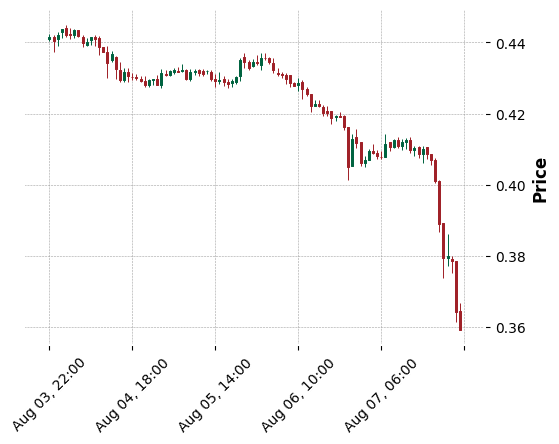

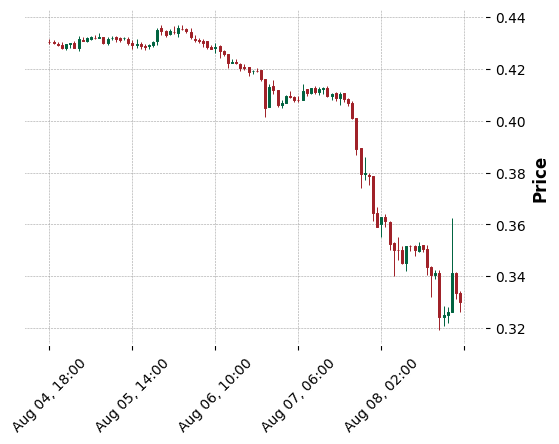

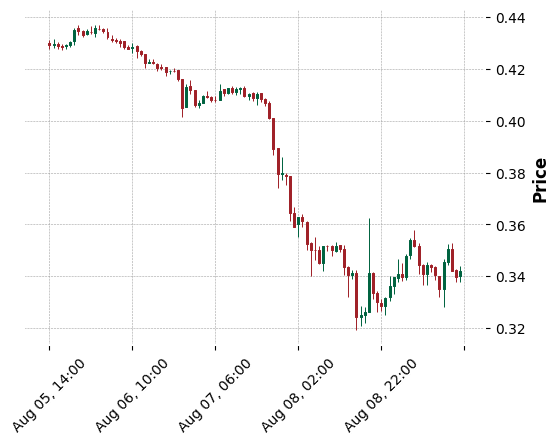

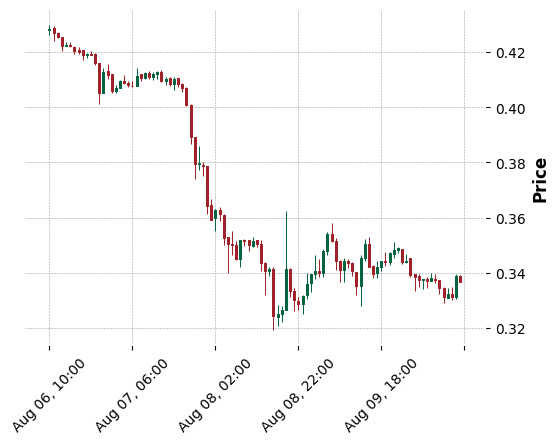

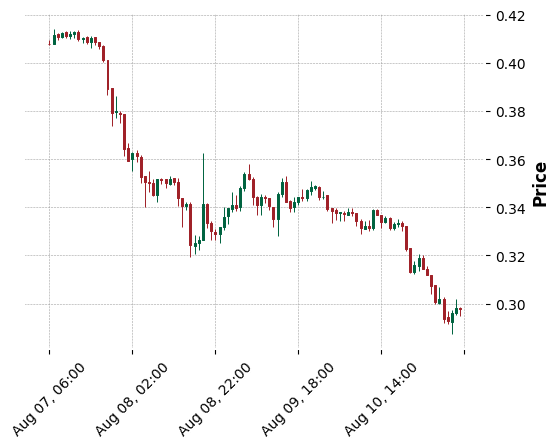

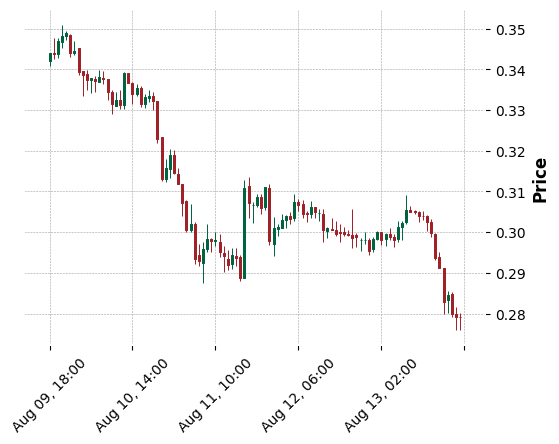

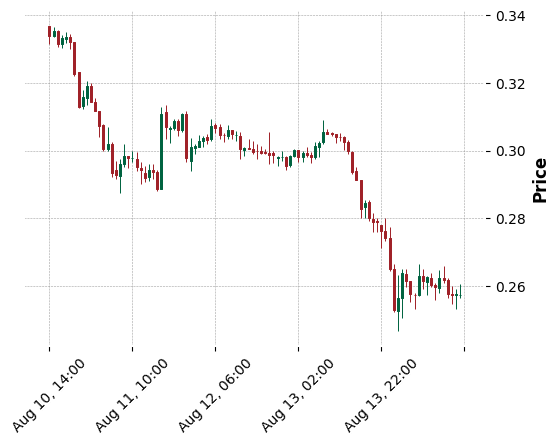

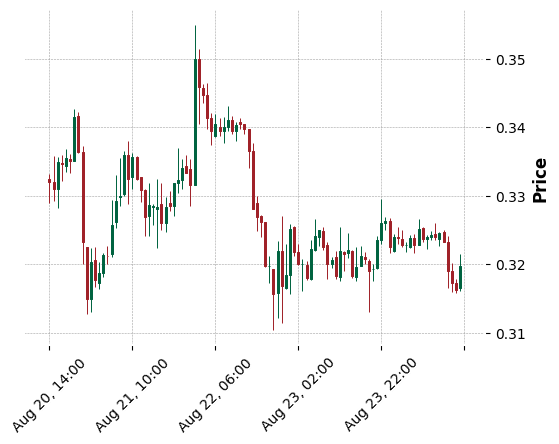

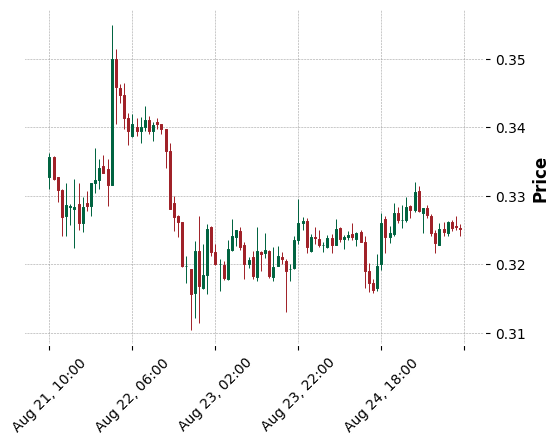

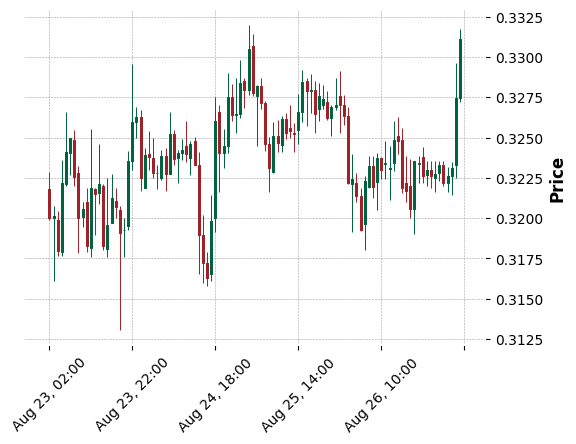

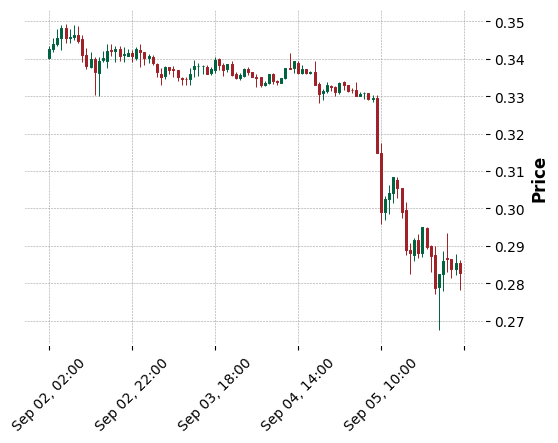

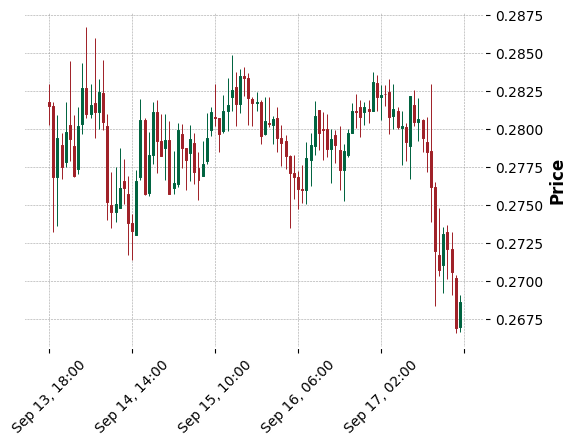

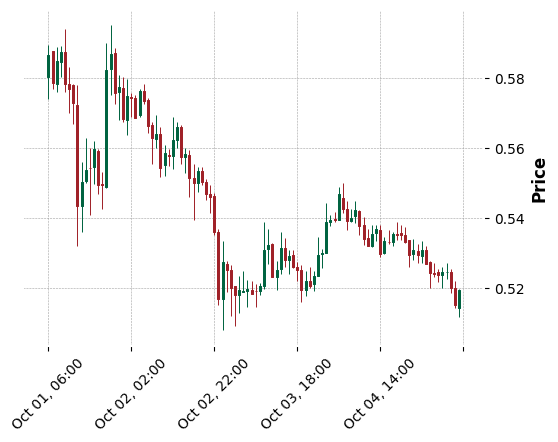

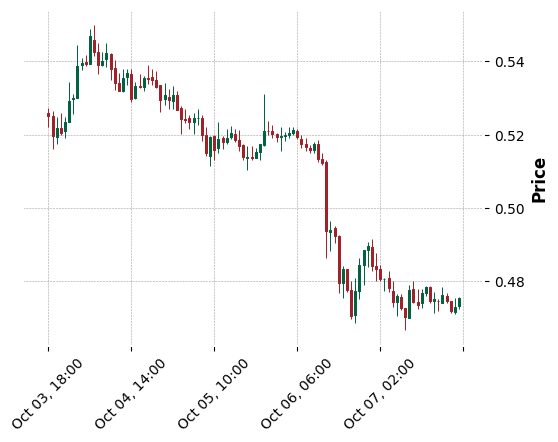

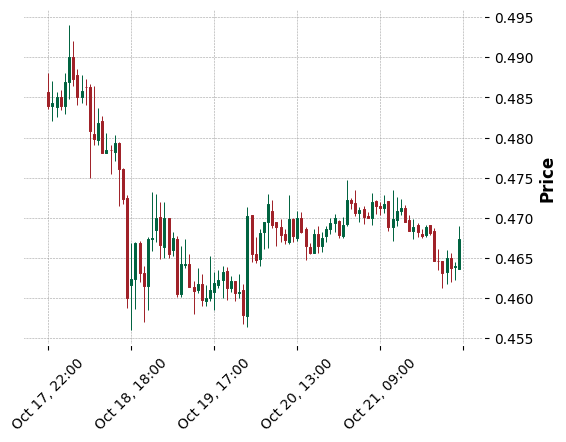

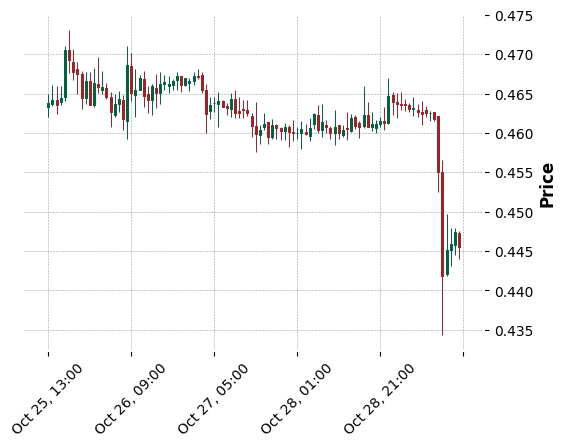

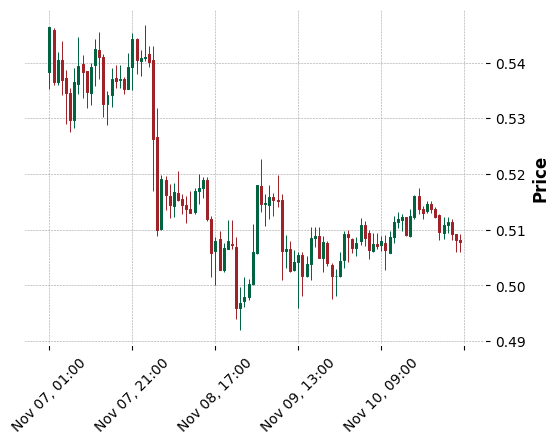

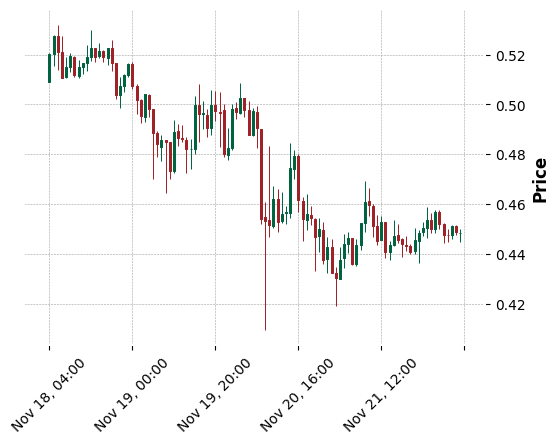

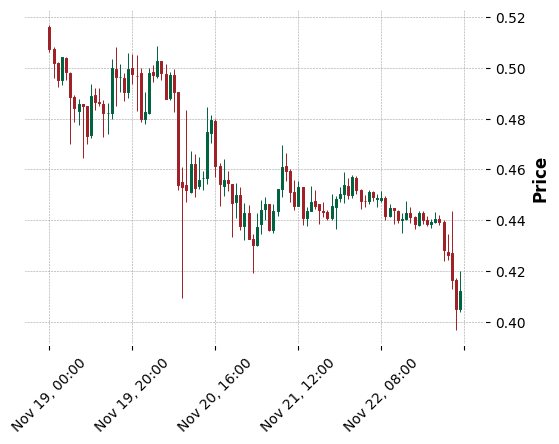

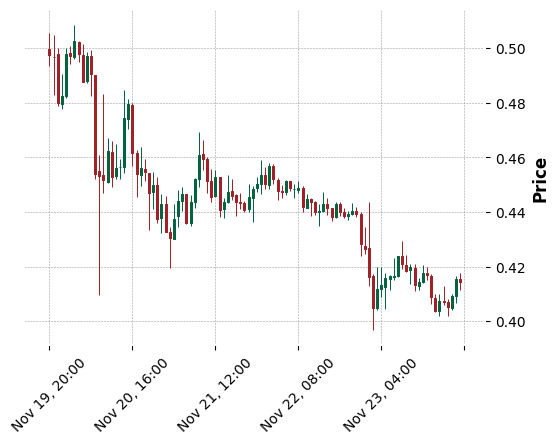

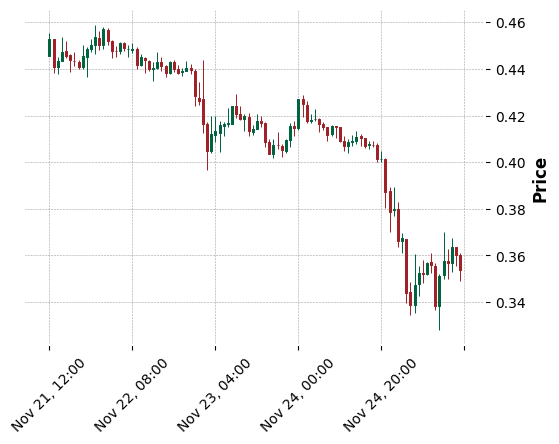

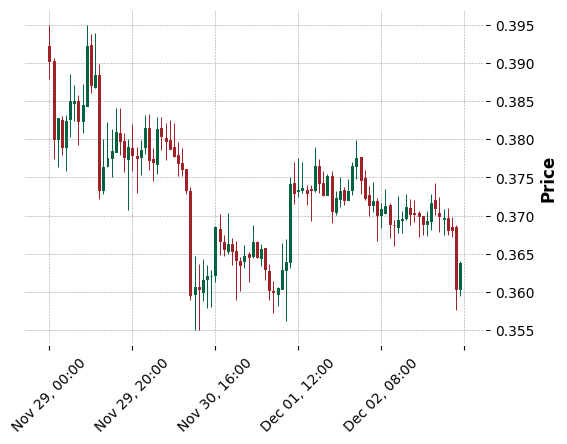

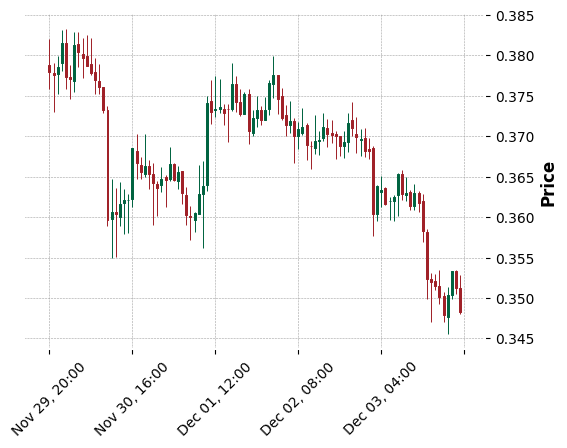

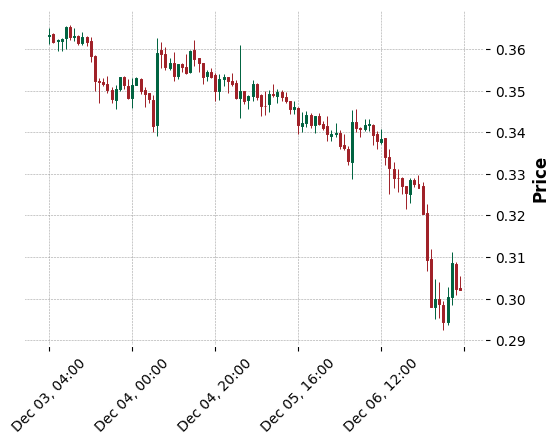

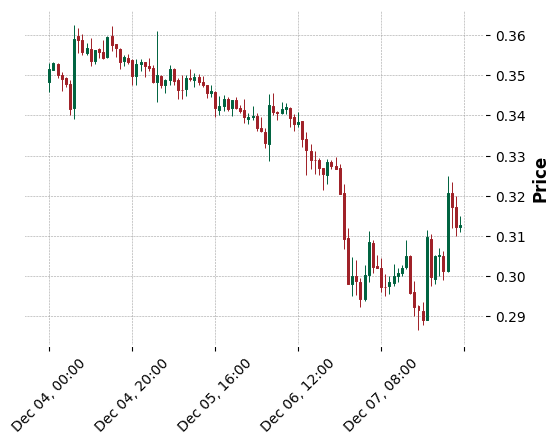

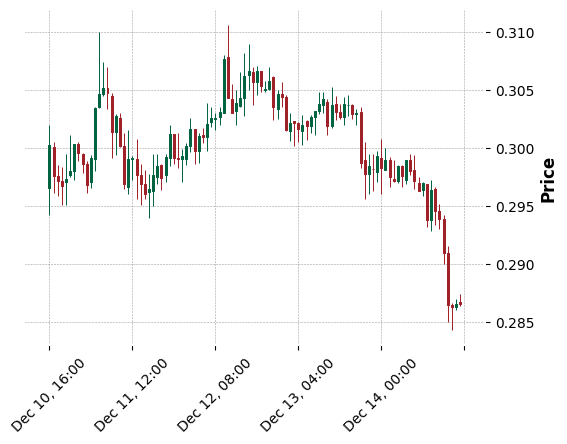

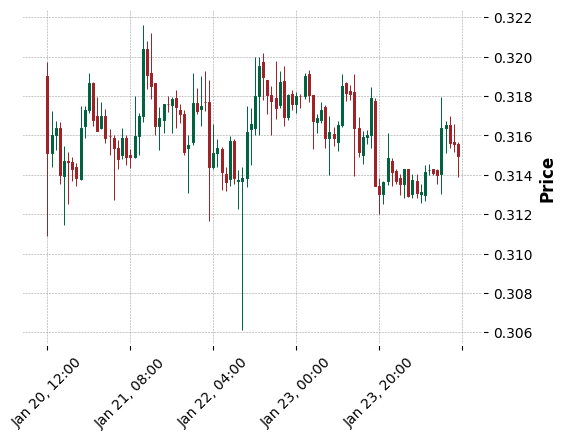

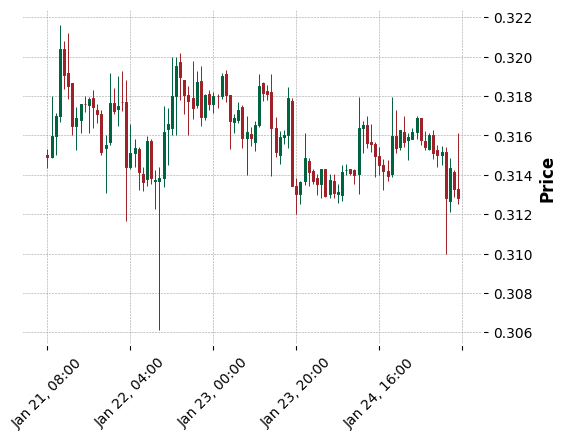

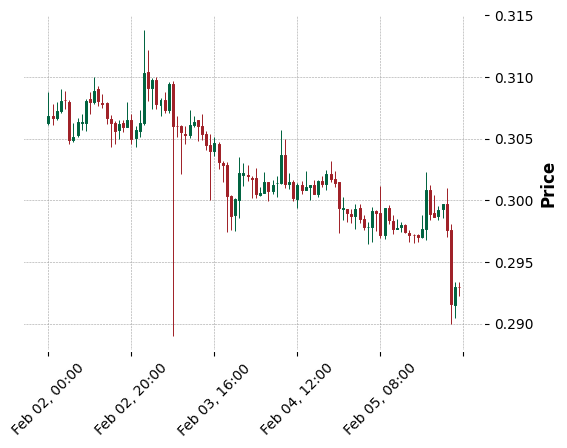

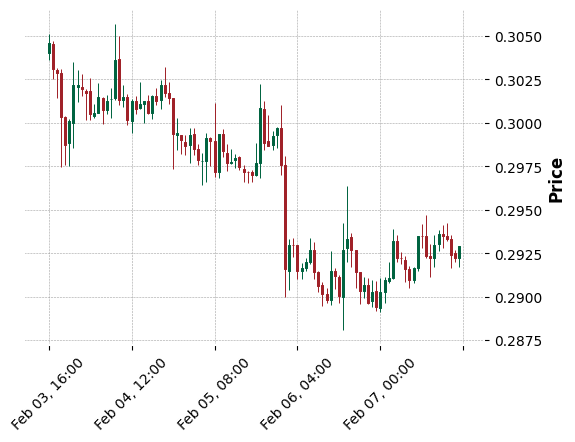

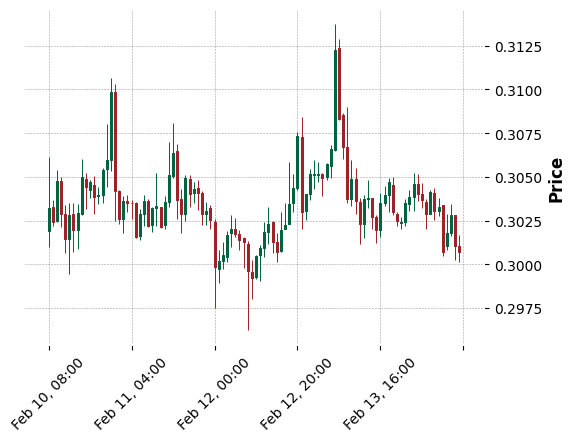

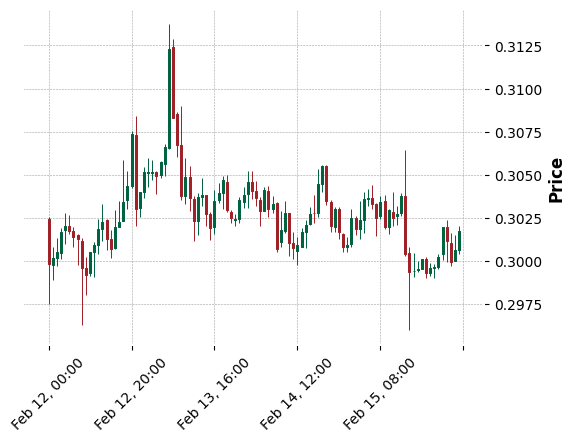

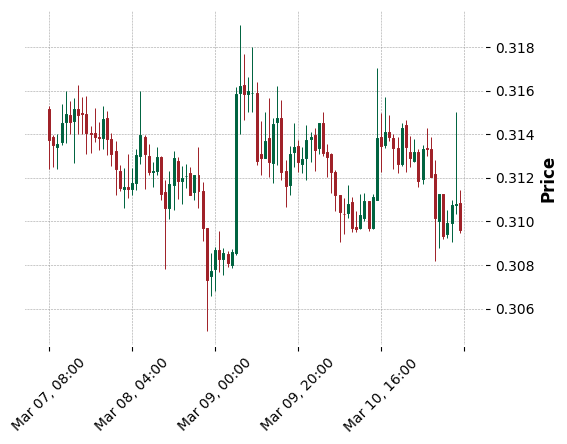

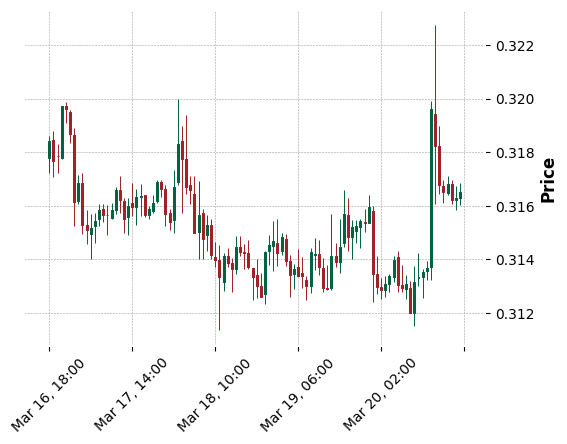

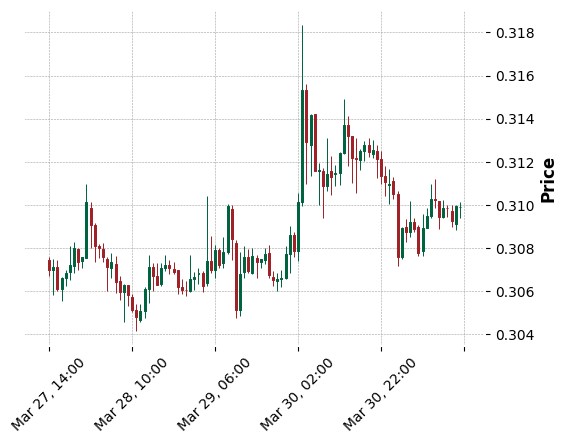

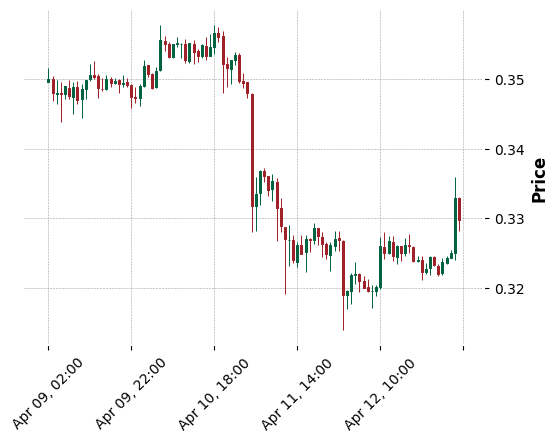

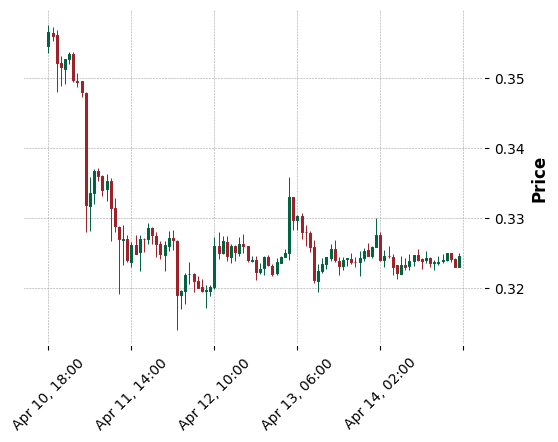

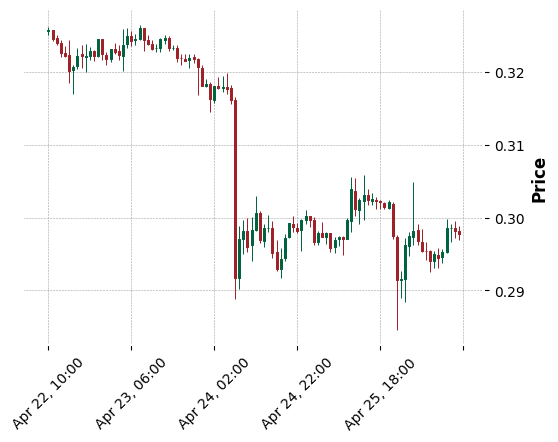

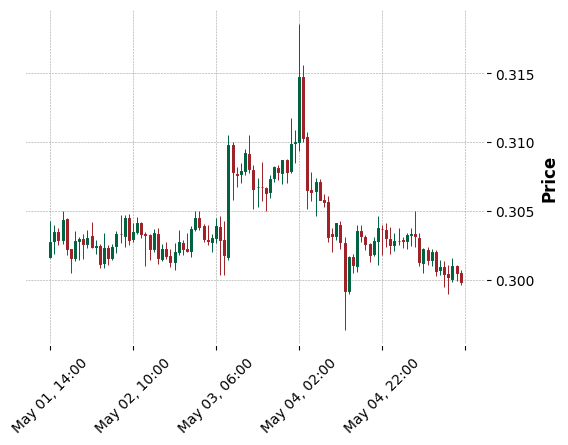

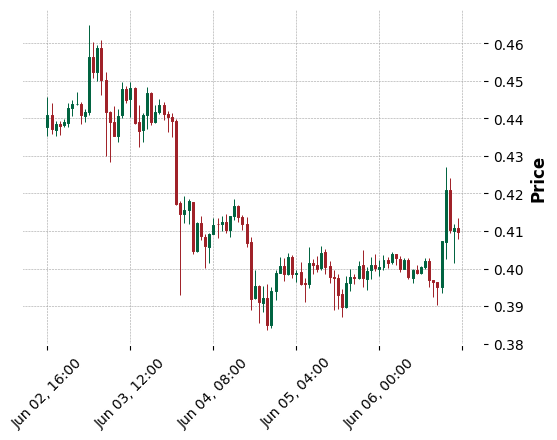

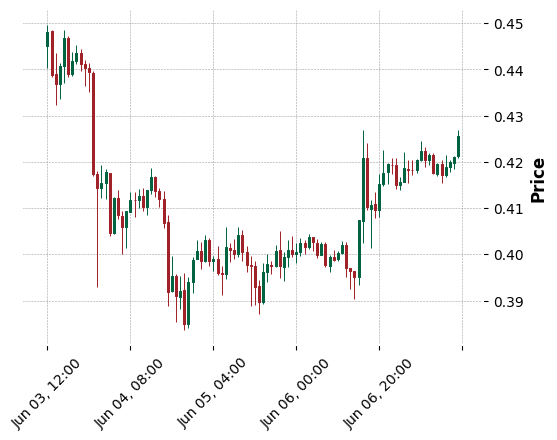

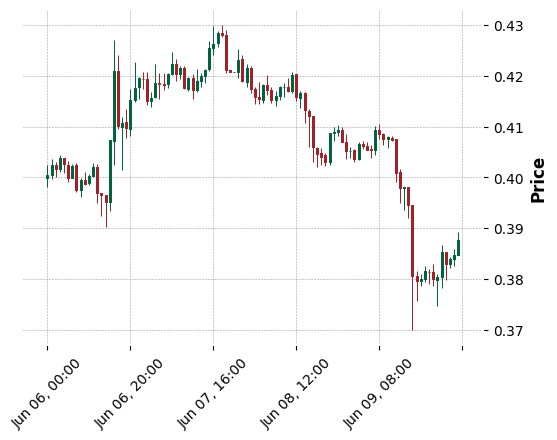

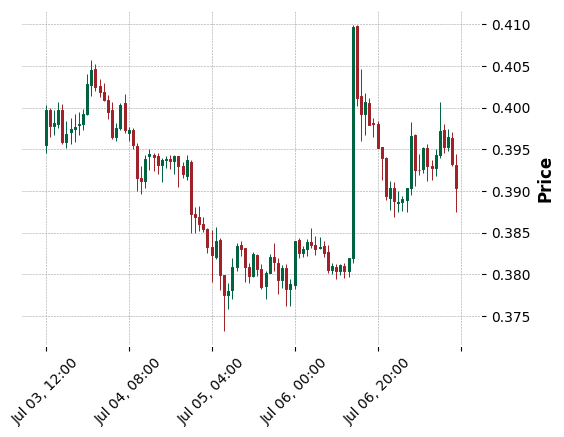

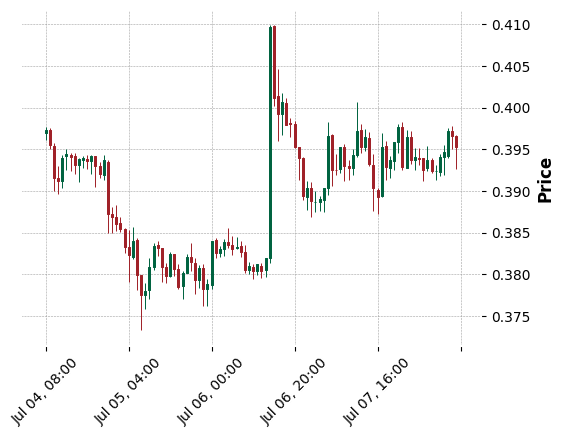

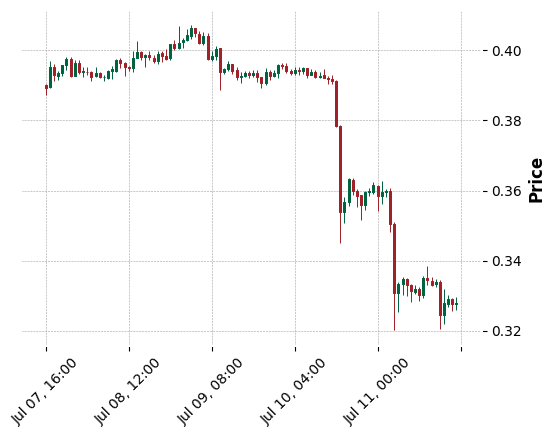

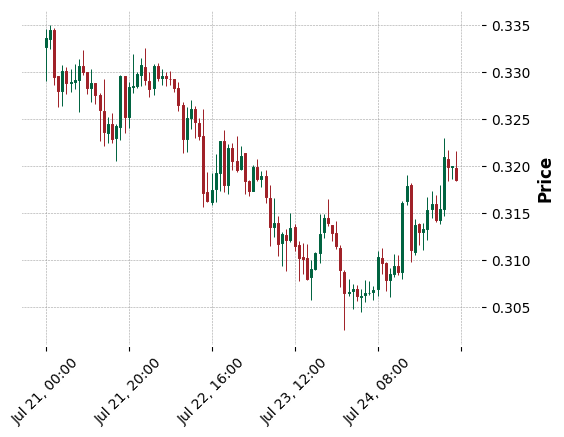

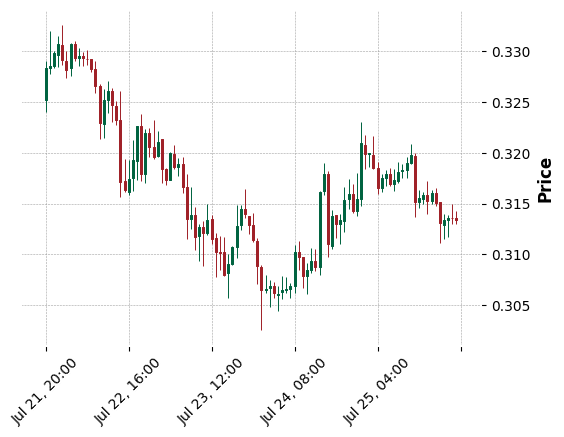

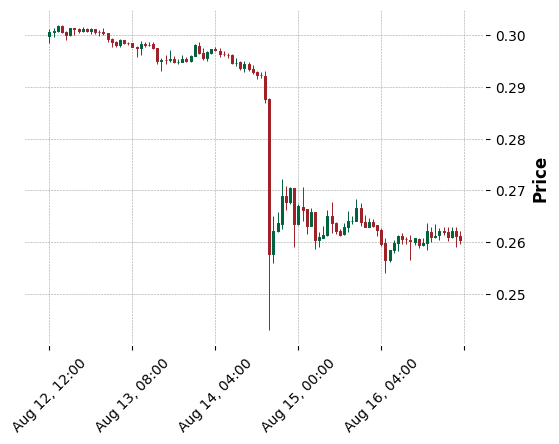

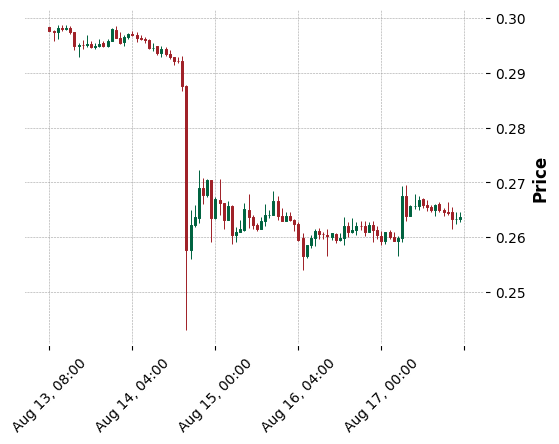

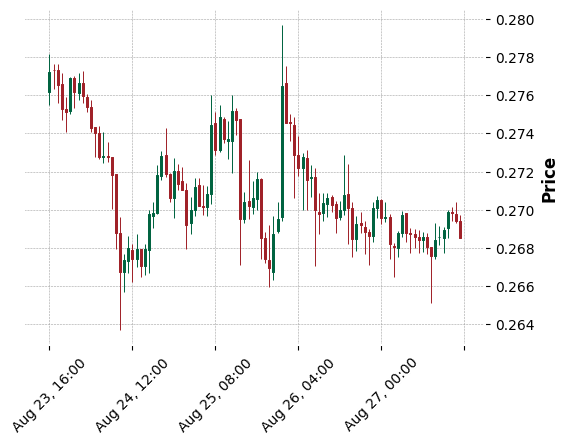

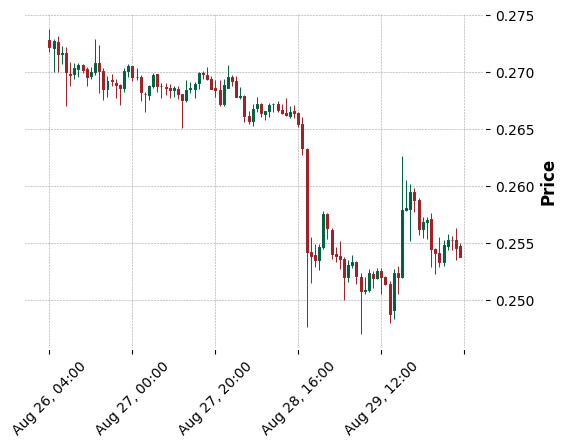

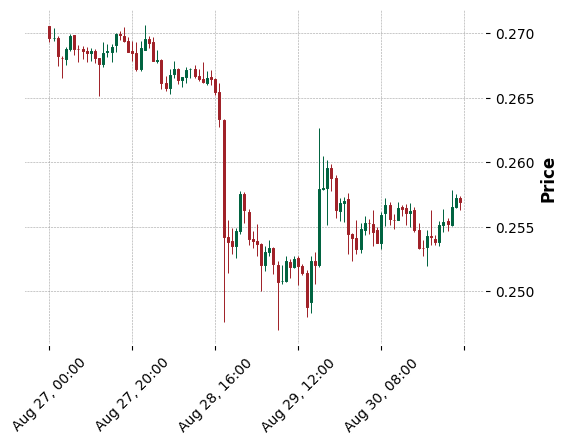

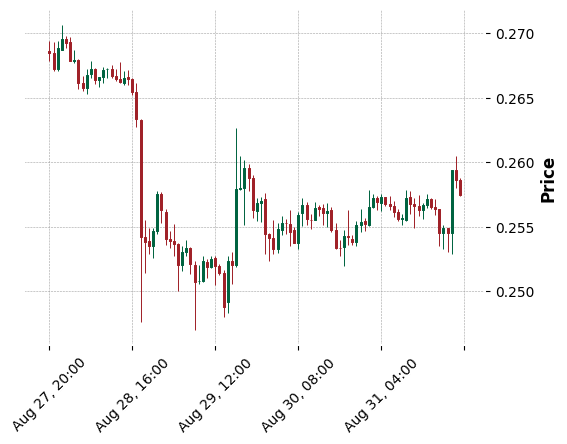

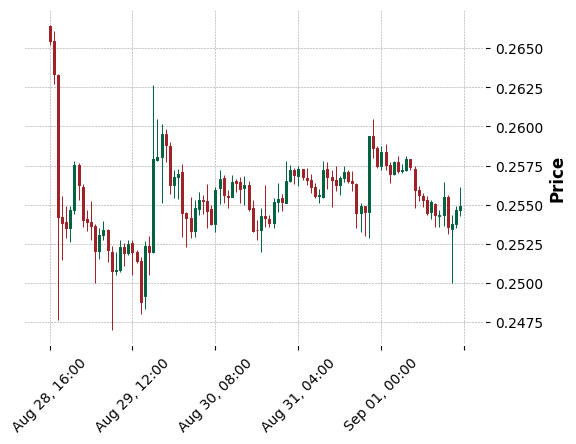

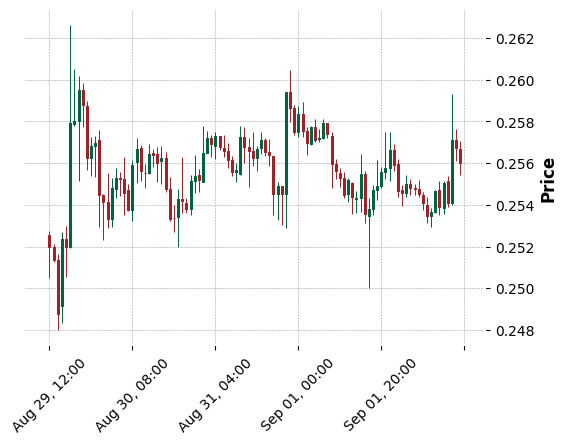

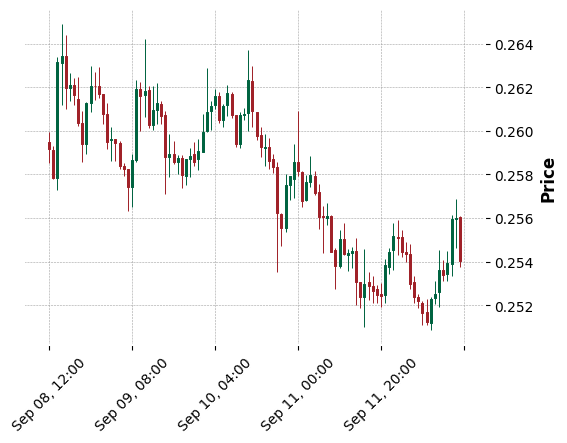

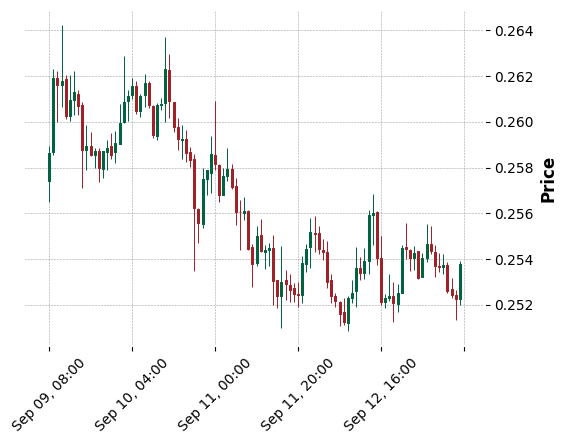

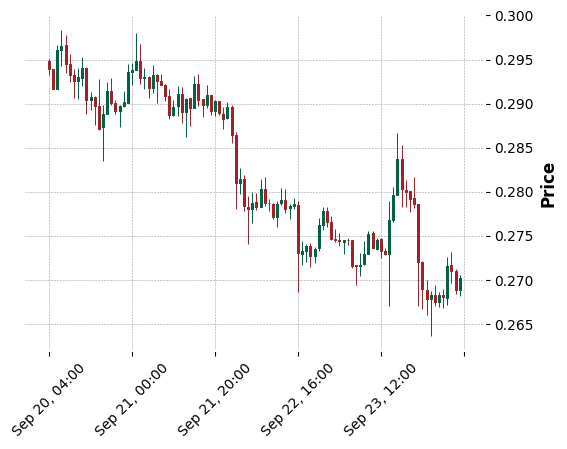

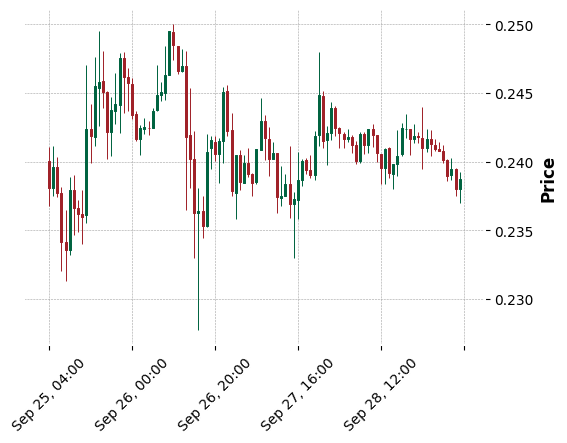

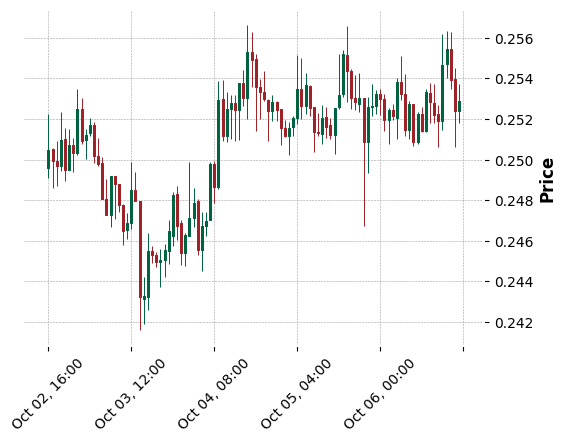

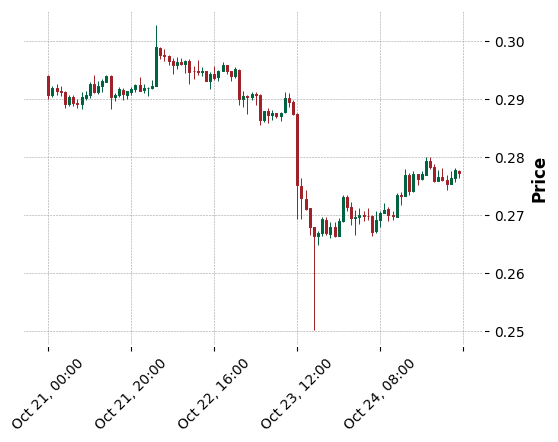

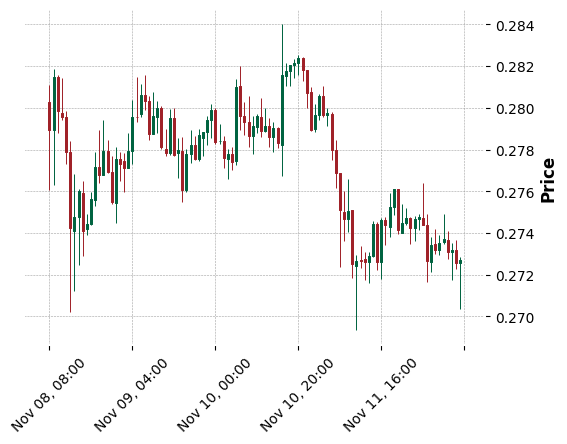

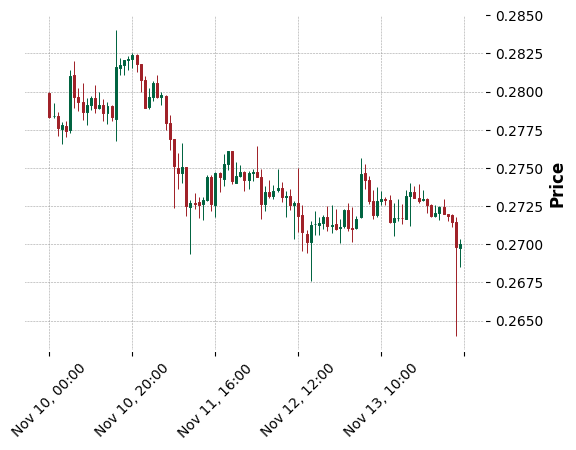

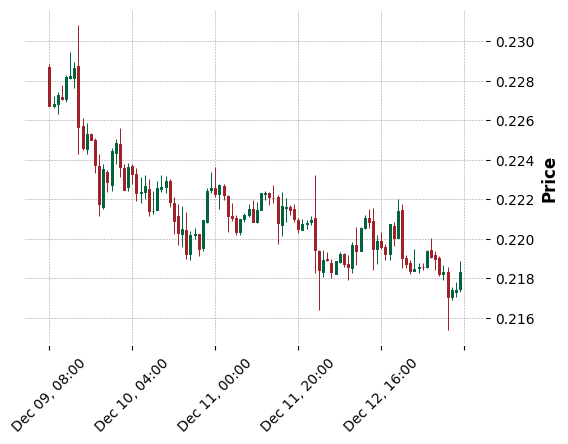

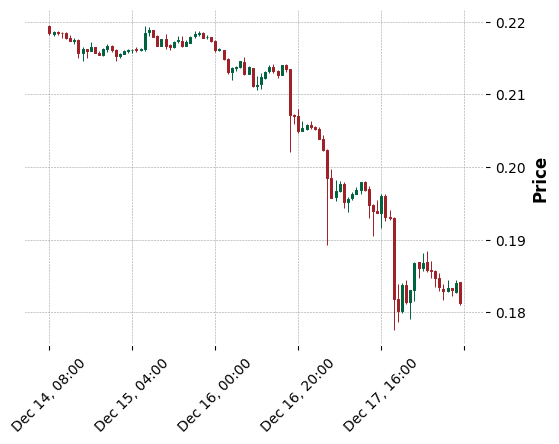

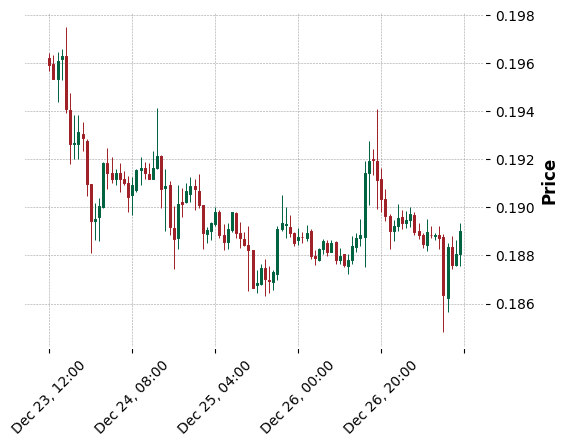

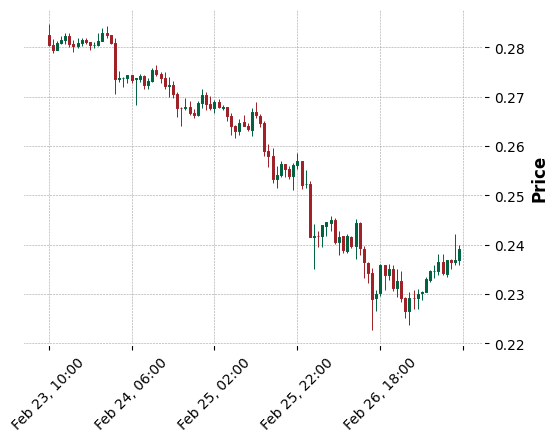

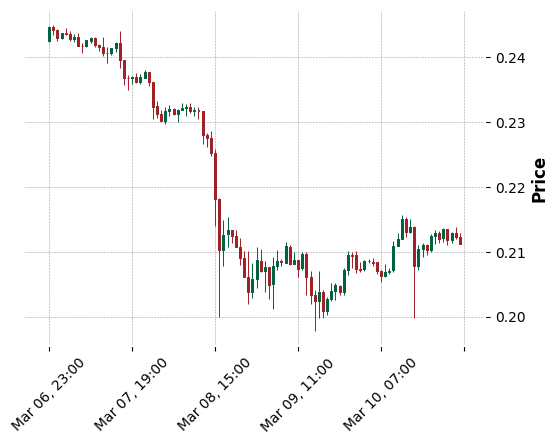

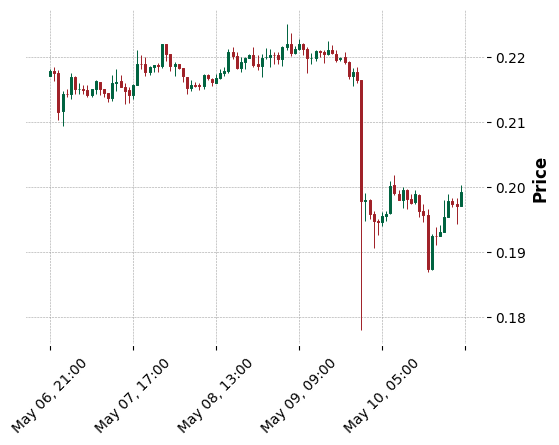

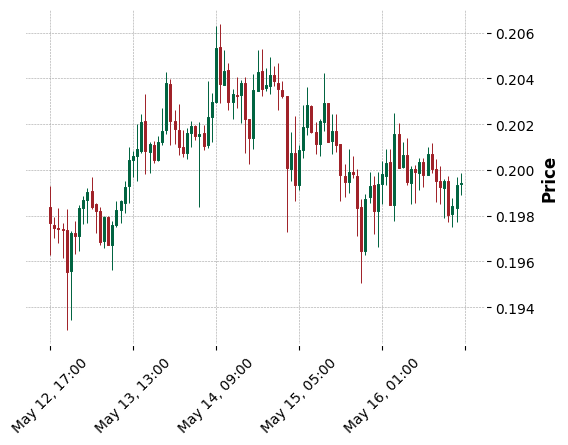

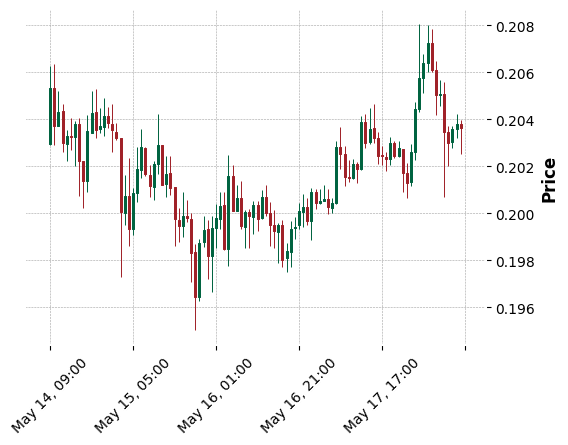

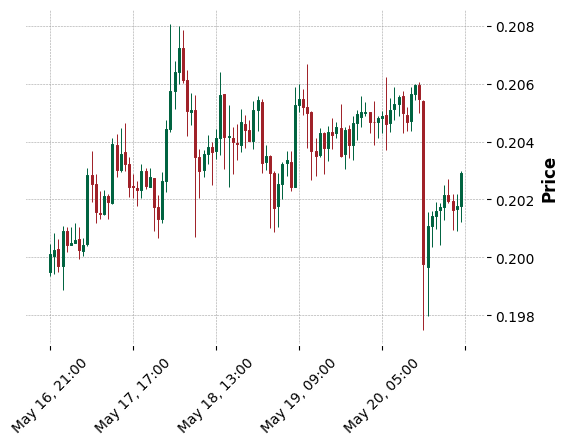

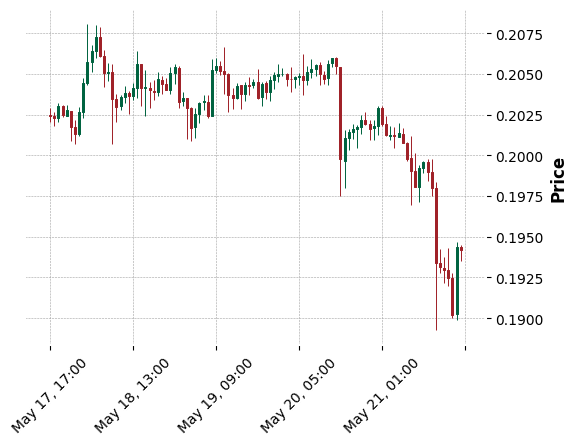

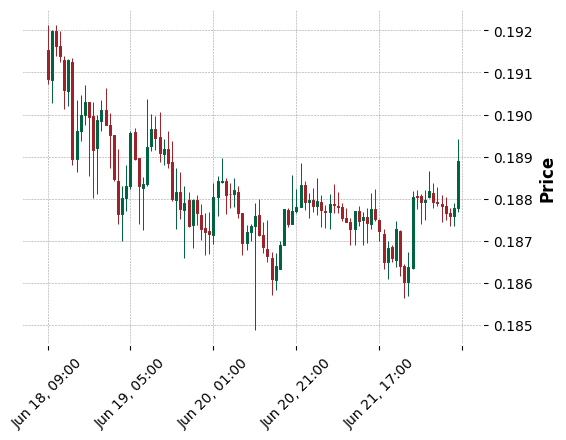

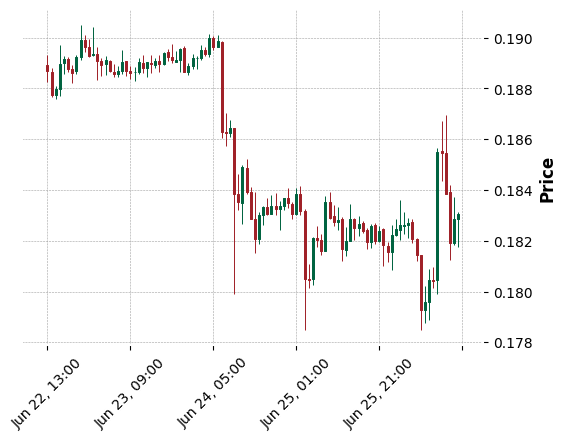

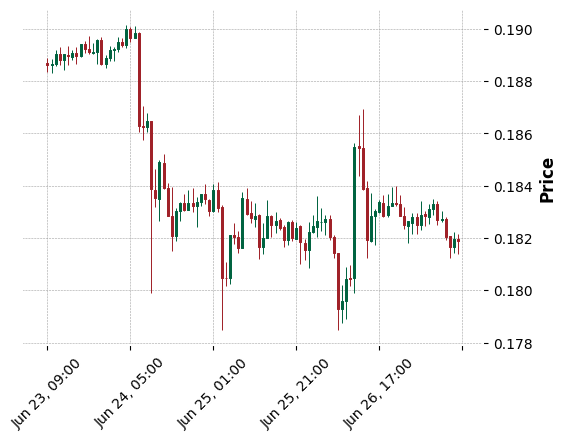

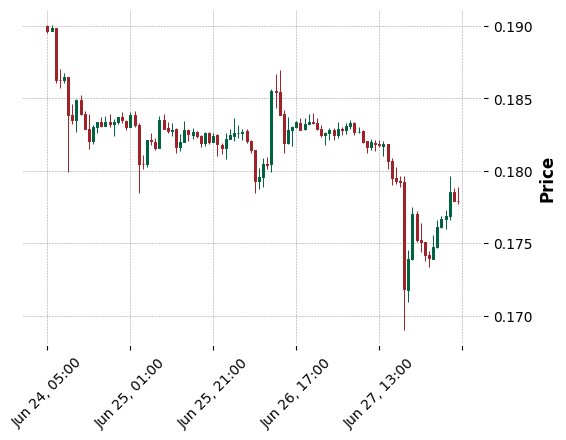

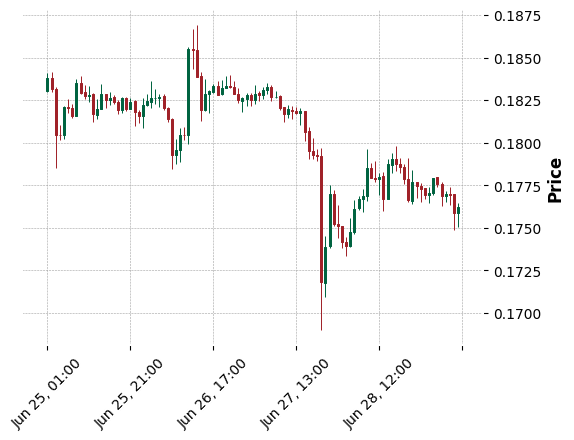

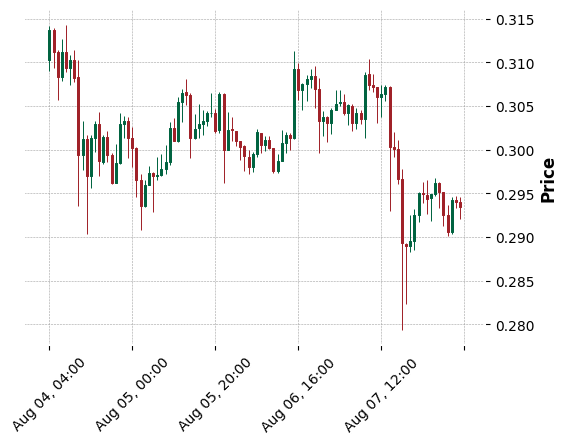

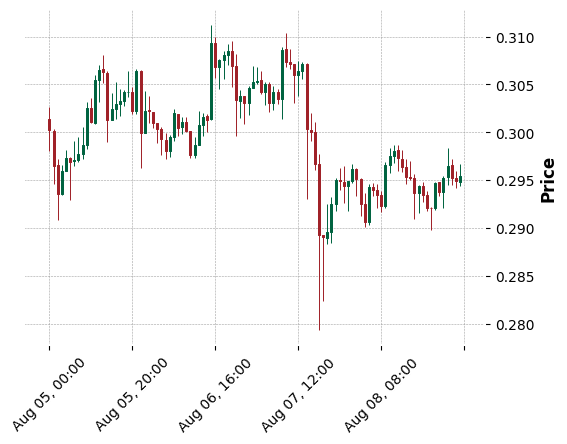

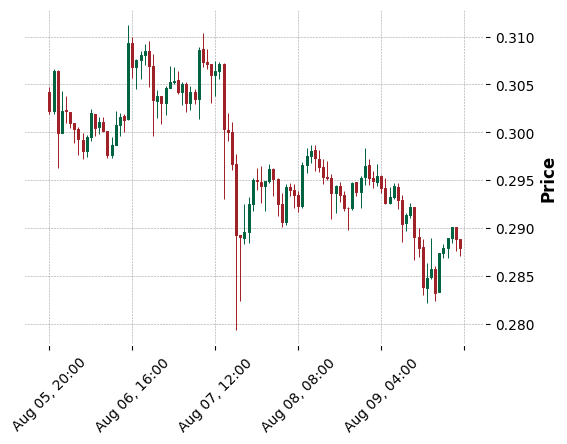

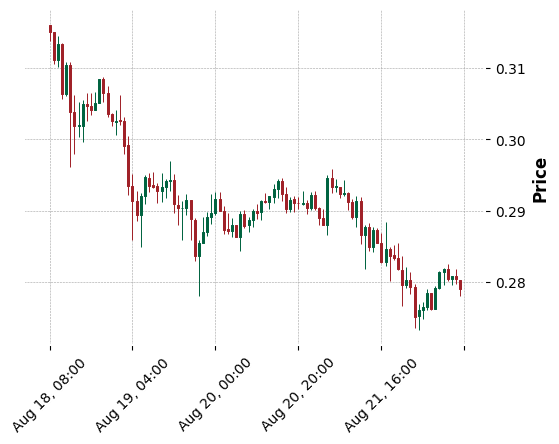

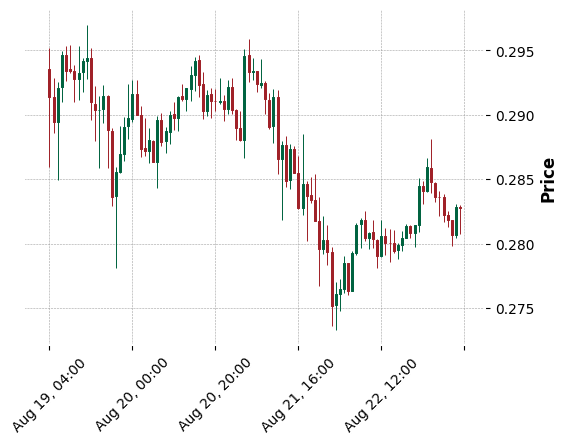

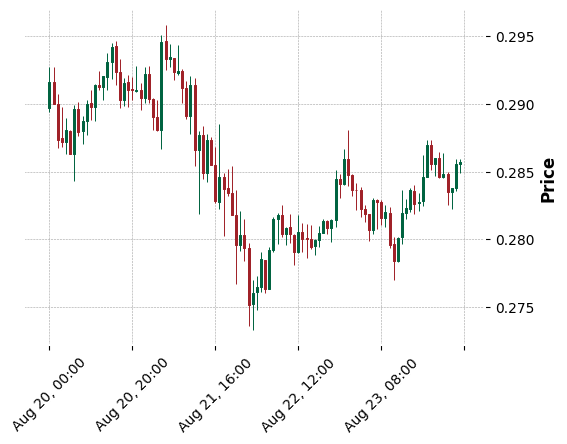

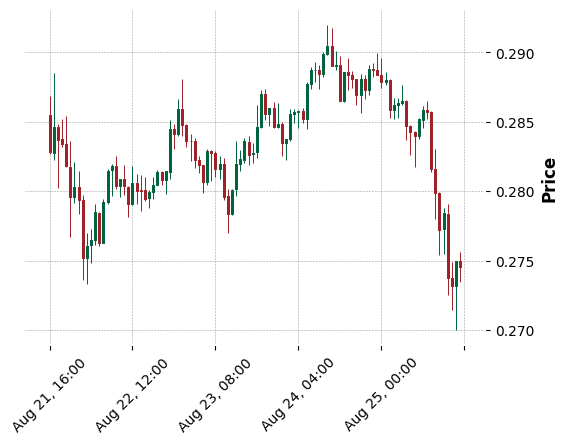

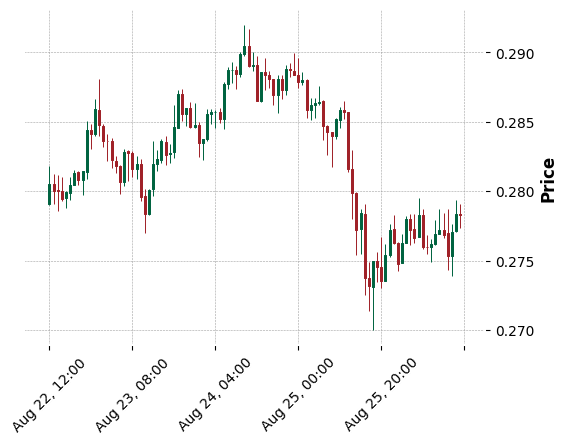

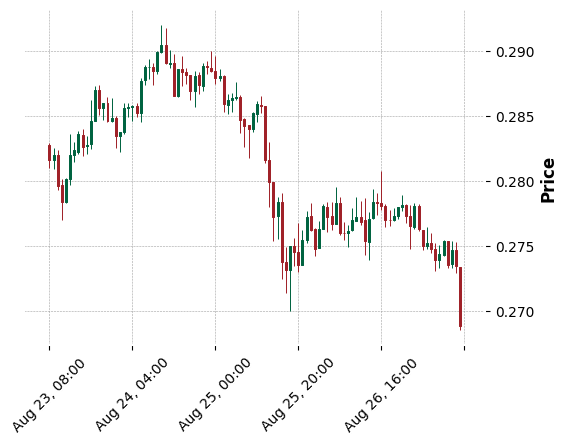

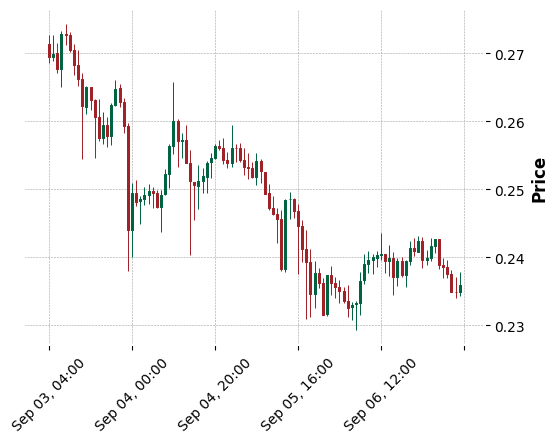

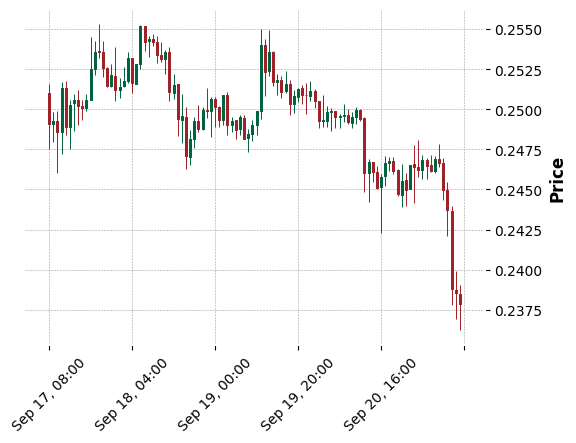

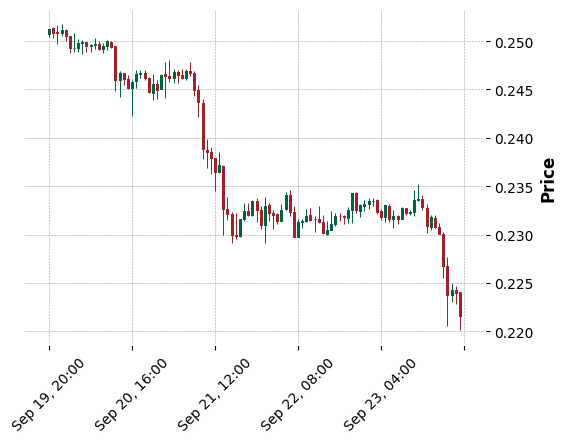

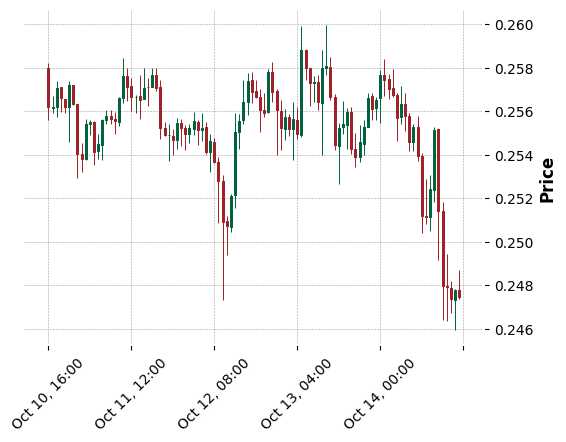

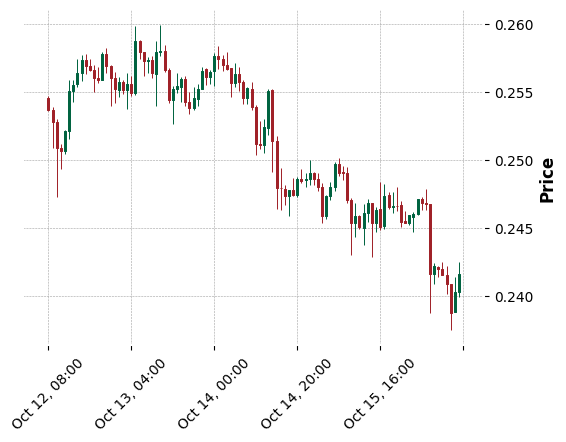

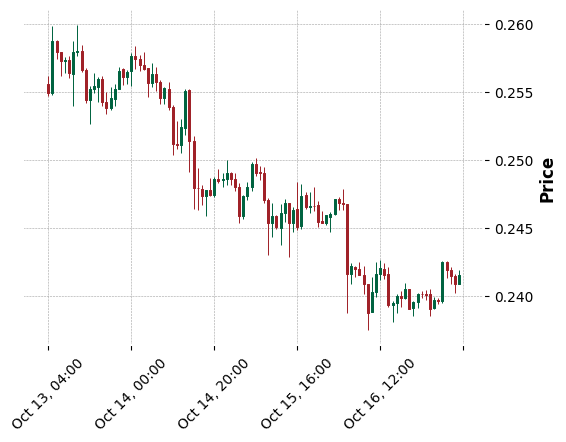

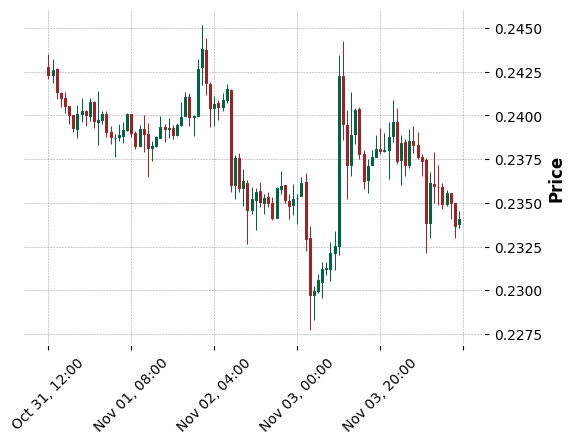

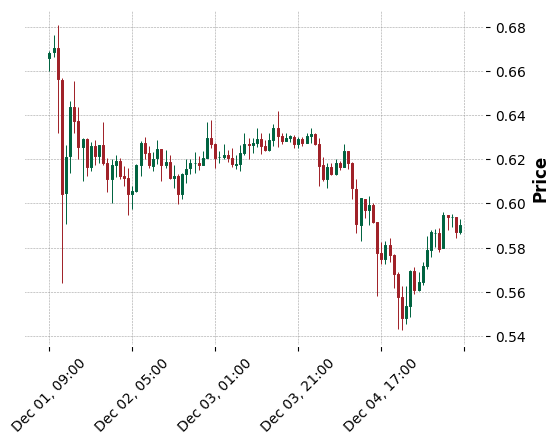

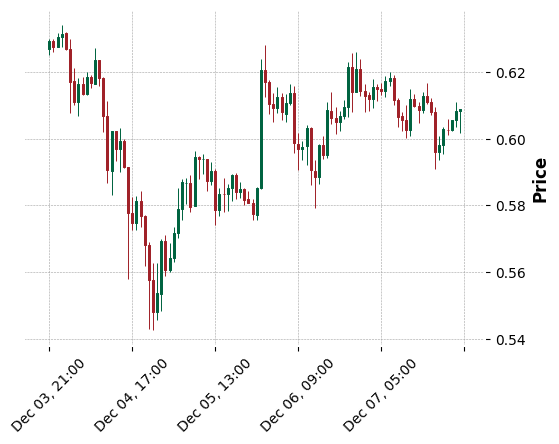

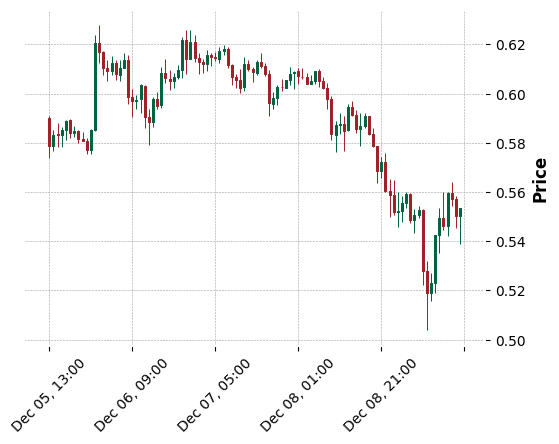

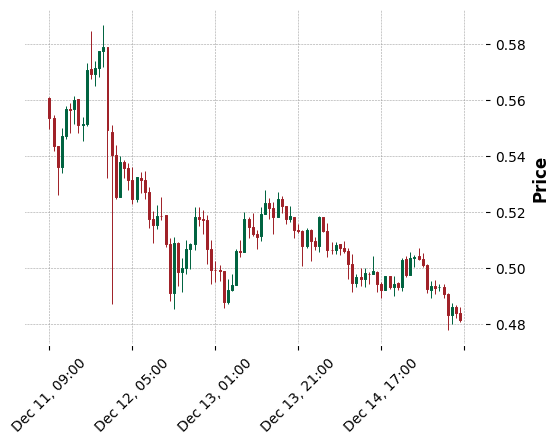

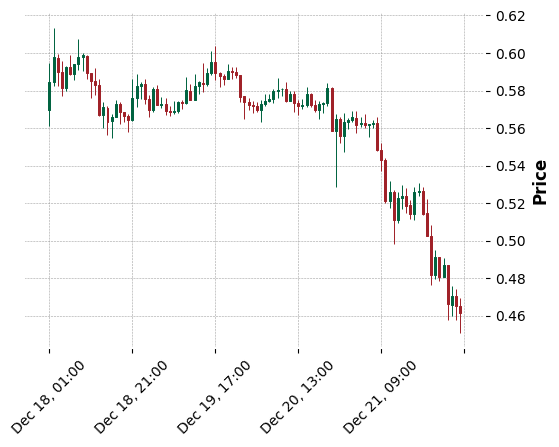

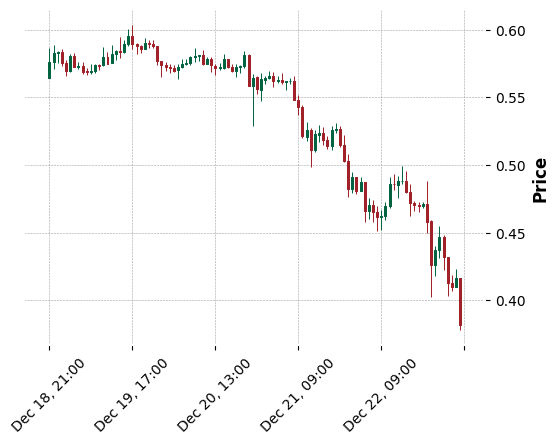

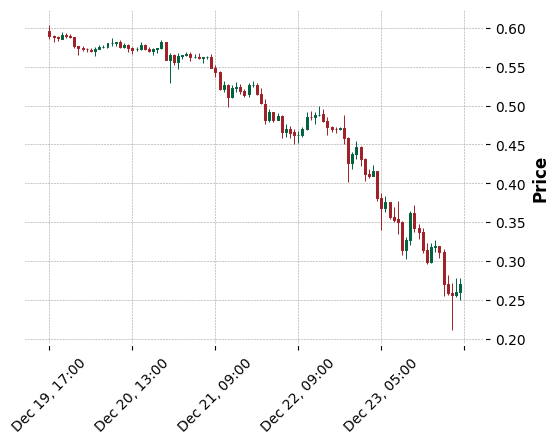

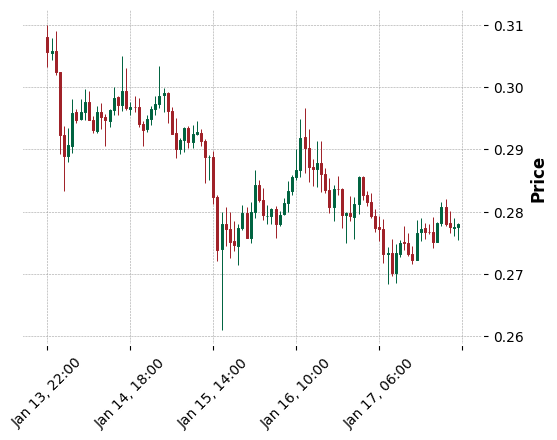

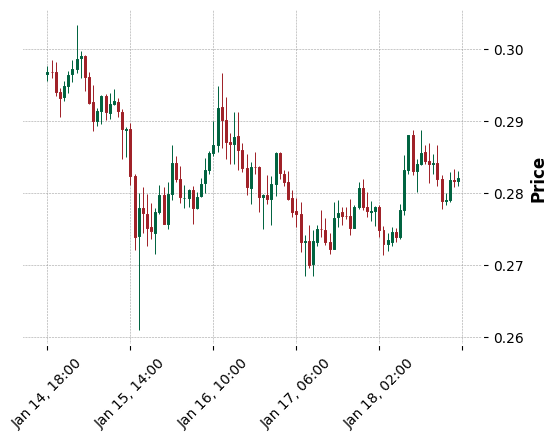

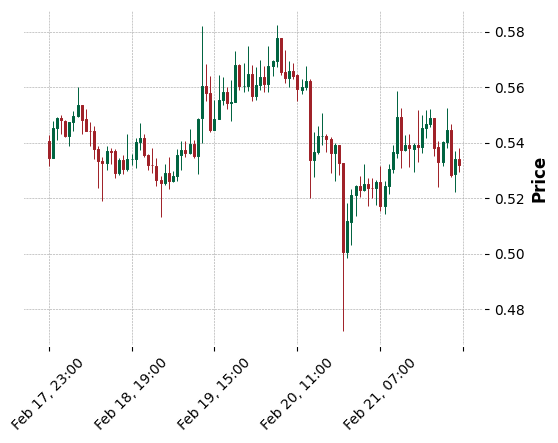

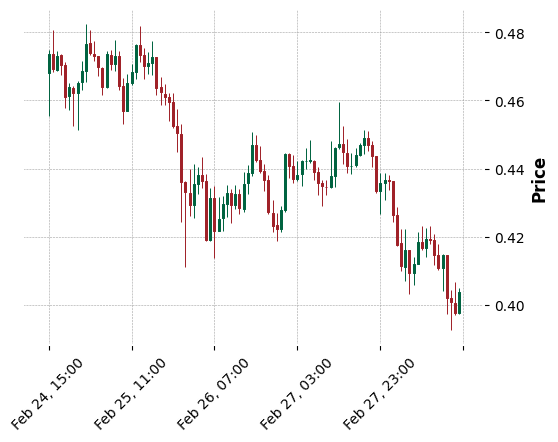

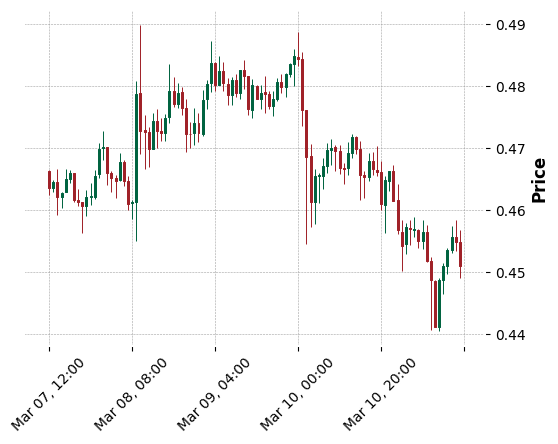

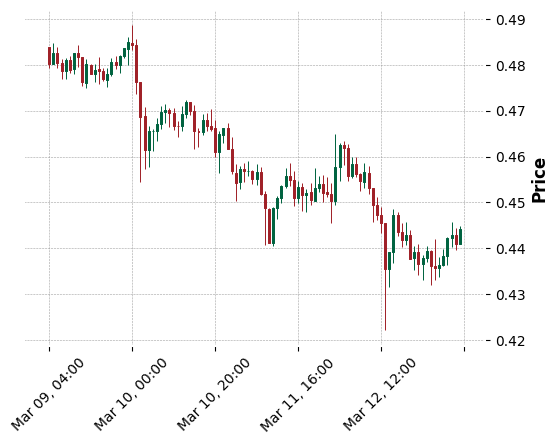

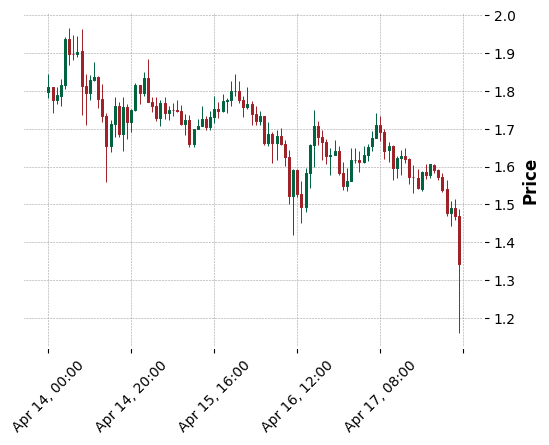

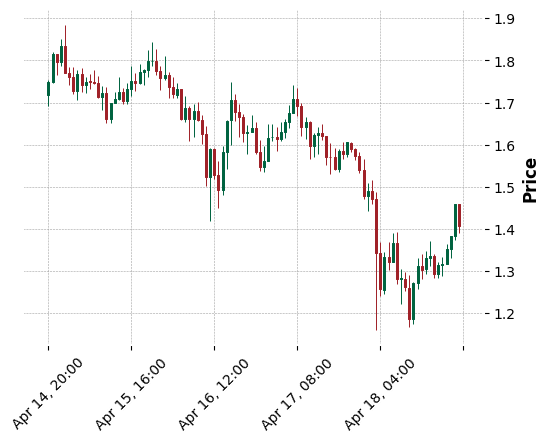

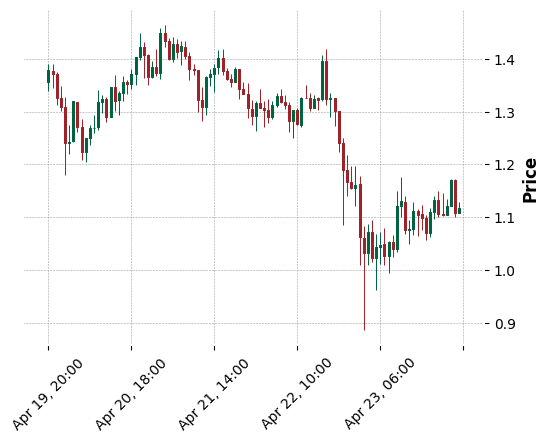

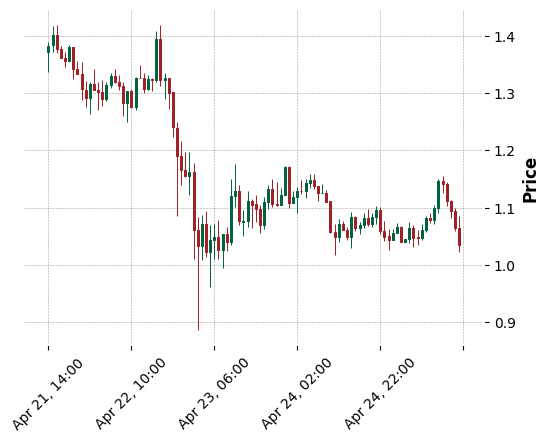

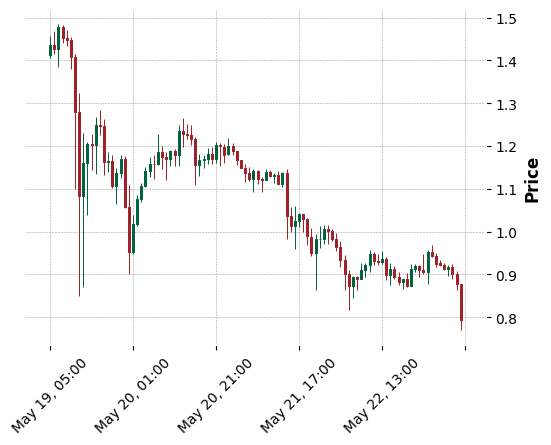

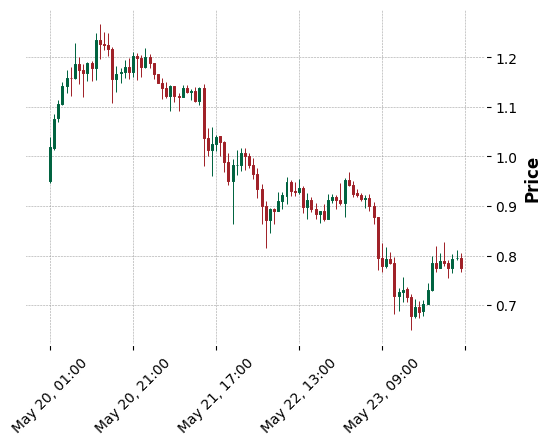

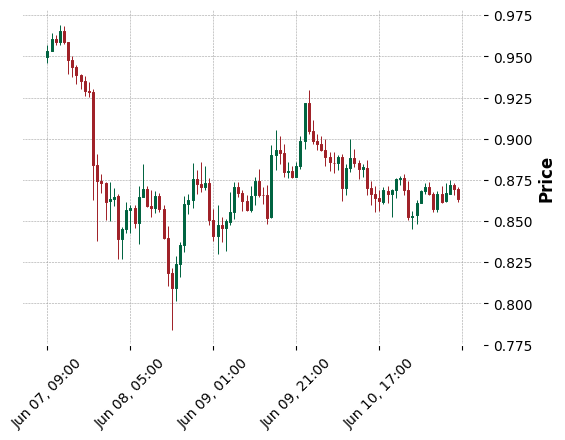

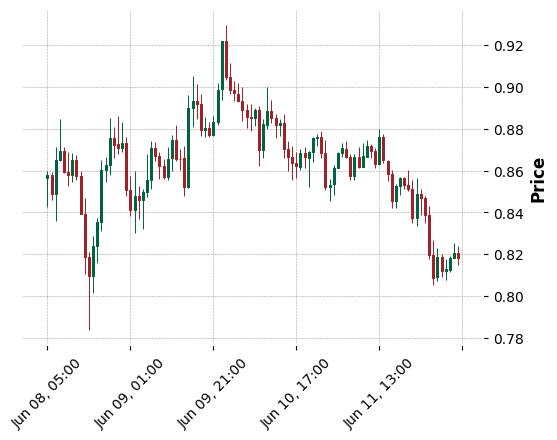

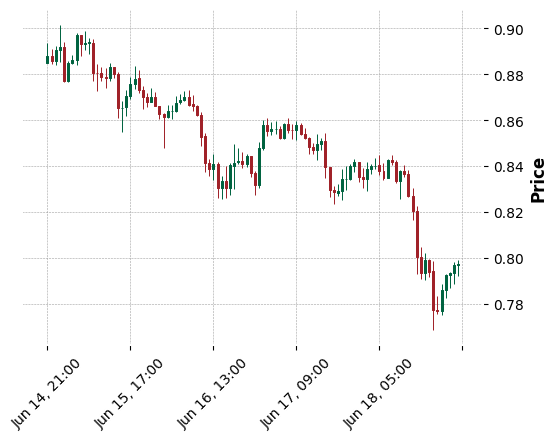

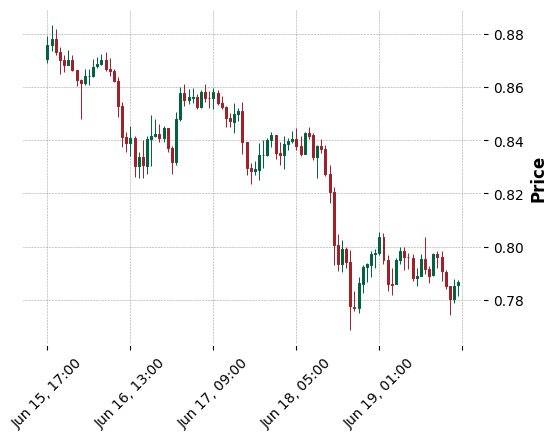

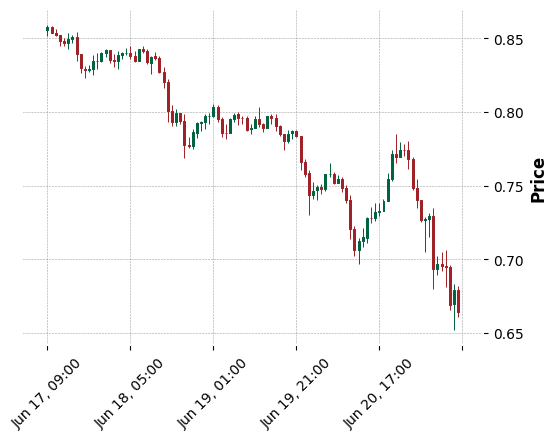

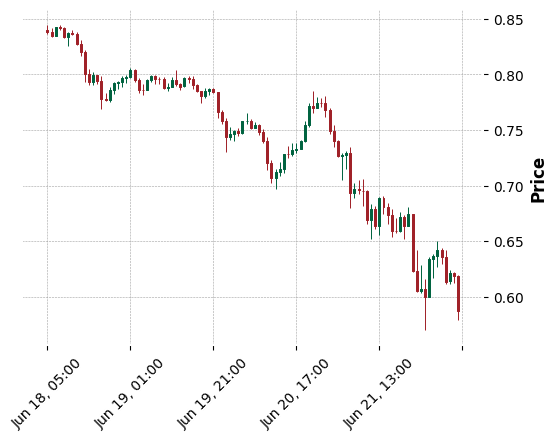

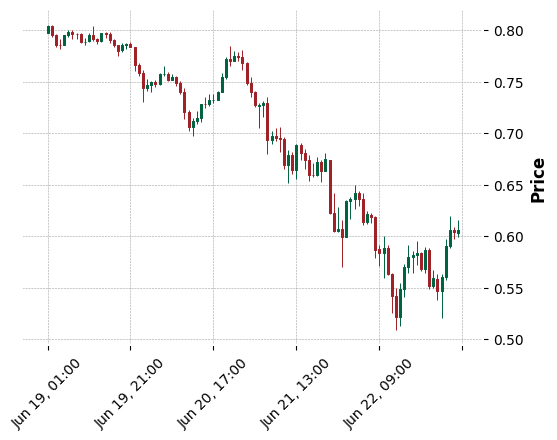

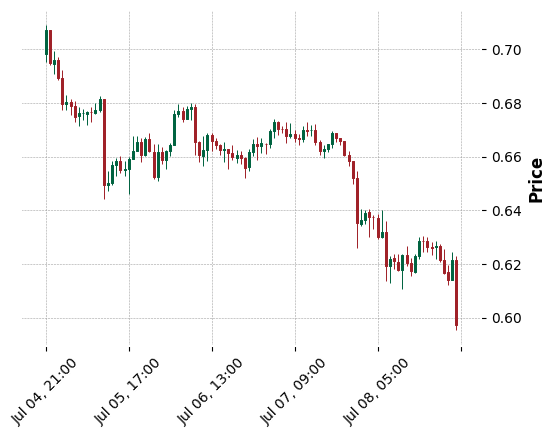

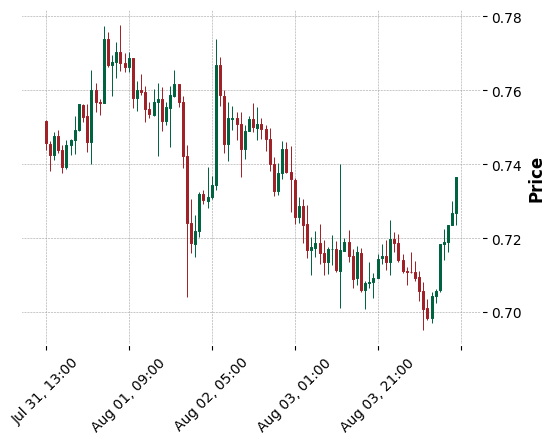

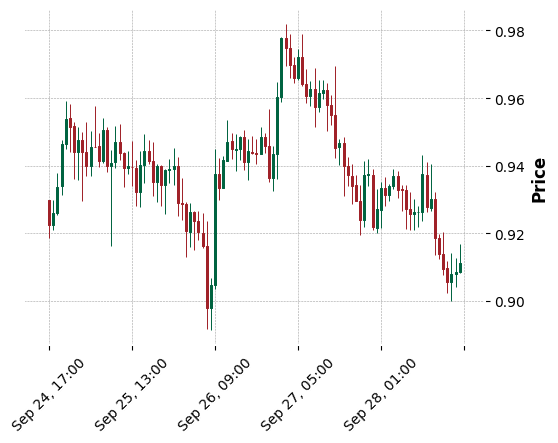

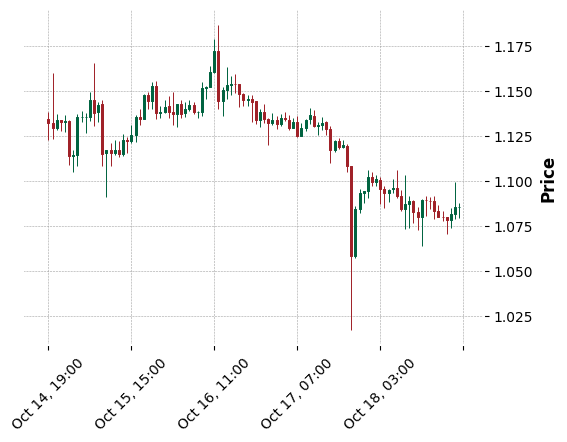

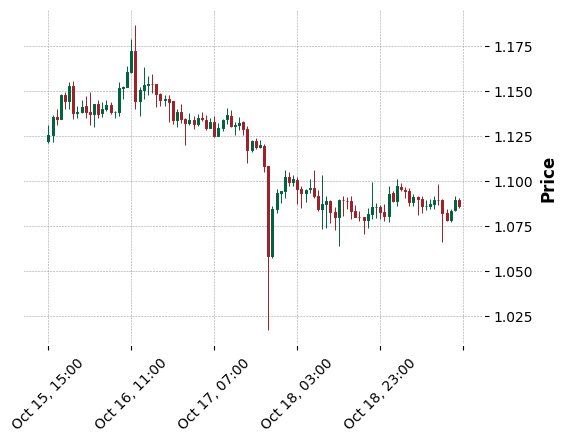

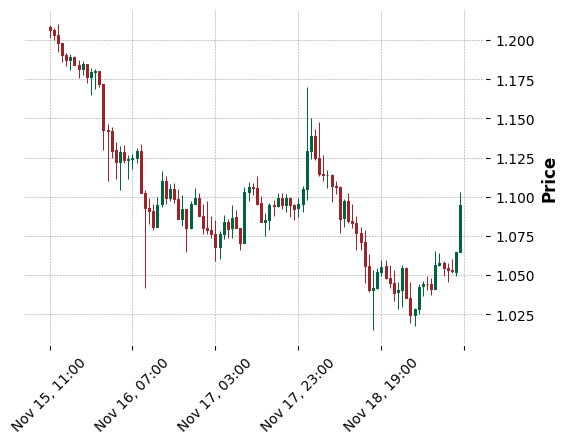

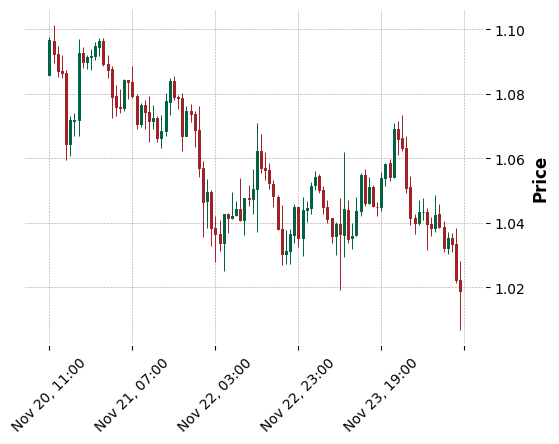

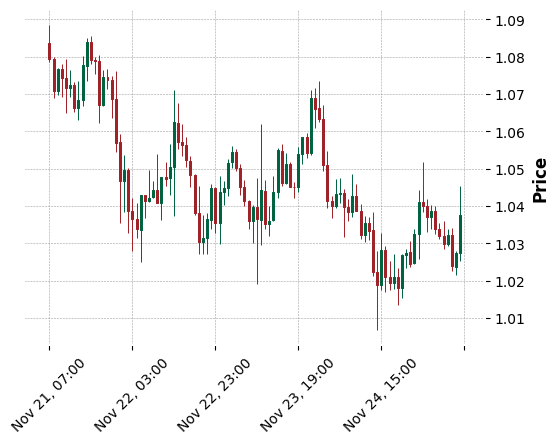

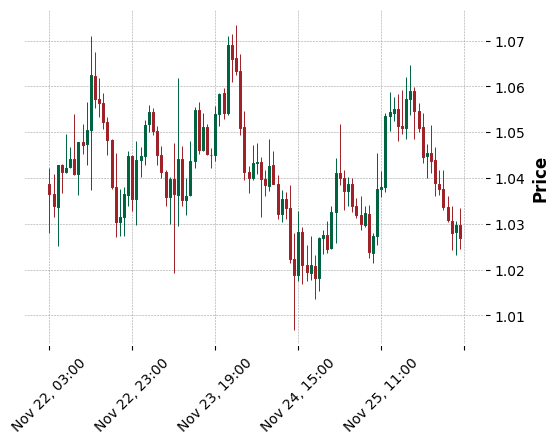

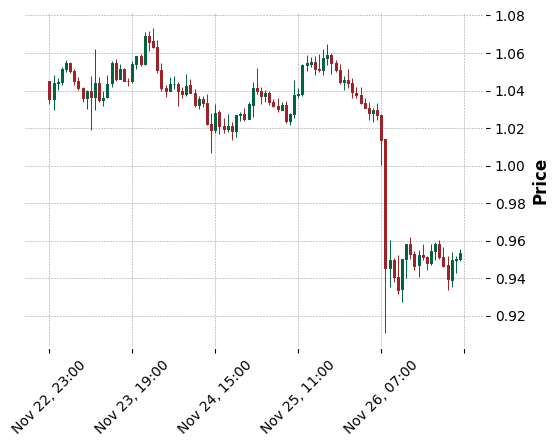

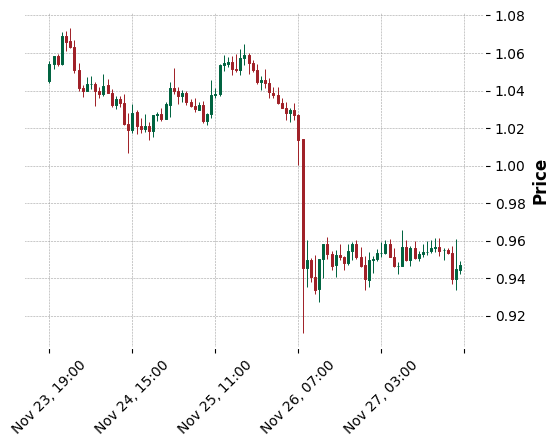

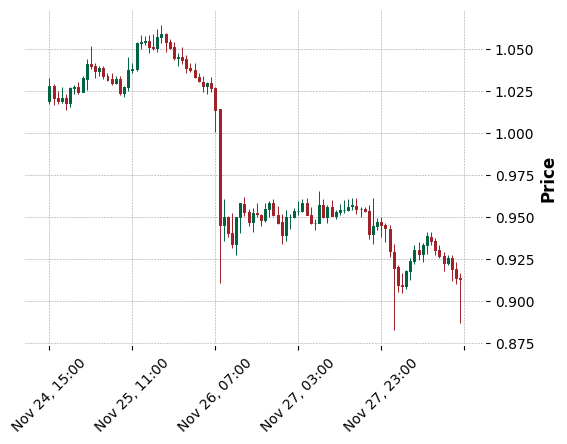

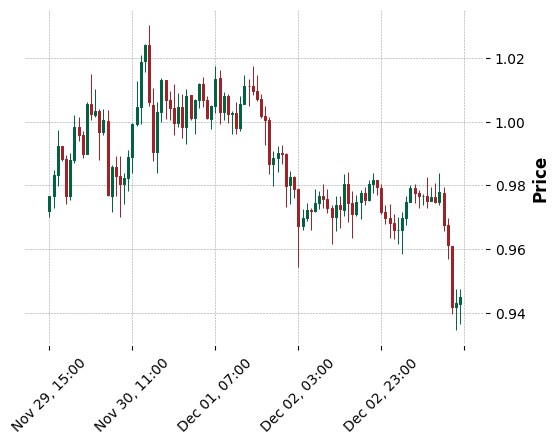

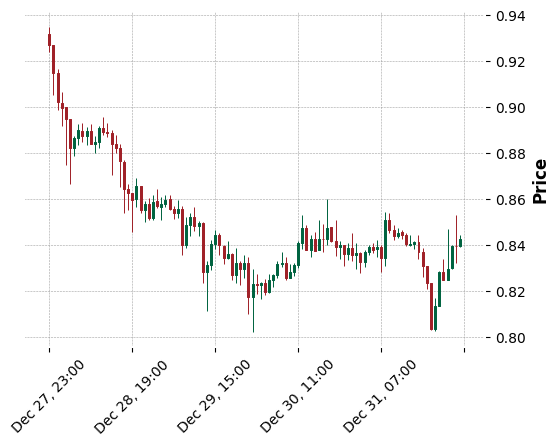

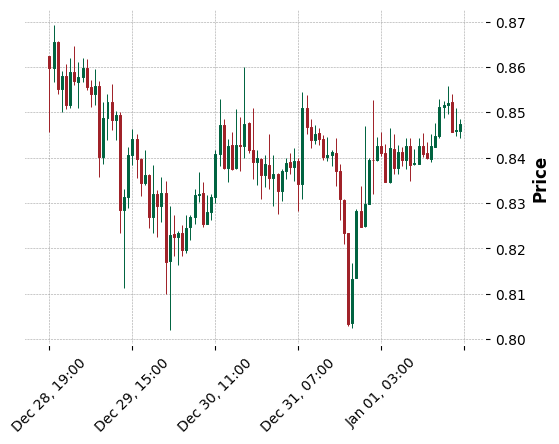

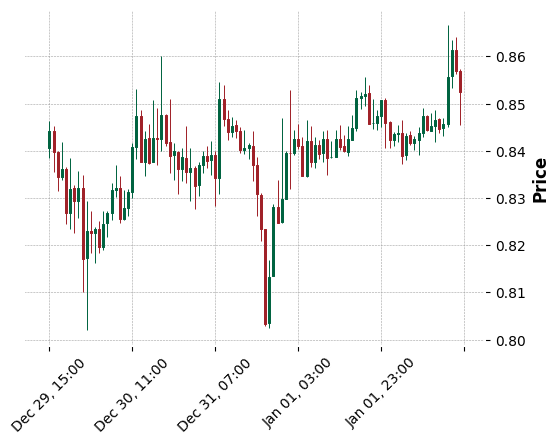

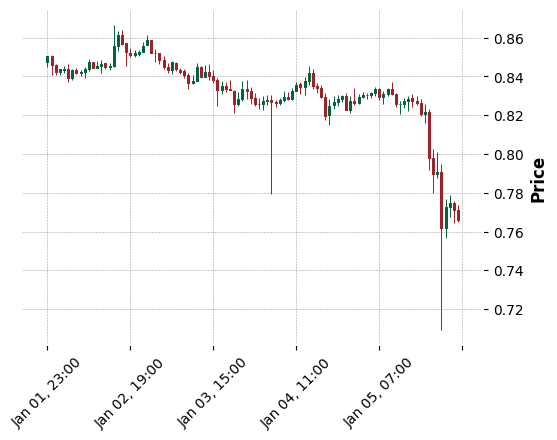

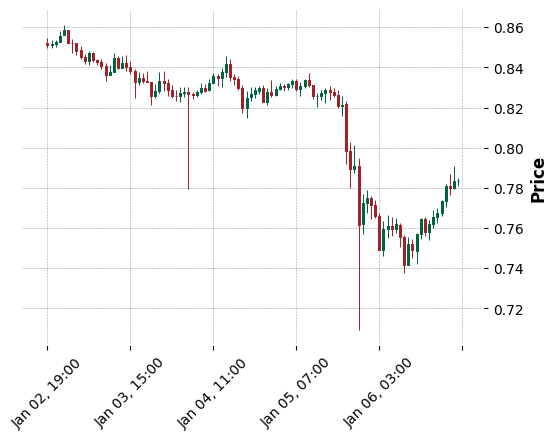

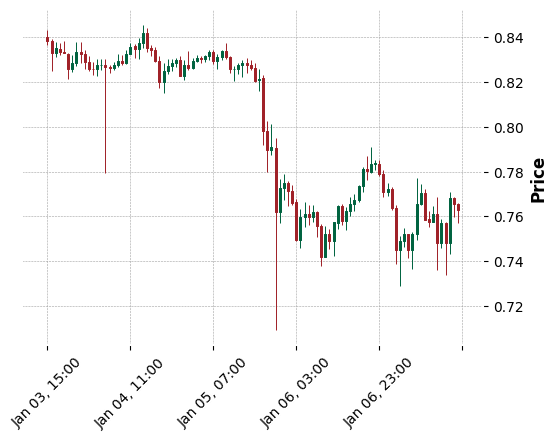

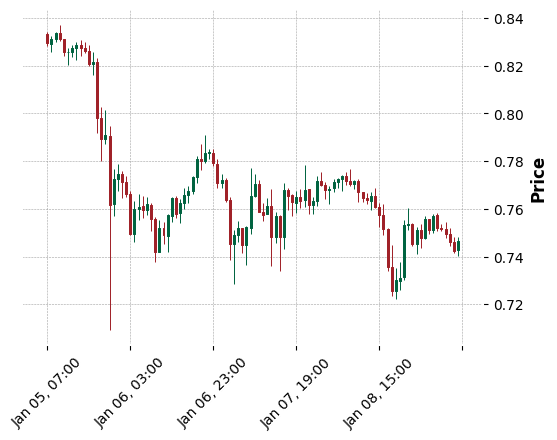

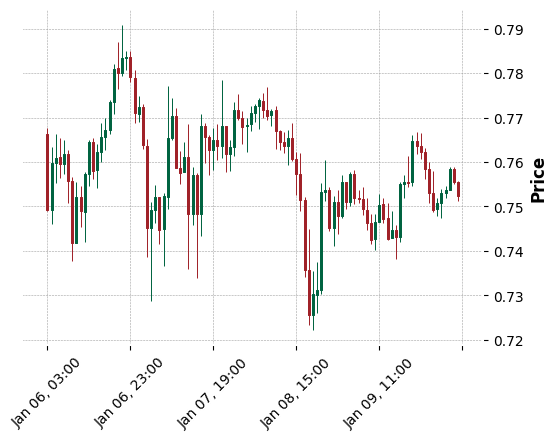

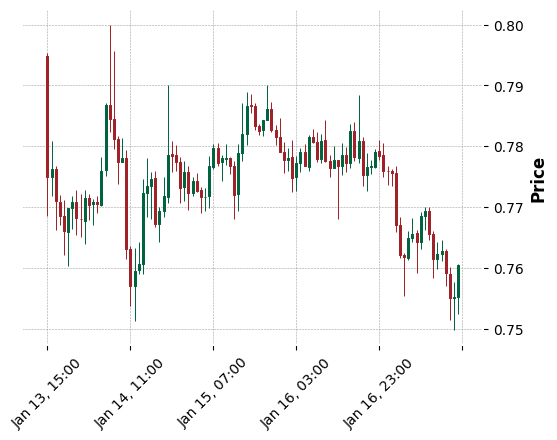

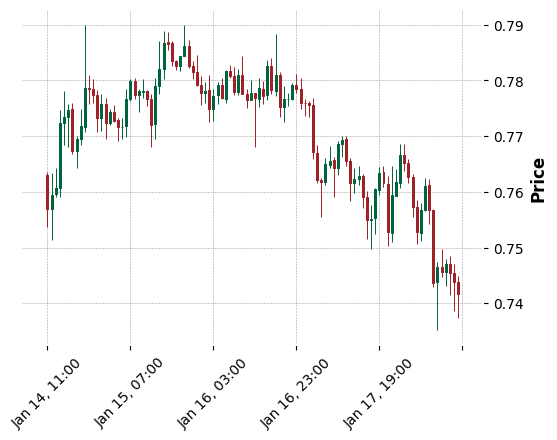

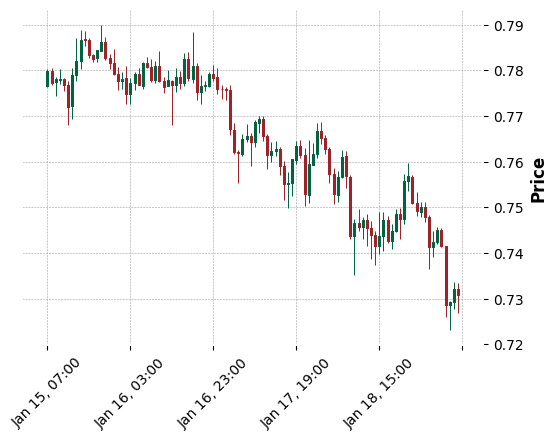

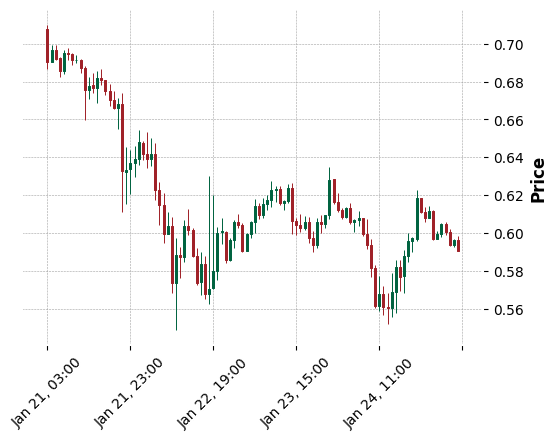

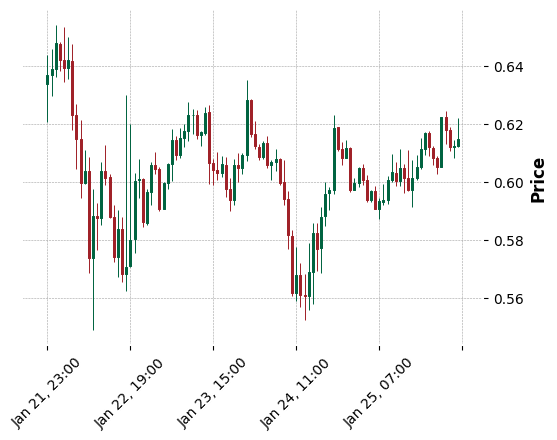

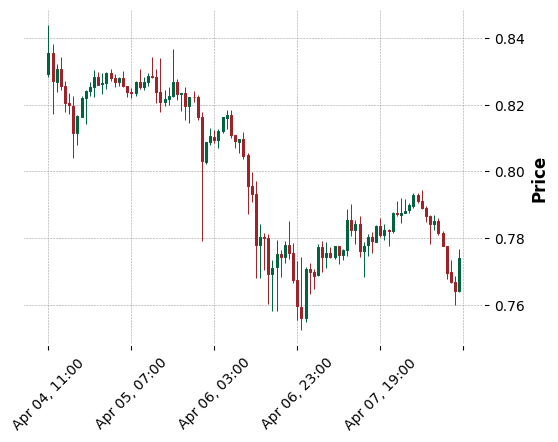

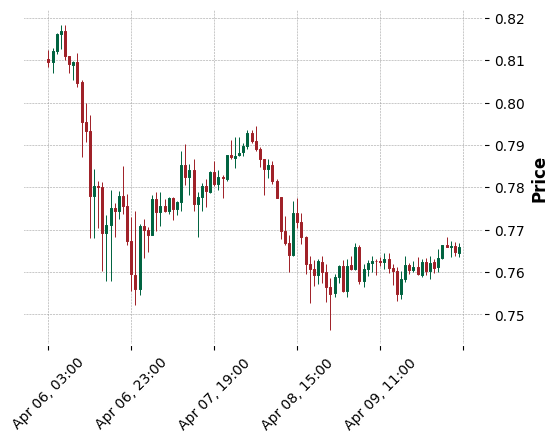

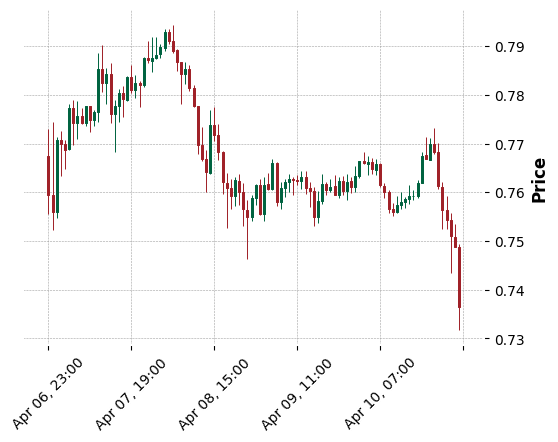

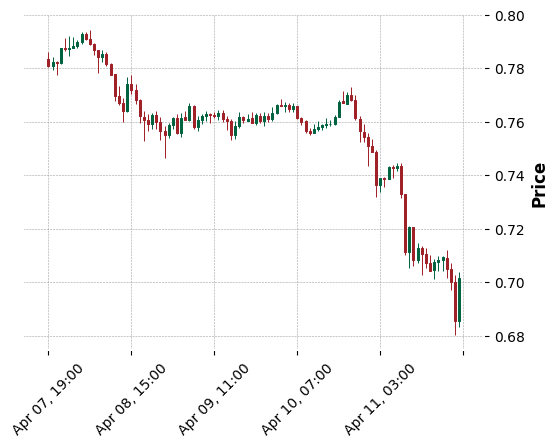

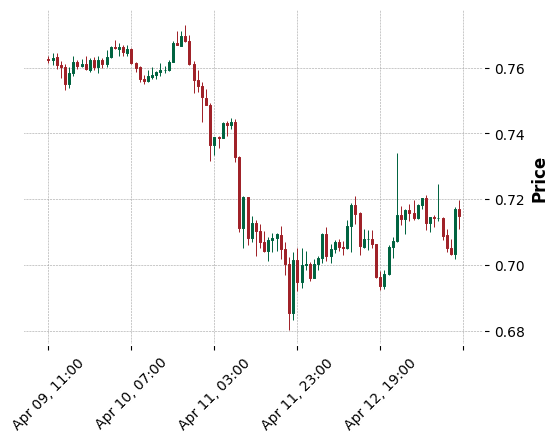

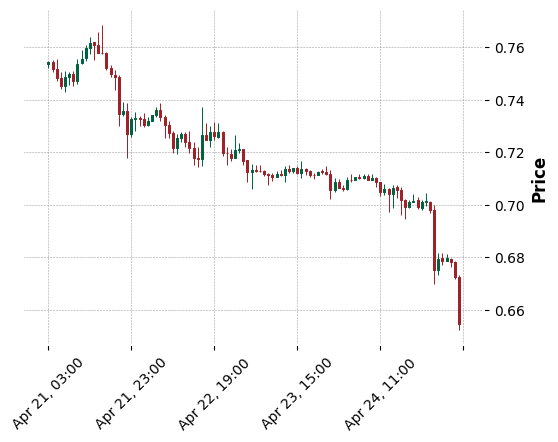

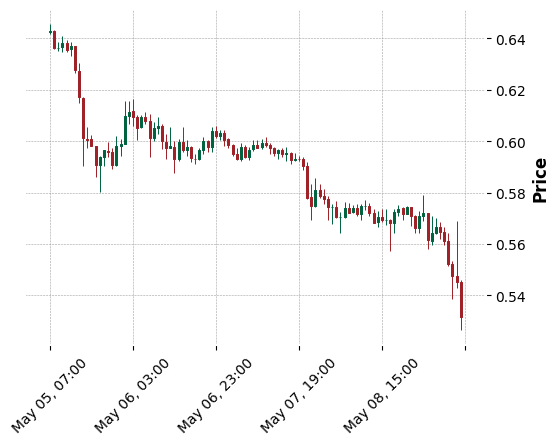

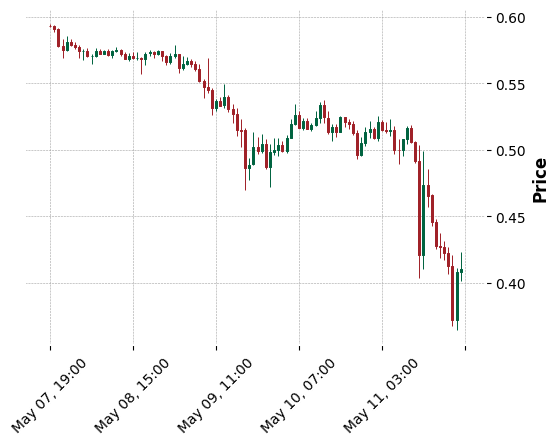

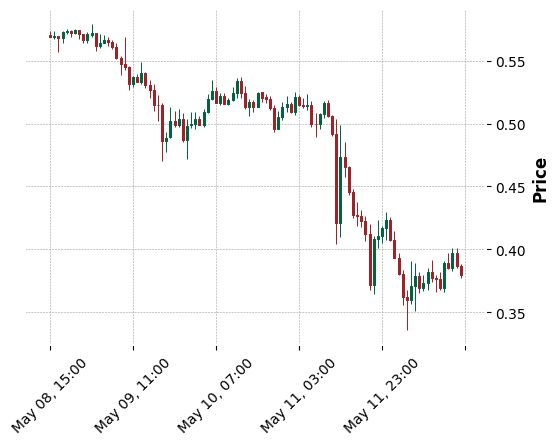

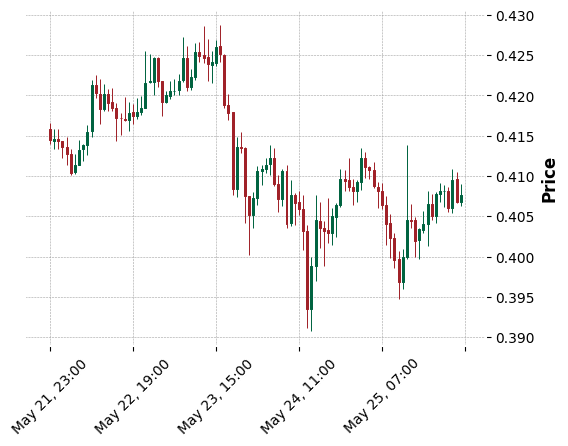

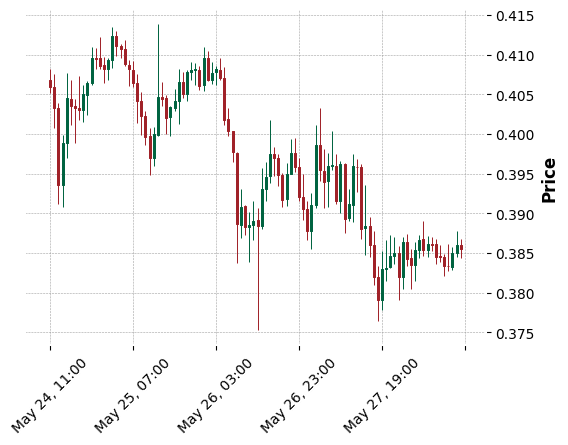

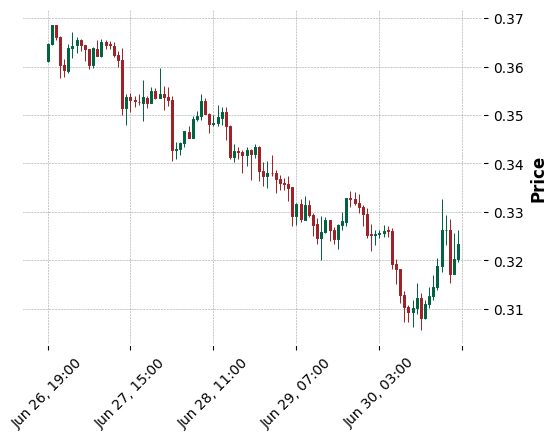

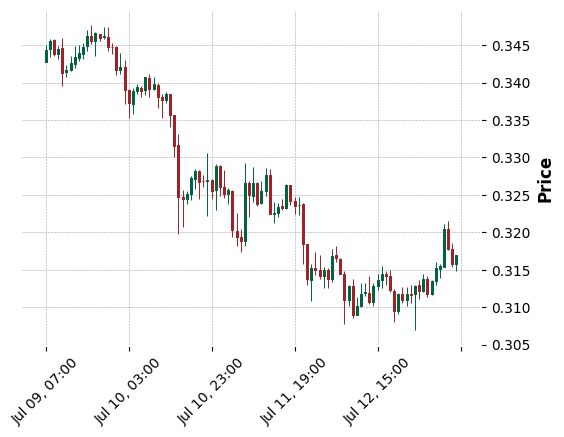

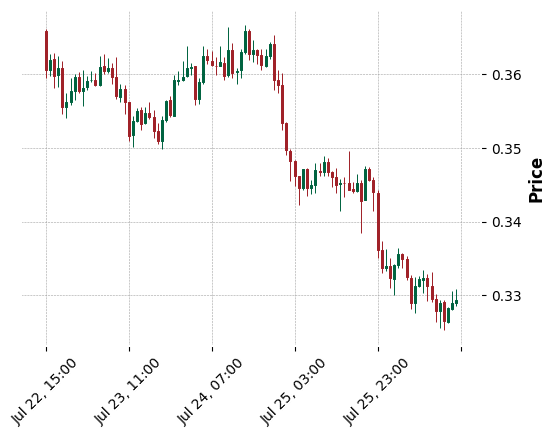

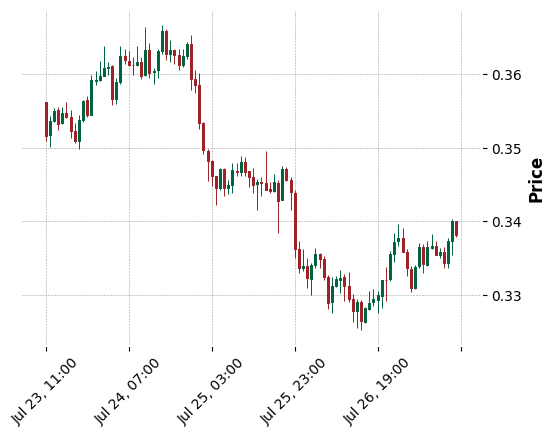

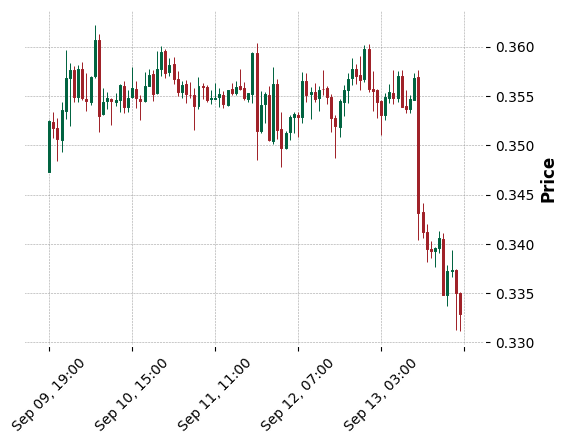

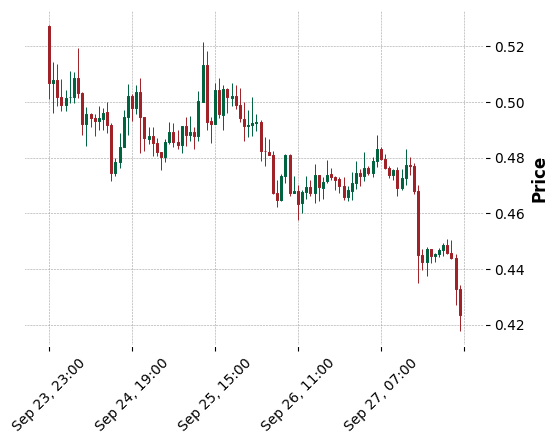

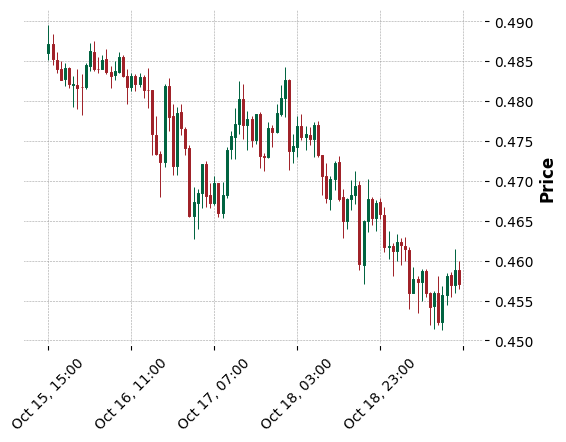

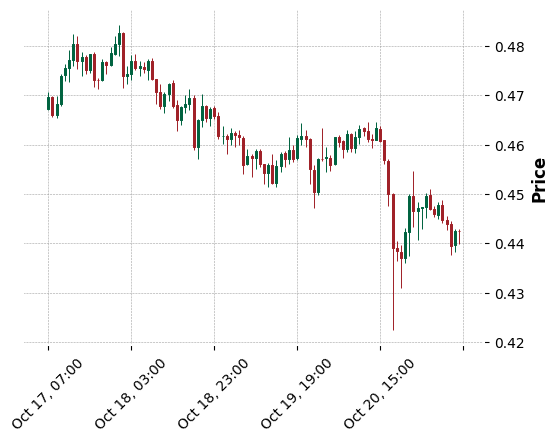

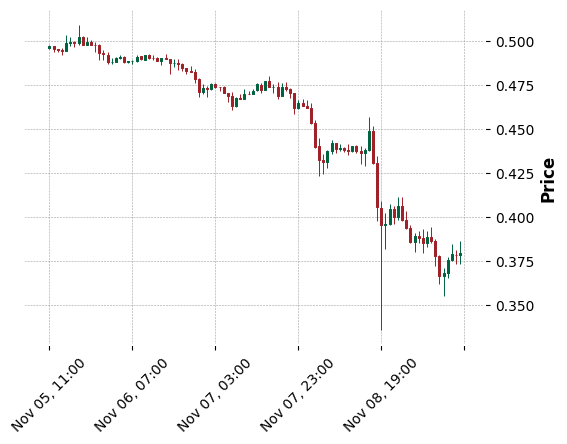

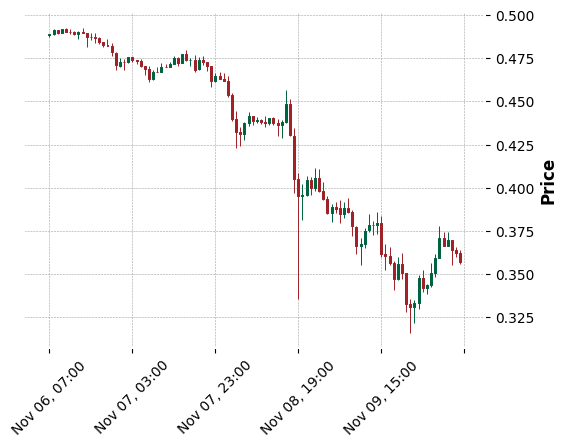

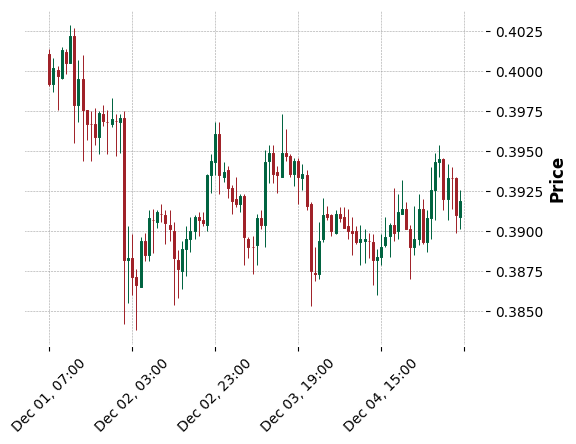

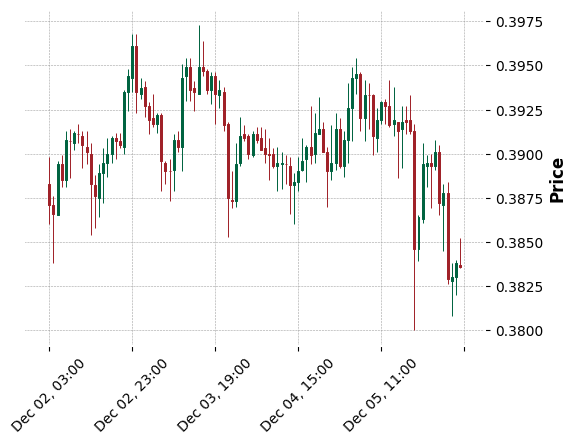

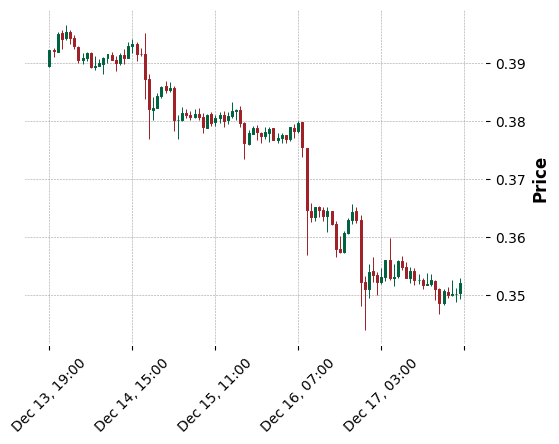

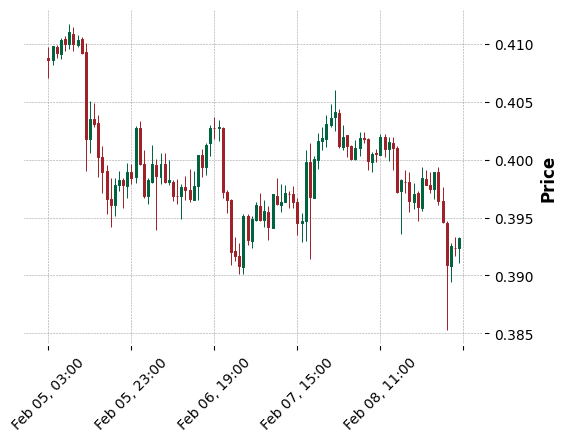

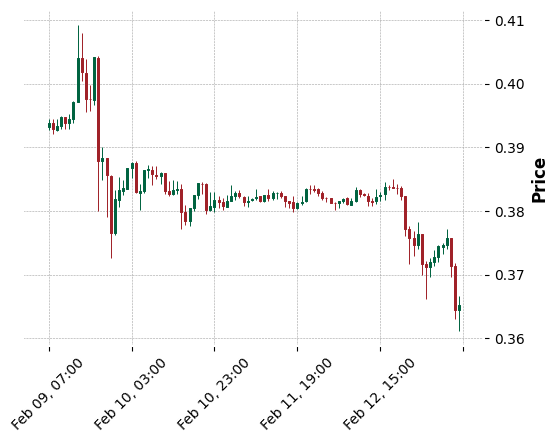

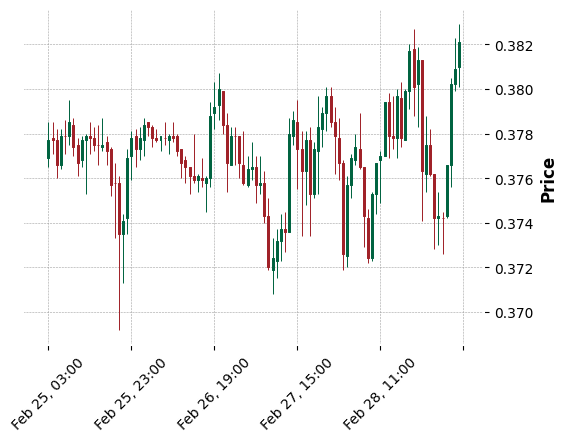

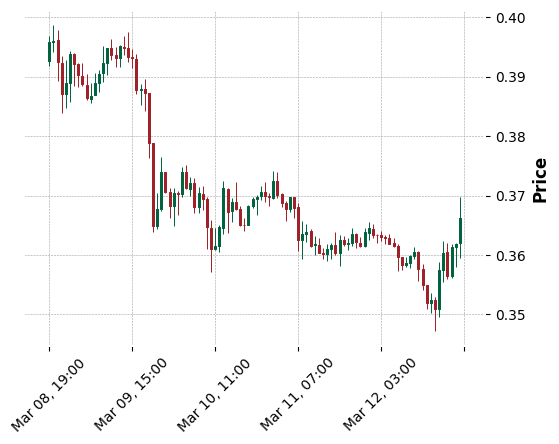

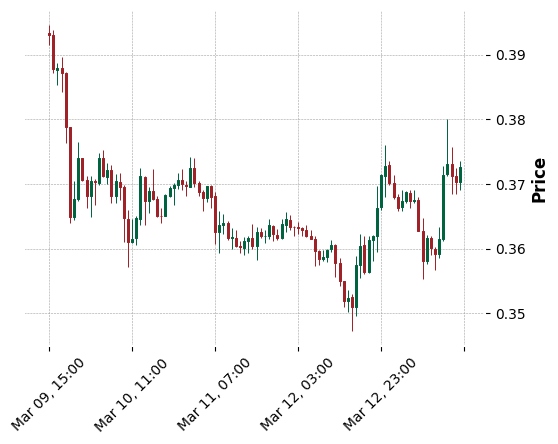

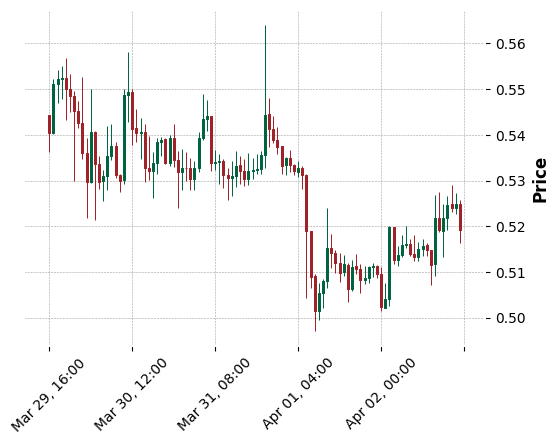

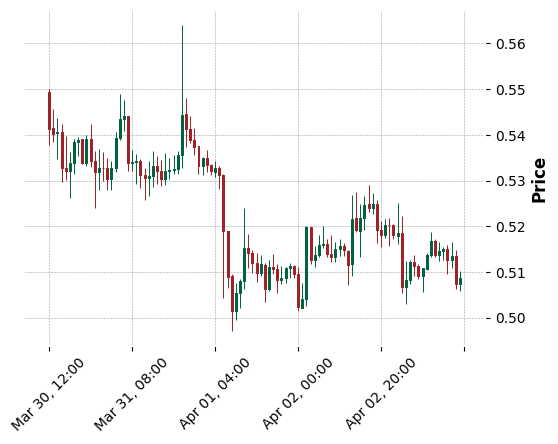

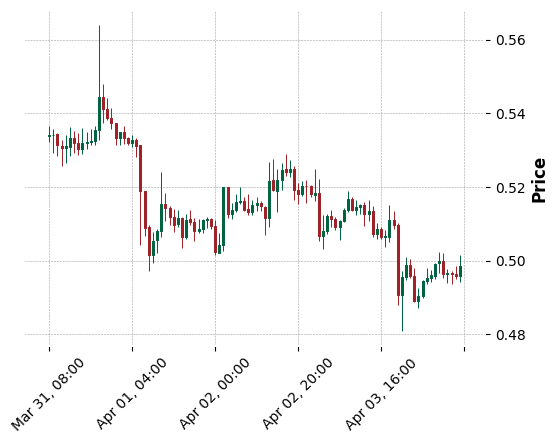

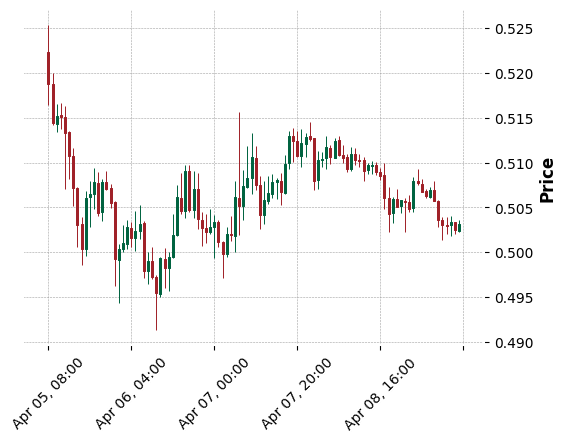

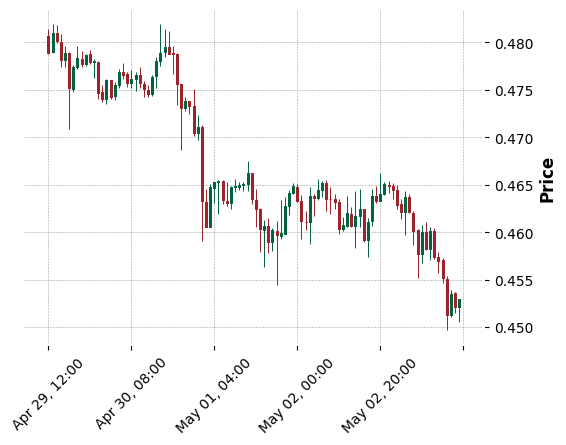

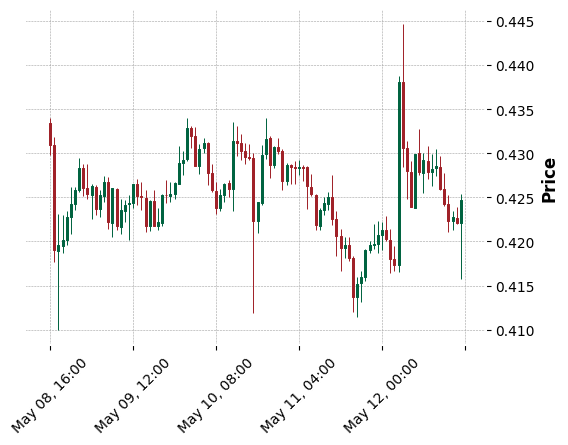

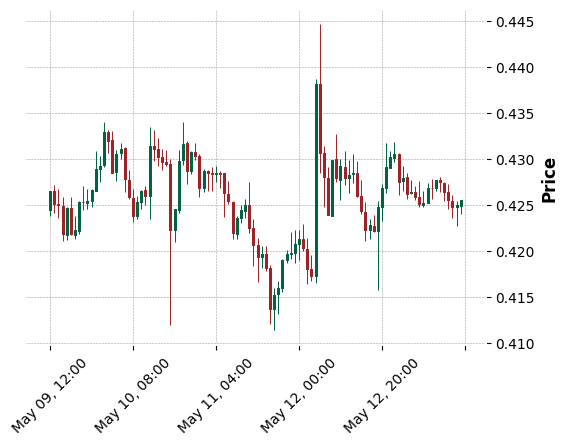

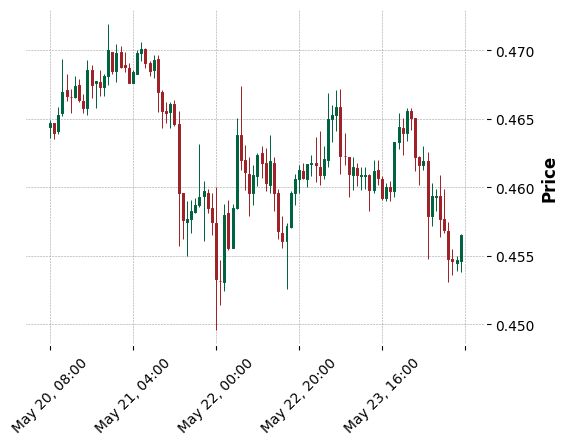

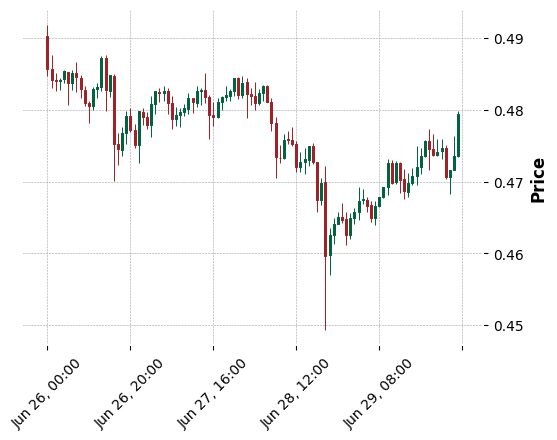

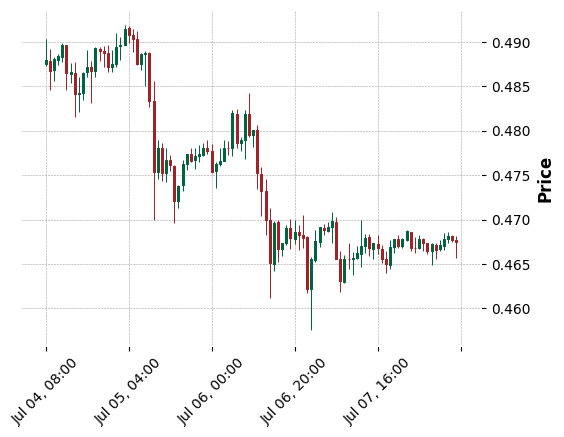

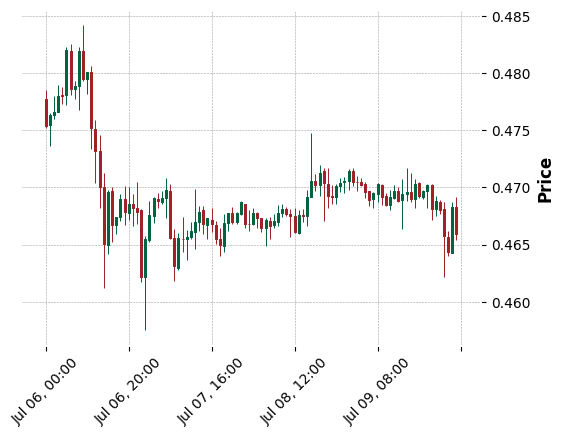

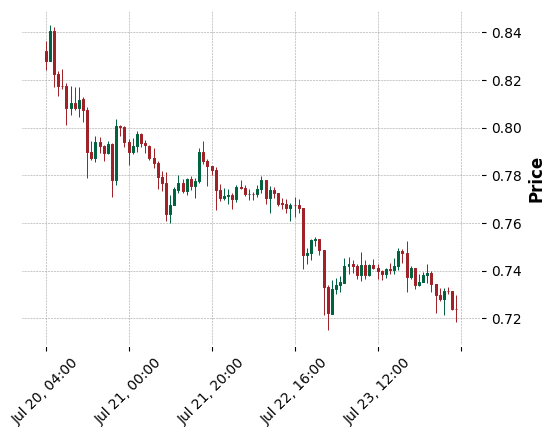

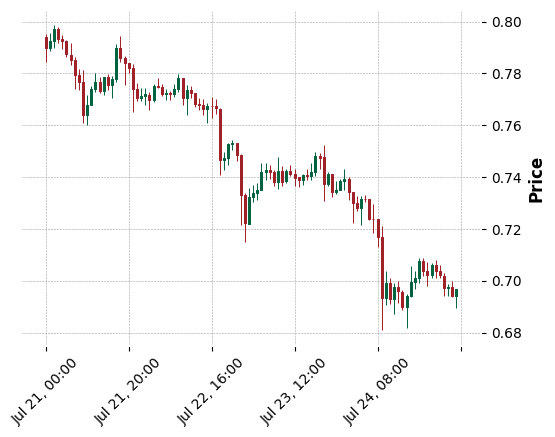

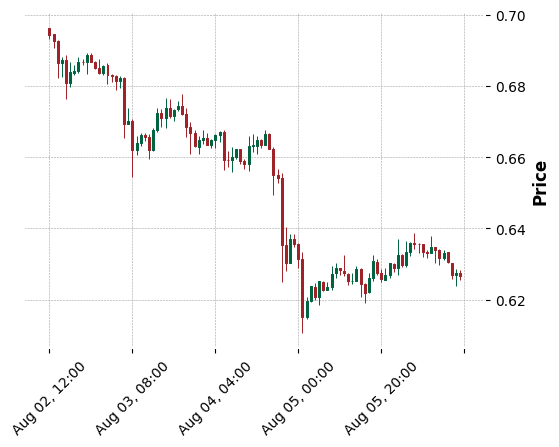

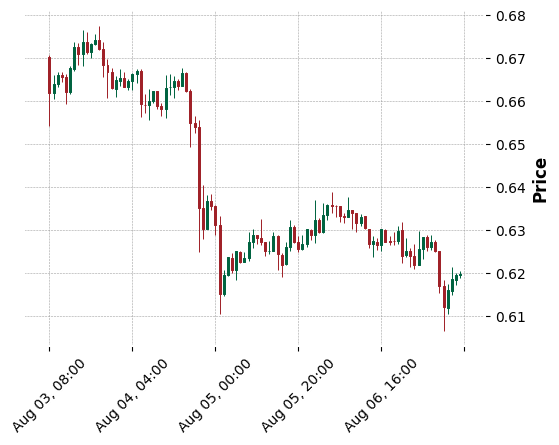

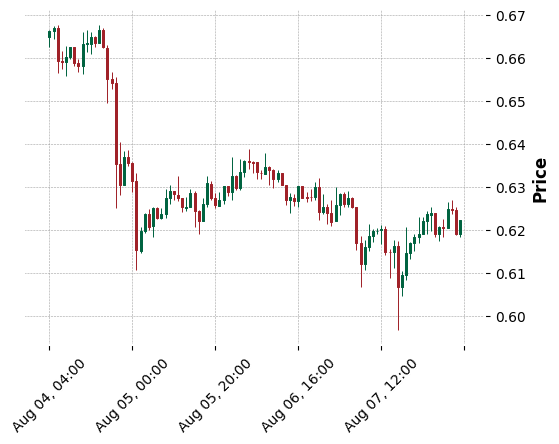

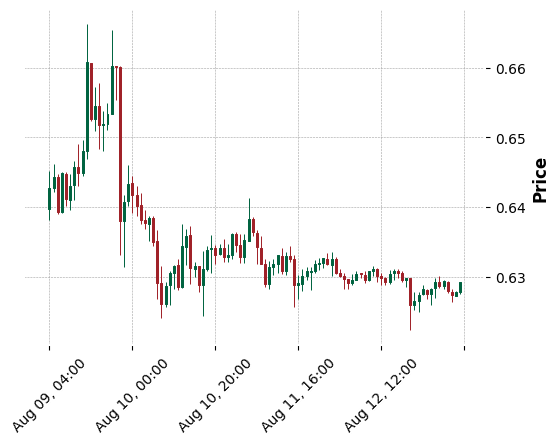

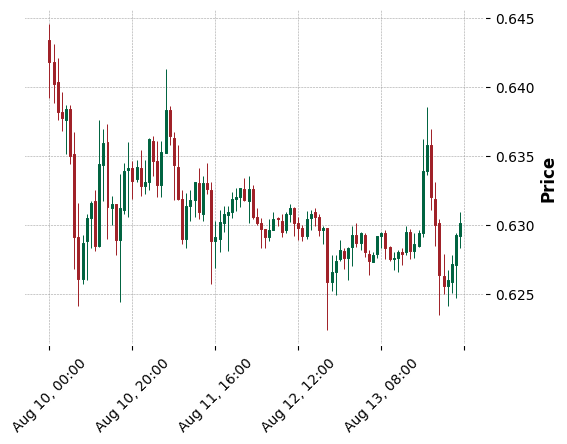

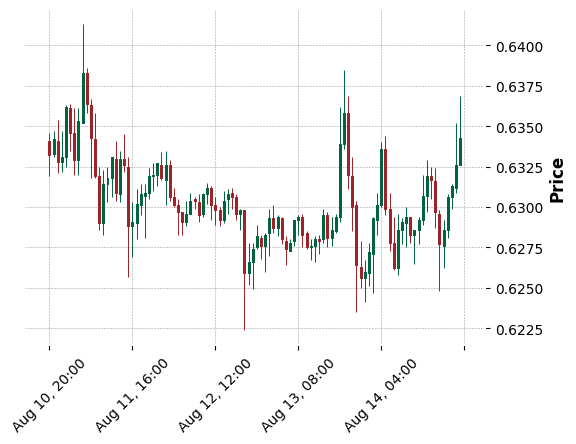

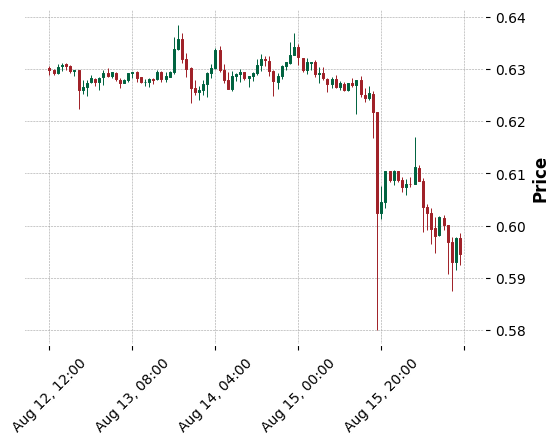

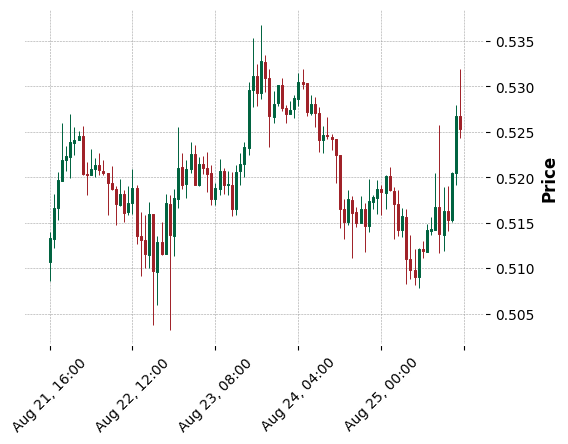

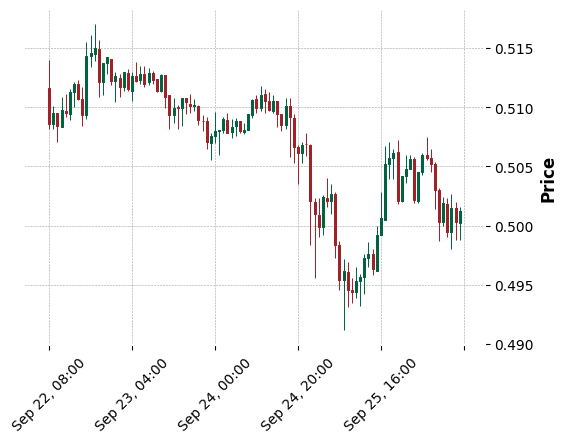

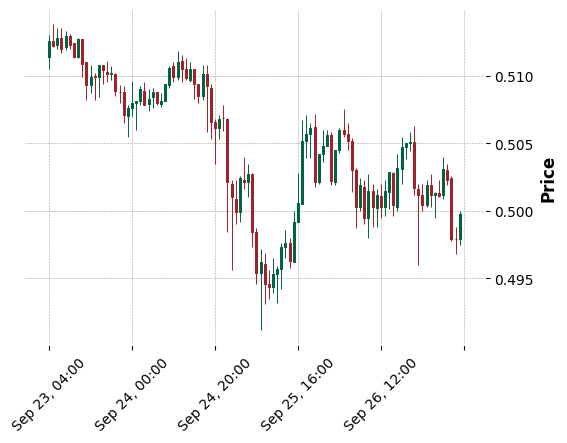

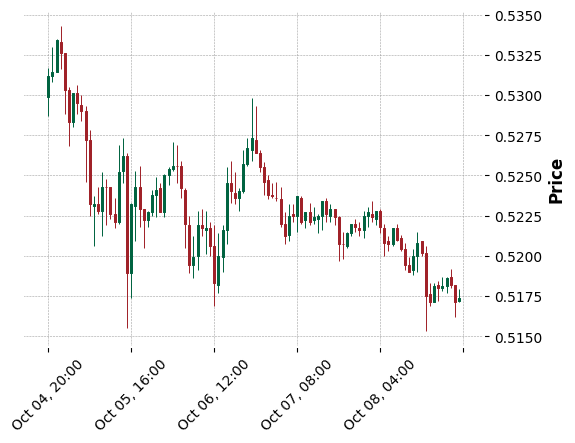

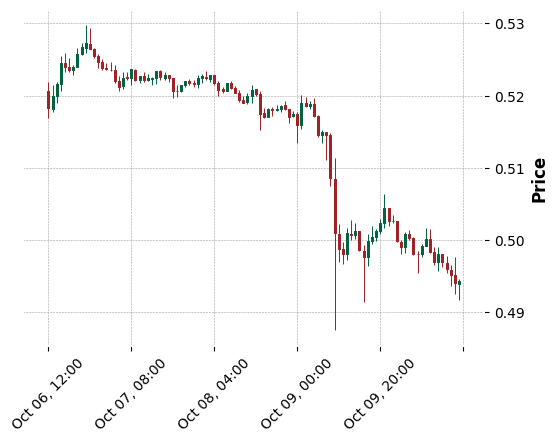

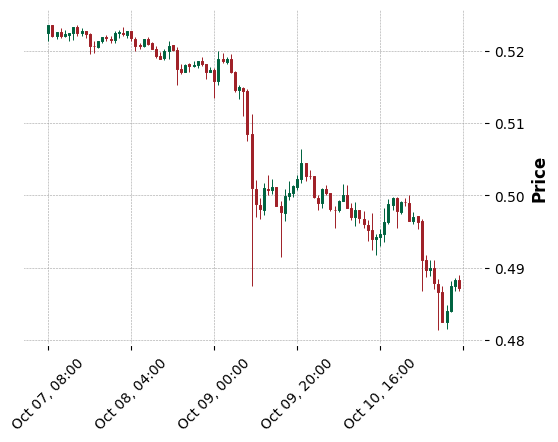

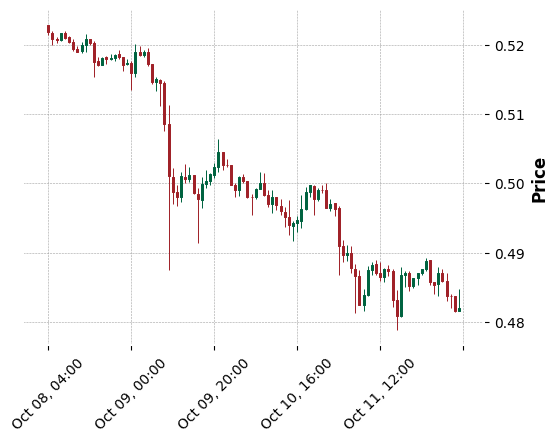

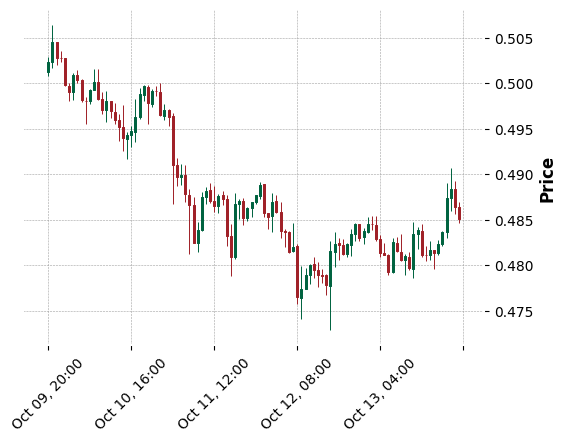

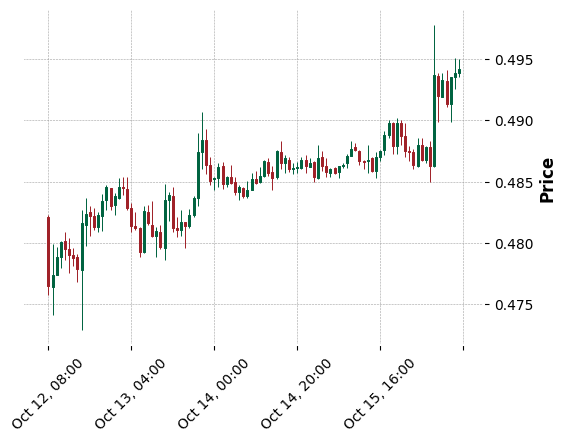

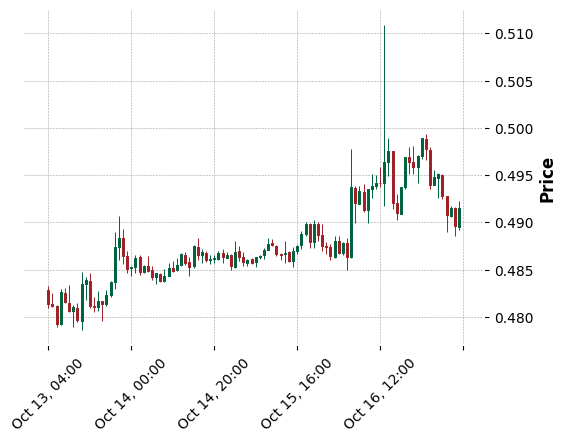

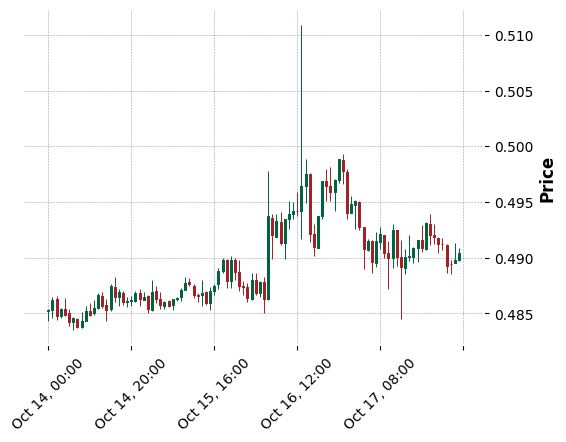

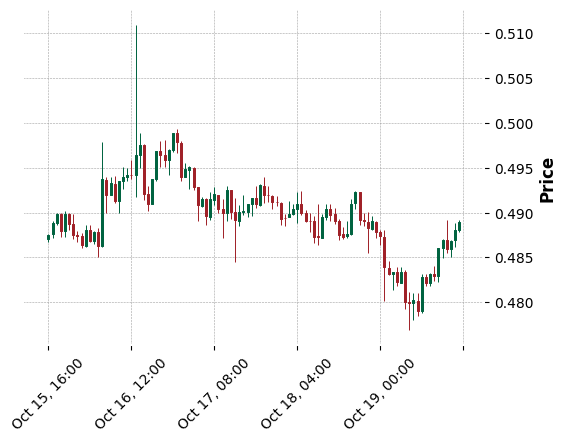

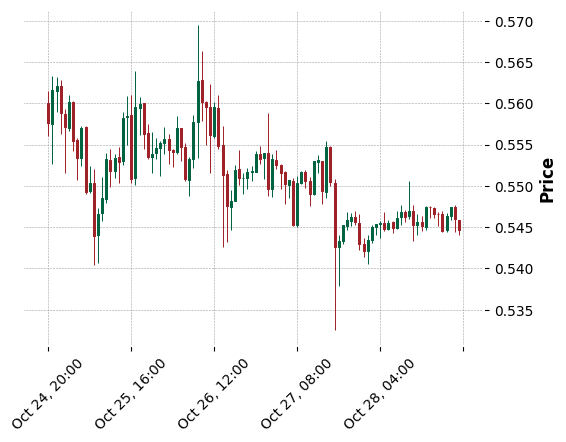

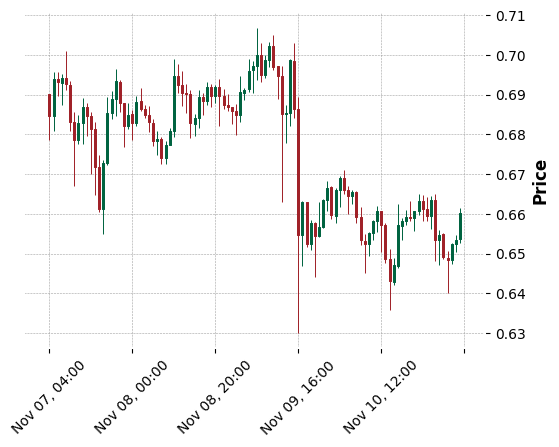

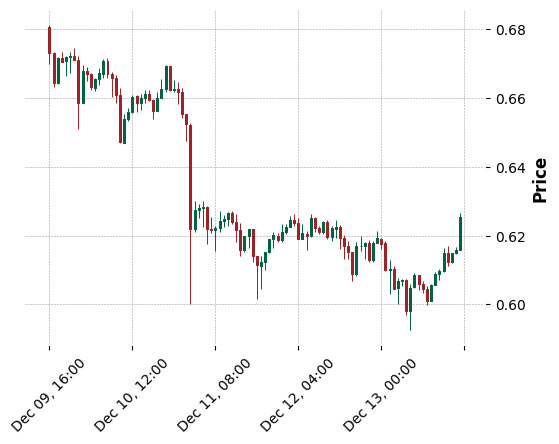

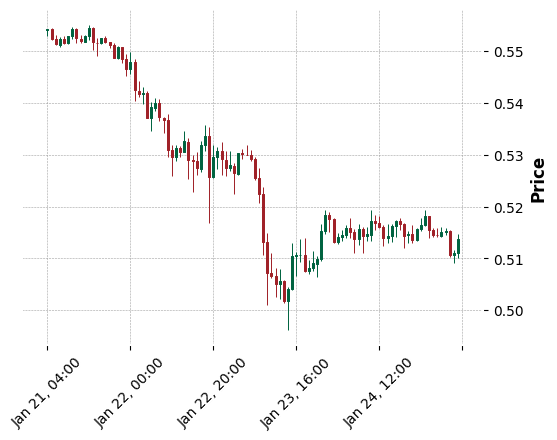

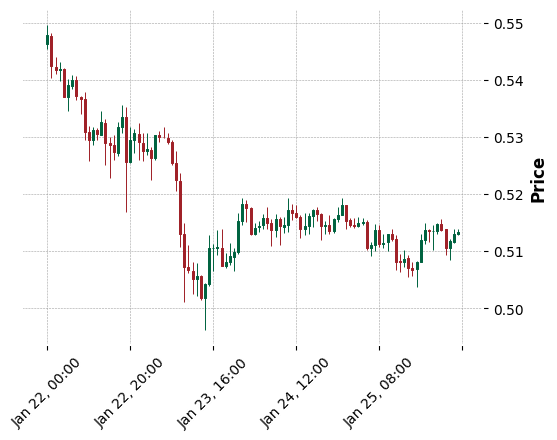

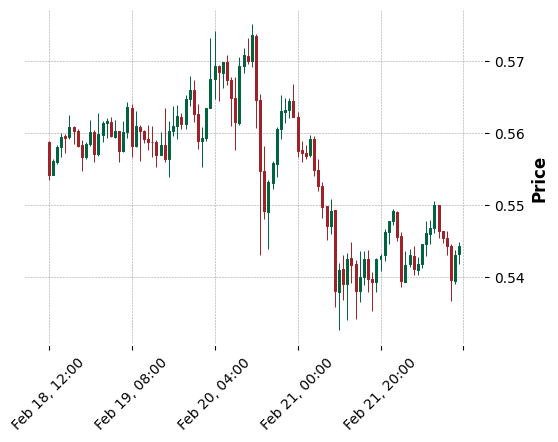

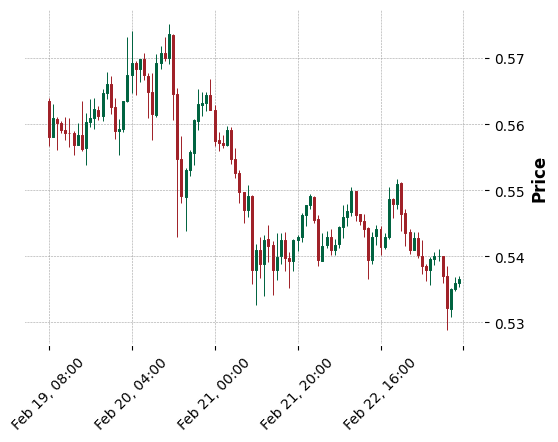

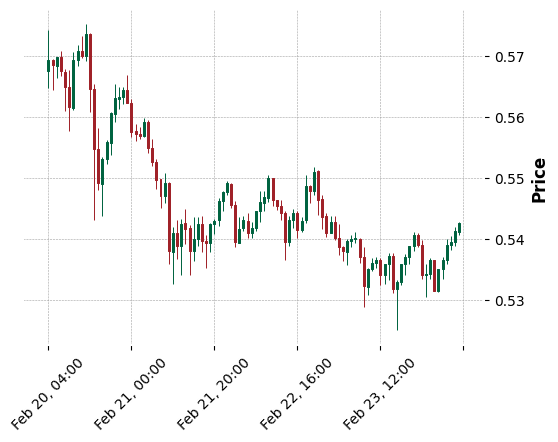

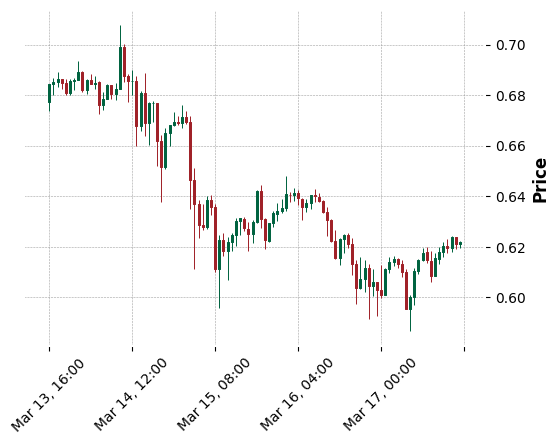

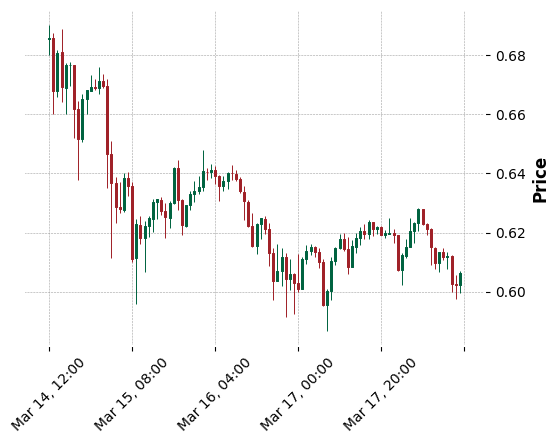

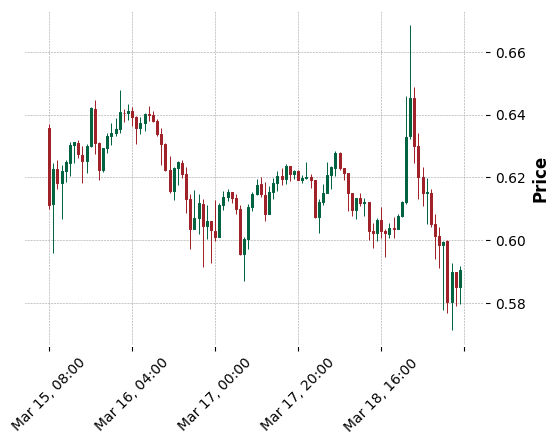

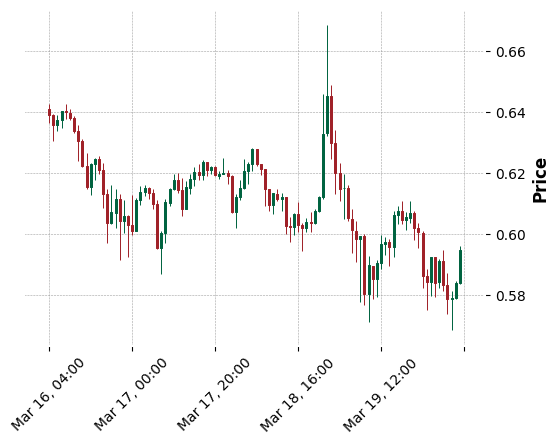

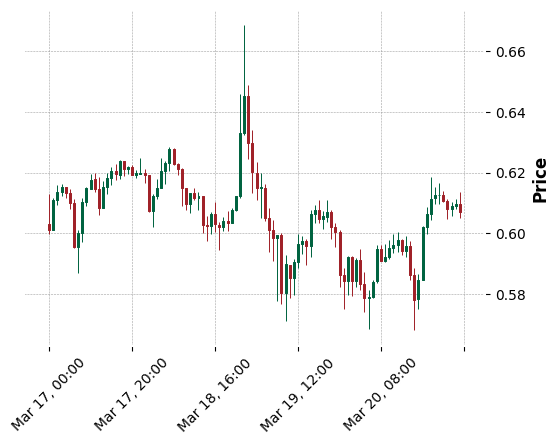

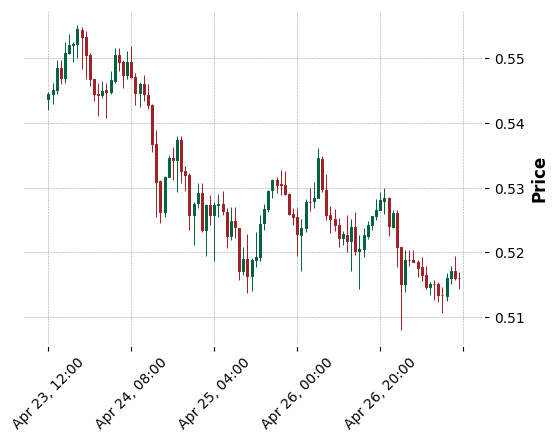

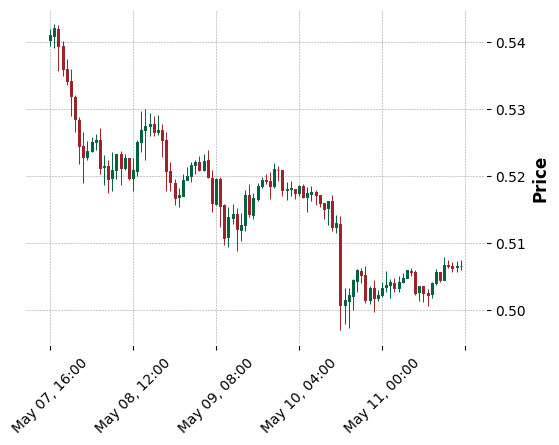

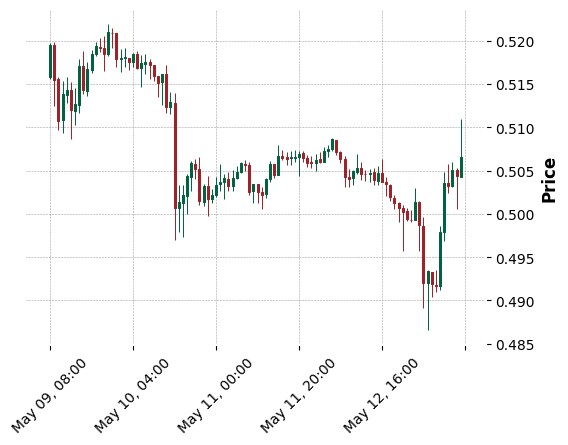

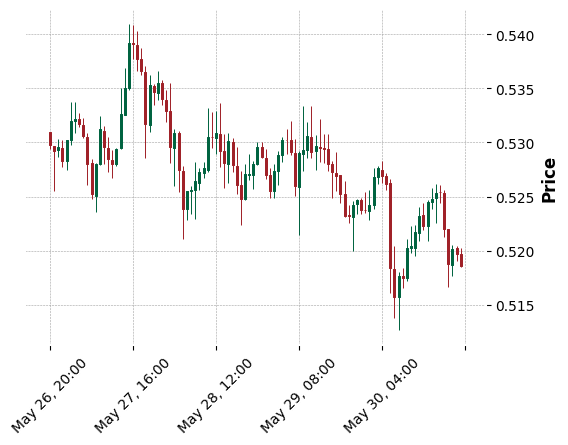

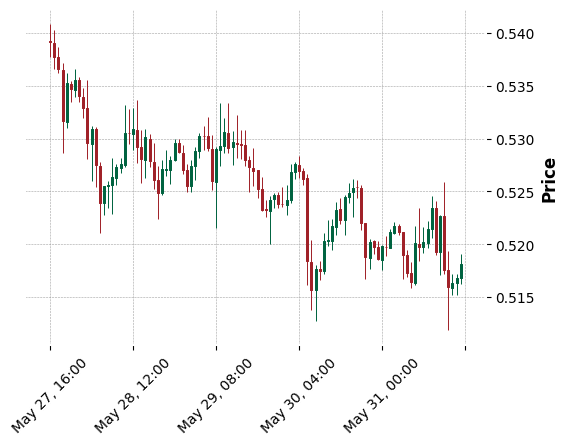

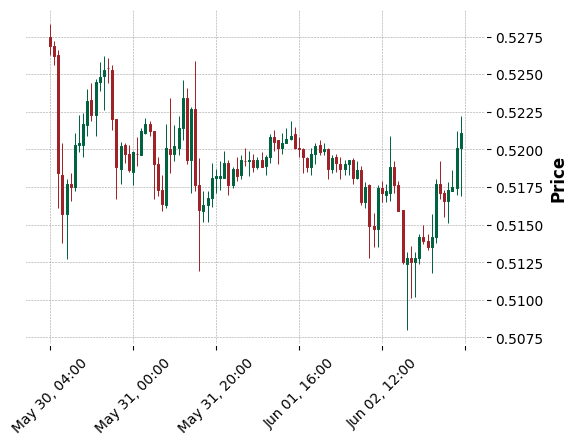

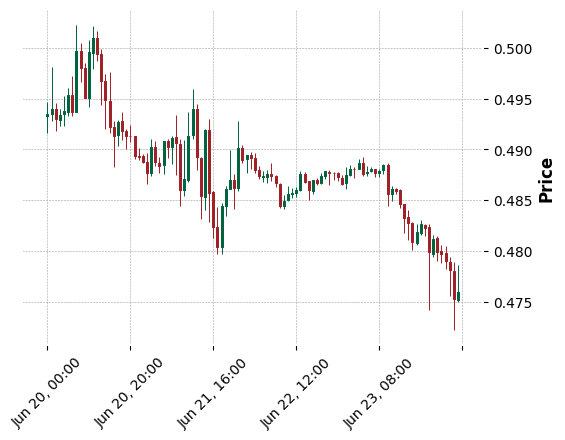

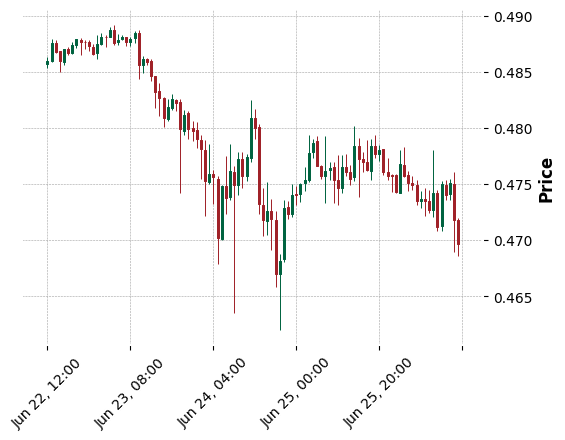

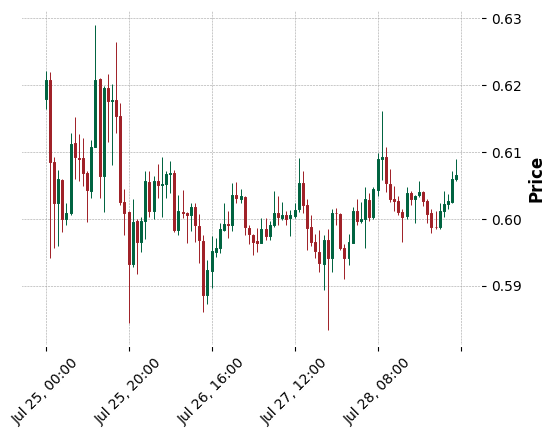

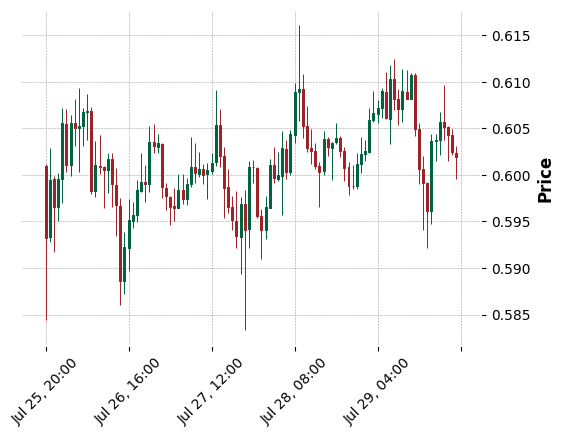

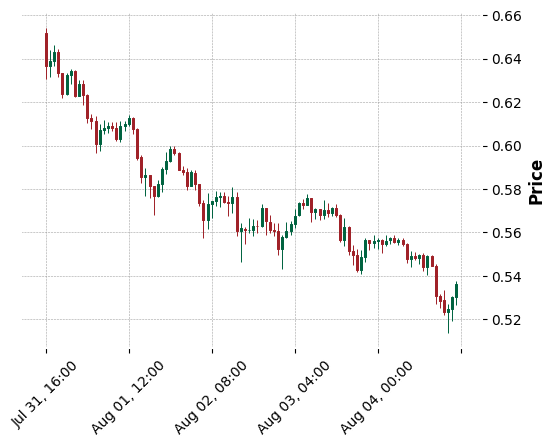

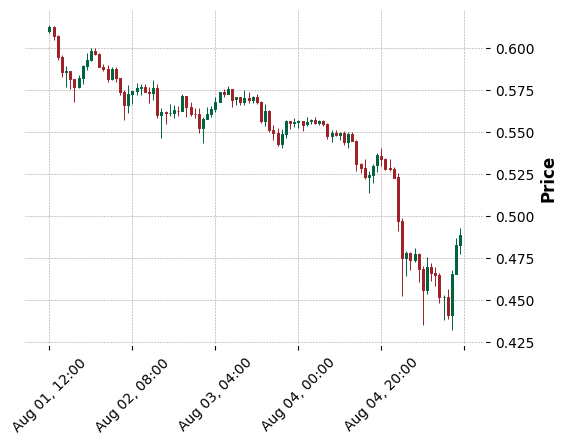

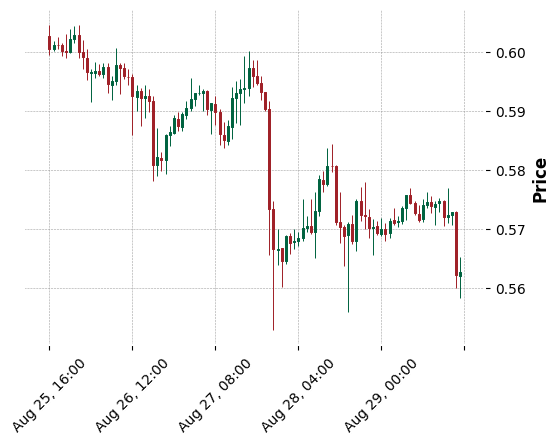

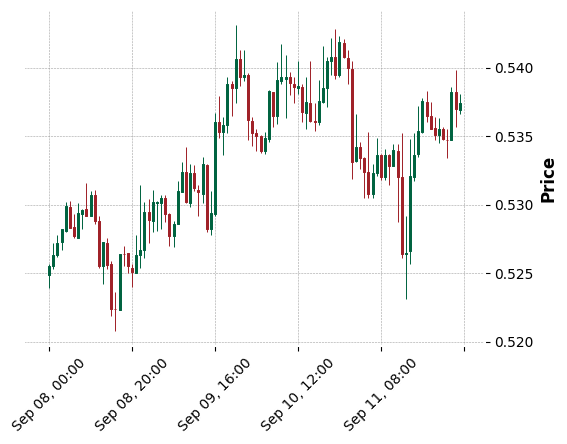

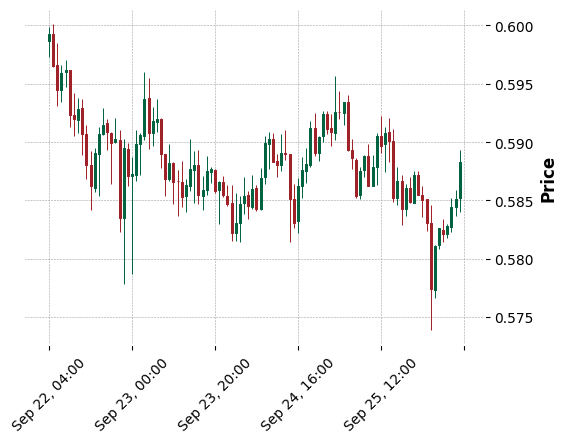

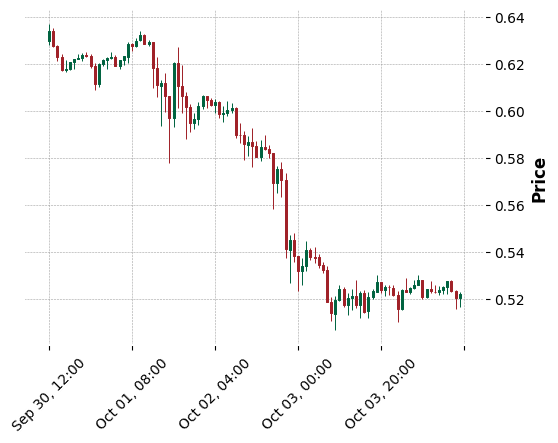

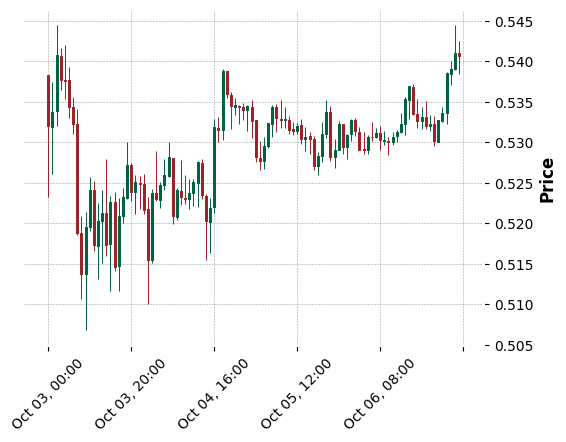

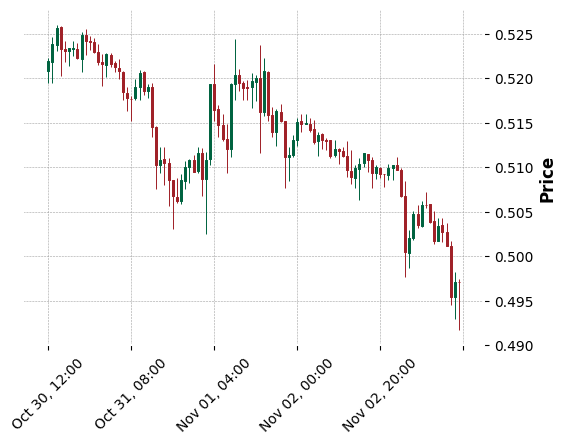

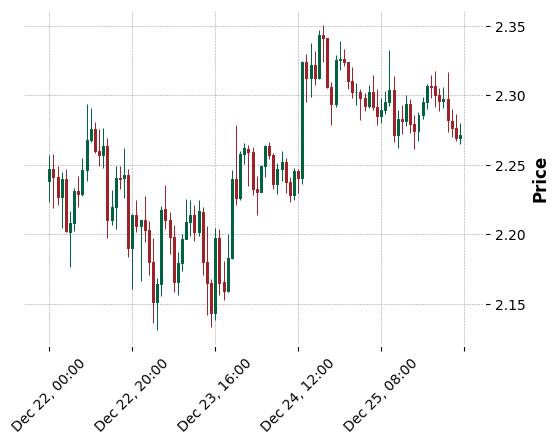

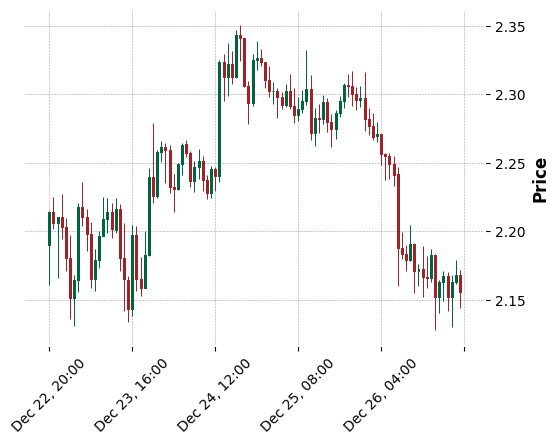

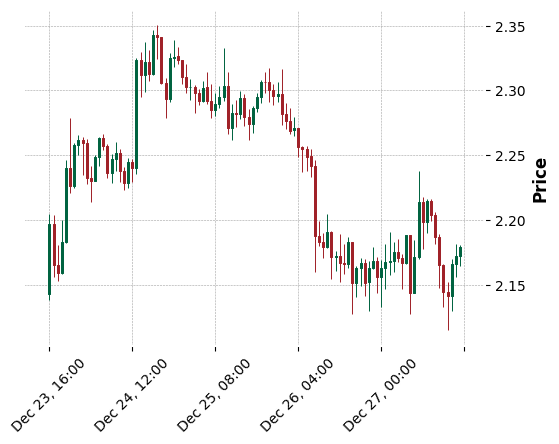

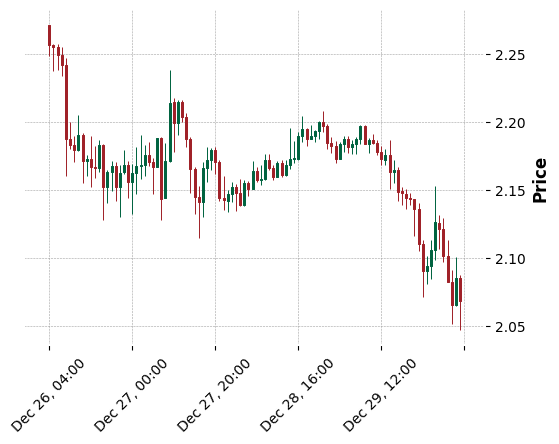

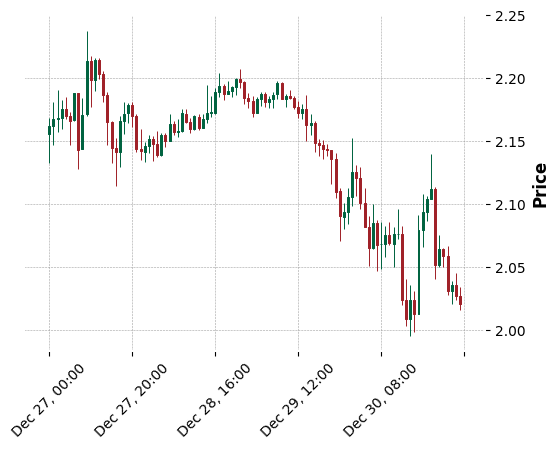

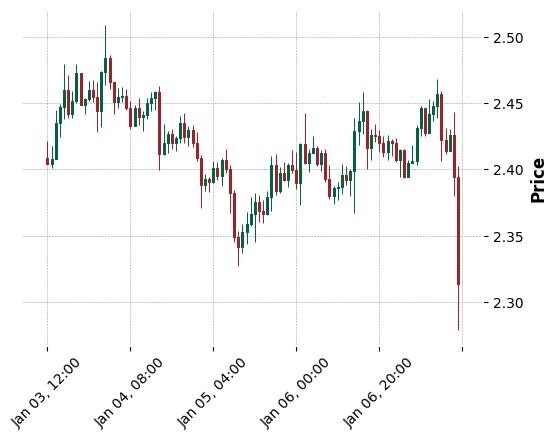

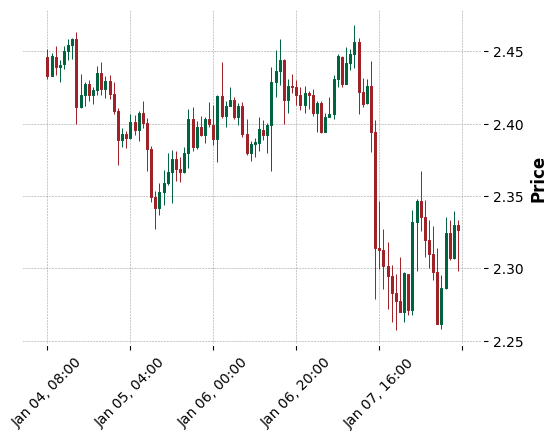

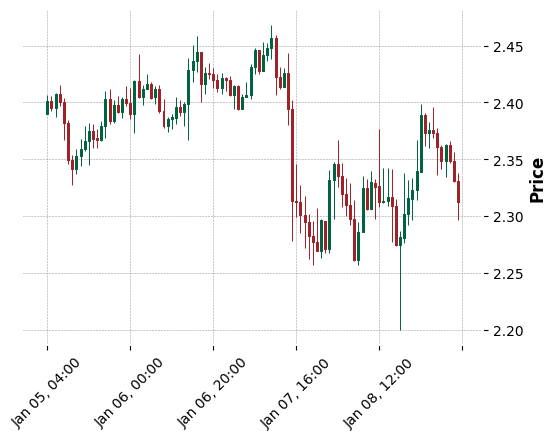

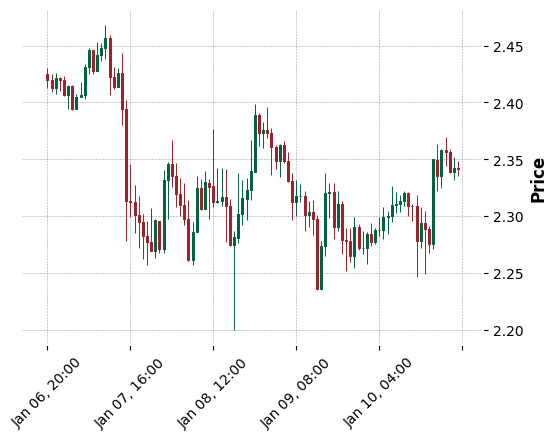

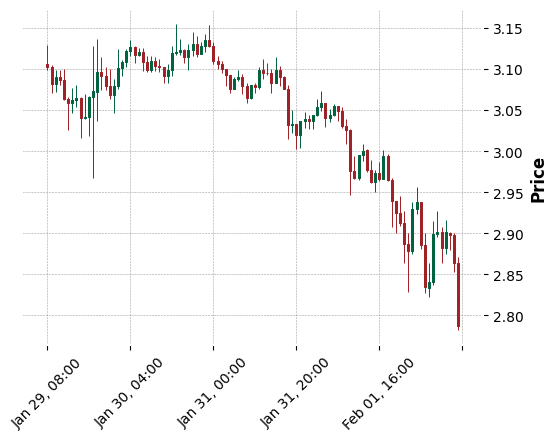

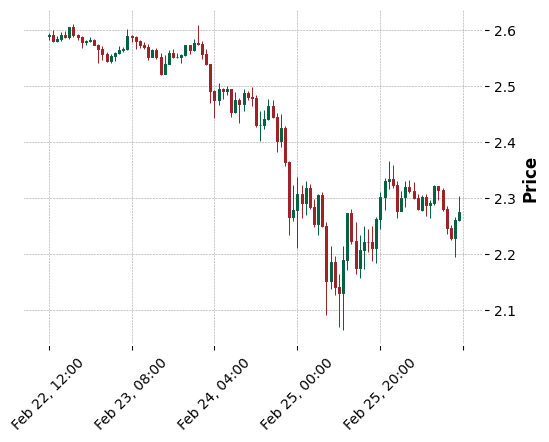

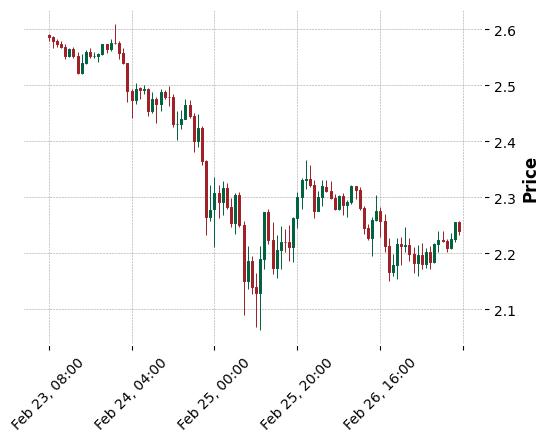

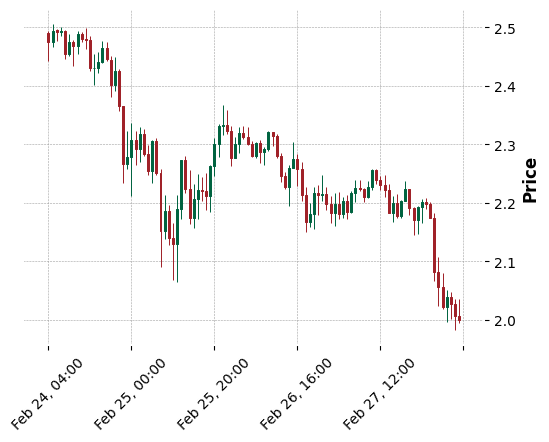

In [27]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from scipy.signal import find_peaks

# --- CONFIG ---
CSV_PATH           = r'C:\Users\chidi\Documents\timeseries_projects\data\XRPUSDT_hourly_2017_2024.csv'
OUTPUT_IMAGE_DIR   = "chart_dataset/images_with_boxes"
OUTPUT_LABEL_DIR   = "chart_dataset/labels"
WINDOW_SIZE_HOURS  = 100
STEP_HOURS         = 20
# Image dimensions
IMAGE_WIDTH, IMAGE_HEIGHT = 640, 480  # figure size in pixels

os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)
os.makedirs(OUTPUT_LABEL_DIR, exist_ok=True)

# --- LOAD DATA ---
df = pd.read_csv(CSV_PATH)
df['open_time'] = pd.to_datetime(df['open_time'])
df.set_index('open_time', inplace=True)

# --- CALCULATE INDICATORS ---
def compute_rsi(series, period=14):
    delta = series.diff()
    gain  = delta.where(delta > 0, 0).rolling(period).mean()
    loss  = -delta.where(delta < 0, 0).rolling(period).mean()
    rs    = gain / loss
    return 100 - (100 / (1 + rs))

if 'rsi' not in df.columns:
    df['rsi'] = compute_rsi(df['close'])

def compute_macd(series, short=12, long=26, signal=9):
    ema_s = series.ewm(span=short, adjust=False).mean()
    ema_l = series.ewm(span=long,  adjust=False).mean()
    macd_line = ema_s - ema_l
    sig_line  = macd_line.ewm(span=signal, adjust=False).mean()
    return macd_line, sig_line

if 'macd' not in df.columns or 'macd_signal' not in df.columns:
    df['macd'], df['macd_signal'] = compute_macd(df['close'])

# --- CLASS MAP ---
CLASSES = {
    "rsi_overbought": 0,
    "macd_bullish":   1,
    "triangle_asc":   2,
    "triangle_desc":  3,
    "cup_handle":     4
}

# --- DETECTION HELPERS ---
def detect_rsi_overbought(win):
    return (win['rsi'] > 70).sum() >= 3

def detect_macd_bullish(win):
    return (win['macd'].iloc[-1] > win['macd_signal'].iloc[-1]
            and win['macd'].iloc[-2] <= win['macd_signal'].iloc[-2])

def detect_triangle_patterns(win, kind):
    prices = win['close'].values
    peaks, _    = find_peaks(prices, distance=3)
    troughs, _ = find_peaks(-prices, distance=3)
    results = []
    if len(peaks)>=2 and len(troughs)>=2:
        highs = prices[peaks[-2:]]
        lows  = prices[troughs[-2:]]
        center = (peaks[-1] + troughs[-1]) / 2 / len(prices)
        if kind=='ascending' and abs(highs[0]-highs[1])<0.005*highs[0] and lows[1]>lows[0]:
            results.append(("triangle_asc", center, 0.6, 0.2, 0.2))
        if kind=='descending' and abs(lows[0]-lows[1])<0.005*lows[0] and highs[1]<highs[0]:
            results.append(("triangle_desc", center, 0.6, 0.2, 0.2))
    return results

def detect_cup_handle(win):
    prices = win['close'].values
    mi = np.argmin(prices)
    left, right = prices[:mi], prices[mi+1:]
    if len(left)>=5 and len(right)>=5:
        if np.all(left>prices[mi]) and np.all(right>prices[mi]):
            if abs(np.mean(left[-3:]) - np.mean(right[:3]))/prices[mi]>0.05:
                return [("cup_handle", mi/len(prices), 0.4, 0.3, 0.2)]
    return []

# --- MAIN LOOP ---
count = 0
n = len(df)
for start in range(0, n - WINDOW_SIZE_HOURS, STEP_HOURS):
    win = df.iloc[start:start+WINDOW_SIZE_HOURS]
    if len(win) < WINDOW_SIZE_HOURS:
        continue

    # Plot candlestick chart
    fig, axes = mpf.plot(
        win, type='candle', style='charles', volume=False,
        returnfig=True, figsize=(IMAGE_WIDTH/100, IMAGE_HEIGHT/100)
    )
    fig.set_dpi(100)
    ax = axes[0]  # main price axis

    annotations = []

    # 1) RSI Overbought
    if detect_rsi_overbought(win):
        annotations.append(("rsi_overbought", 0.5, 0.3, 0.6, 0.2))  # (label, xc, yc, w, h)

    # 2) MACD Bullish
    if detect_macd_bullish(win):
        annotations.append(("macd_bullish", 0.5, 0.7, 0.6, 0.2))

    # 3) Triangles
    annotations += detect_triangle_patterns(win, 'ascending')
    annotations += detect_triangle_patterns(win, 'descending')

    # 4) Cup & Handle
    annotations += detect_cup_handle(win)

    # Overlay boxes in axis‐fraction coordinates
    for label, xc, yc, w, h in annotations:
        cls_id = CLASSES[label]
        # Lower-left corner in axis‐fraction coords:
        x0, y0 = xc - w/2, yc - h/2
        rect = plt.Rectangle(
            (x0, y0), w, h,
            transform=ax.transAxes,
            fill=False, edgecolor='red', linewidth=2
        )
        ax.add_patch(rect)
        # Add text label:
        ax.text(xc, yc + h/2 + 0.02, label,
                transform=ax.transAxes,
                ha='center', va='bottom',
                color='red', fontsize=8)

    # Save only if we have annotations
    if annotations:
        img_name = f"xrp_{count:04d}.png"
        fig.savefig(os.path.join(OUTPUT_IMAGE_DIR, img_name), bbox_inches='tight')
        plt.close(fig)

        # Write YOLO .txt file
        lbl_name = img_name.replace('.png', '.txt')
        with open(os.path.join(OUTPUT_LABEL_DIR, lbl_name), 'w') as f:
            for label, xc, yc, w, h in annotations:
                f.write(f"{CLASSES[label]} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}\n")

        count += 1

print(f"\n✅ Generated {count} annotated charts with bounding boxes.")  
